In [ ]:
"""
    use two variables derived from PPE and use those two to predict another variable using Gaussian Process Regression (GPR)
"""

In [2]:
kernels=['Linear','Bias','White','Exponential','RBF','Polynomial','Matern12']
# kernels=['Linear','Bias','White','Exponential']

In [4]:
import itertools
out = itertools.combinations(kernels,3)

In [5]:
for combination in out:
   kernel = list(combination),

# load data

ERROR 1: PROJ: proj_create_from_database: Open of /glade/u/home/geethma/.conda/envs/wgh/share/proj failed


xmap
ymap
clrmap
filter
filter2


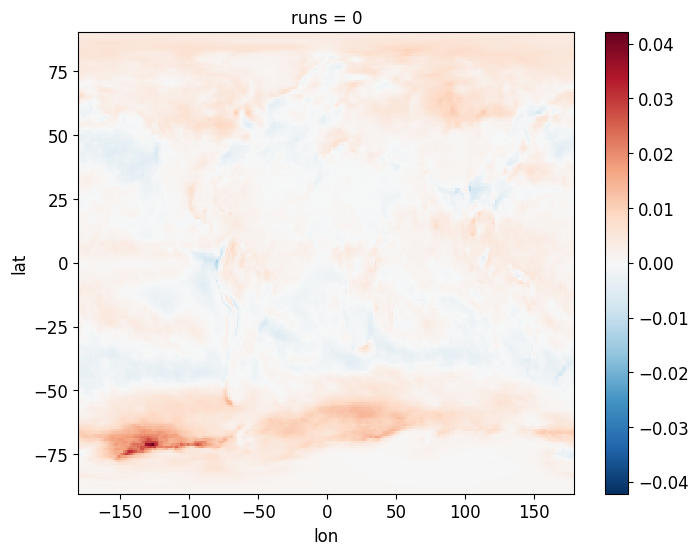

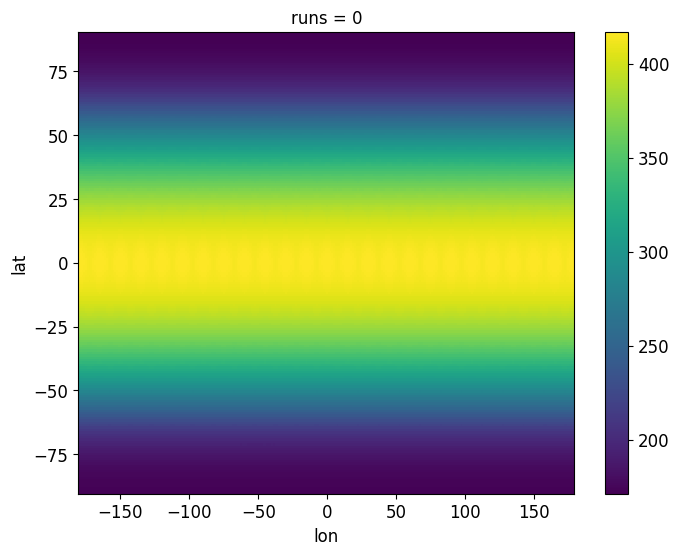

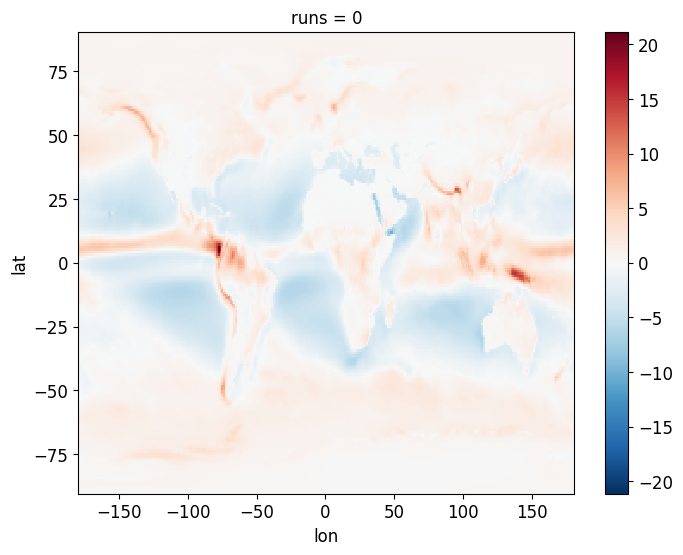

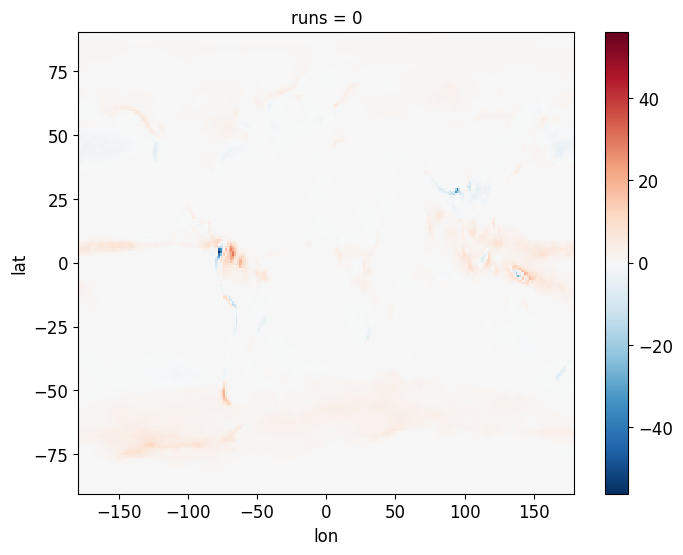

In [1]:
import gc
import sys
exclude = ['gc', 'sys', 'exclude']
for name in dir():
    if name not in exclude and not name.startswith('_'):
        del globals()[name]
gc.collect()
sys.path.append("/glade/u/home/geethma/phd_research_home/functions")
from imports import *
from load_xarray import *
from lat_weight_mean import *
from TOAf import *

LWP_varn="dLWPmap_gol"; T_varn="dTSmap_gol"; ocean=False
Lv = 2264705.  # J/kg
### Load maps
file_names = {
    "dLWPmap": LWP_varn,
    "dTSmap": T_varn,
    "pe_maps_ol": "pe_maps_ol",
    "pe_maps_o": "pe_maps_o"
}
datasets = {var_name: load_xarray(file_name) for var_name, file_name in file_names.items()}

### ∆LWP map
dLWP_TSmap = datasets['dLWPmap'] / datasets['dTSmap']  # kgm-2K-1
dLWP_TSmap = dLWP_TSmap.assign_coords(lon=(((dLWP_TSmap.lon + 180) % 360) - 180))
dLWP_TSmap = dLWP_TSmap.sortby('lon')

### cloud feedback
cf = (load_xarray('dSWCREmap')+load_xarray('dLWCREmap'))/datasets['dTSmap']
cf = cf.assign_coords(lon=(((cf.lon + 180) % 360) - 180))
cf = cf.sortby('lon')
cf_mean = lat_weight_mean(cf)[0]

### PD MC map
PDMC_QFLX_da = datasets['pe_maps_o' if ocean else 'pe_maps_ol']*86400

### converging area
convergence_mask = PDMC_QFLX_da > 0

### incoming solar flux  #downwelling SW flux at TOA
SW_d_list = []
run_numbers = []
for fnum in range(263):
    try:
        fnums = f"{fnum:03d}"
        SWfn_list = np.load(f'/glade/derecho/scratch/geethma/PPE_PD_inSolar/maps_{fnums}.npz')  #PPE_PD_FSDTOA
        SW_maps = np.mean(SWfn_list['data'], axis=0)
        # SW_mean = lat_weight_mean(SW_maps)
        SW_d_list.append(SW_maps)
        run_numbers.append(fnum)
    except FileNotFoundError:
        print(f'{fnums} not available.')
        continue
SW_d_list = np.array(SW_d_list)
SWD_da = xr.DataArray(data=SW_d_list,
                      coords={'runs': run_numbers,
                              'lat': SWfn_list['lat'],
                              'lon': SWfn_list['lon']},
                      dims=['runs','lat','lon'])
SWD_da = SWD_da.assign_coords(lon=(((SWD_da.lon + 180) % 360) - 180))
SWD_da = SWD_da.sortby('lon')  # [Wm-2]
if ocean:
    from get_land_mask import get_land_mask
    land_mask = get_land_mask(SWD_da['lat'], SWD_da['lon'])[0]
    land_mask_da = xr.DataArray(
        land_mask,
        coords={'lat': SWD_da.lat, 'lon': SWD_da.lon},
        dims=['lat', 'lon']
    )
    SWD_da = SWD_da * land_mask_da

### convergence contribution
plt.figure(); dLWP_TSmap[0].plot()
plt.figure(); SWD_da[0].plot()
plt.figure(); PDMC_QFLX_da[0].plot()
conv_contrib = dLWP_TSmap*convergence_mask*SWD_da*PDMC_QFLX_da
# conv_contrib = convergence_mask*SWD_da*PDMC_QFLX_da
plt.figure(); conv_contrib[0].plot()
conv_contrib_mean, conv_contrib_sem, conv_contrib_std = lat_weight_mean(conv_contrib)
filter_conv = lat_weight_mean(convergence_mask*SWD_da*PDMC_QFLX_da)[0]
# print(filter_conv)

### TOA means
TOA = TOAf()
filtered_TOA_15 = TOA.where((TOA >= TOA[0] - 15) & (TOA <= TOA[0] + 15), drop=True)

### global precipitation efficiency means
file = np.load('/glade/campaign/uwyo/wyom0124/variables_filtered/pe.npz')
pe_gm_o = xr.DataArray(file['data'], dims=['runs'], coords={'runs': file['runs']})  # [s-1]

### Select only common runs for all datasets
final_data_n = {
    "xmap": pe_gm_o,
    "ymap": conv_contrib_mean,
    "clrmap": cf_mean,
    "filter": filtered_TOA_15,
    "filter2": filter_conv
}
keys = list(final_data_n.keys())
common_members = final_data_n[keys[0]]["runs"].values
for name in keys:
    print(name)
    common_members = np.intersect1d(common_members, final_data_n[name]["runs"].values)
final_data = {name: ds.sel(runs=common_members) for name, ds in final_data_n.items()}

In [17]:
# merrafn = xr.open_mfdataset('/glade/derecho/scratch/geethma/merra2/in_solar/*.nc4', 
#                             combine='by_coords', parallel=True)  #SW_TOA
# monthly_merrafn = merrafn.mean(dim='time')
# print(merrafn.SWTDN)
# merrafn.SWTDN.mean(dim='time').plot(cmap='seismic')

In [6]:
Lv = 2264705.  # J/kg

287.99544532834324


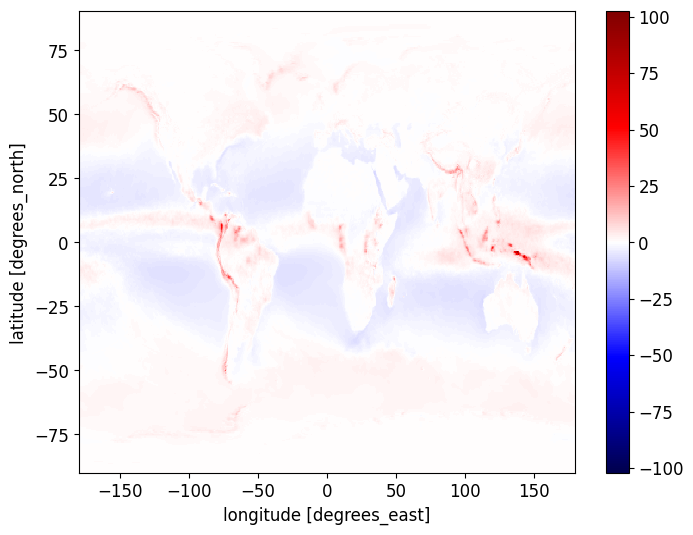

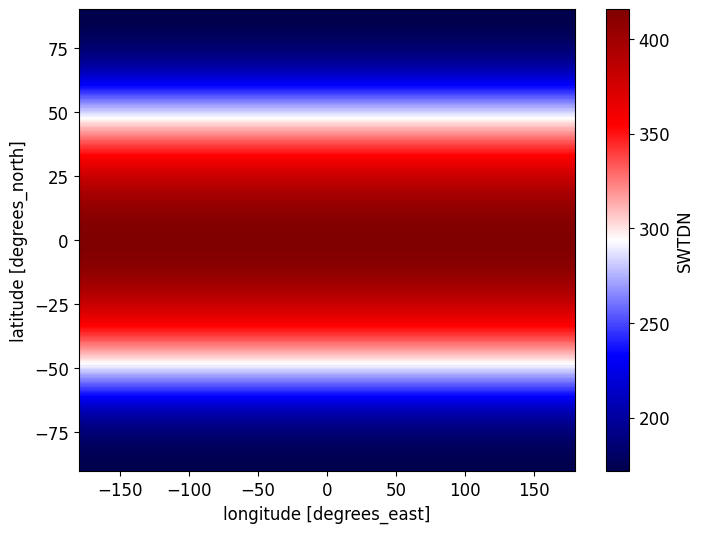

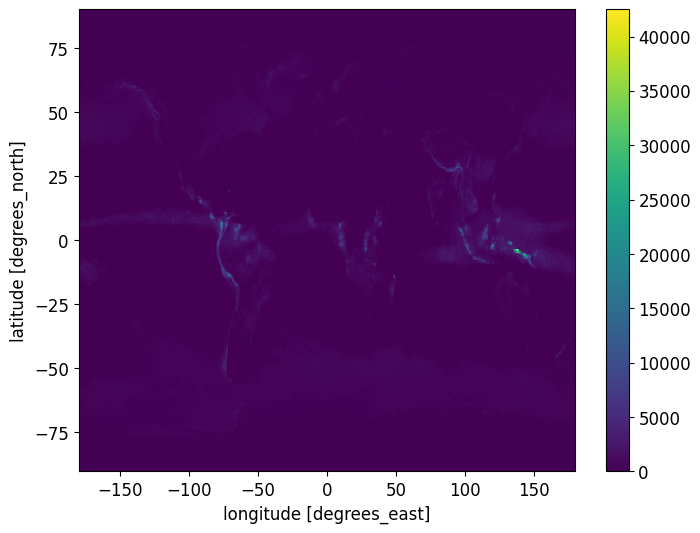

In [7]:
## Load MERRA observational data
### Moisture convergence
merrafn = xr.open_mfdataset('/glade/derecho/scratch/geethma/merra2/EFLUX/*.nc4', 
                            combine='by_coords', parallel=True)
monthly_merrafn = merrafn.mean(dim='time')
merraMC = (monthly_merrafn['PRECTOT'] - monthly_merrafn['EFLUX']/Lv)*86400
plt.figure(); merraMC.plot(cmap='seismic')

### TOA SW downwelling
merrafn = xr.open_mfdataset('/glade/derecho/scratch/geethma/merra2/in_solar/*.nc4', 
                            combine='by_coords', parallel=True)  # SW_TOA
monthly_merrafn = merrafn.mean(dim='time')
merraSW = monthly_merrafn['SWTDN']
if ocean:
    from get_land_mask import get_land_mask
    land_mask = get_land_mask(merraMC['lat'], merraMC['lon'])[0]
    merraMC *= land_mask
    merraSW *= land_mask
plt.figure(); merraSW.plot(cmap='seismic')

# Observational constraint on convergence area
merra_conv_area = xr.where(merraMC > 0, 1, 0)
merra_conv_sw = merra_conv_area*merraSW*merraMC
plt.figure(); merra_conv_sw.plot()
merraMC_mean, merraMC_sem, _ = lat_weight_mean(merra_conv_sw)
print(merraMC_mean.values)
obs_constraint_lower = merraMC_mean.values - merraMC_sem.values
obs_constraint_upper = merraMC_mean.values + merraMC_sem.values

# Identify constrained points
PPE_conv_SWD = final_data['filter2']
constrained = (PPE_conv_SWD.values >= obs_constraint_lower) & (PPE_conv_SWD.values <= obs_constraint_upper)


In [8]:
## Constrained Pe
from cyclone_obs import *
from cyclone_metrics import *
PPE_grad_LWP_WCB, PPE_grad_LWP_PRC = cyclone_metrics()
obs_dict = cyclone_obs()
PPE_grad_LWP_WCB = PPE_grad_LWP_WCB.sel(runs=common_members)

In [9]:
cloudlwp = obs_dict['cloudlwp']*0.001  #[kg/m2]
wcb = obs_dict['sfcwind']*obs_dict['wvp']*2.66e-7*86400  #[m/s * kg/m2 * m.mm/kg * s/day = mm/day]
num_bins = 10
ind = ~np.isnan(wcb * cloudlwp)

# Calculate bins and statistics in one go
bin_stats = stats.binned_statistic(wcb[ind], [cloudlwp[ind], wcb[ind]], statistic='mean', bins=num_bins)
lwp_bin, wcb_bin = bin_stats.statistic
count = stats.binned_statistic(wcb[ind], wcb[ind], statistic='count', bins=num_bins).statistic
obs_grad = np.nansum(np.gradient(lwp_bin)/np.gradient(wcb_bin)*count)/np.nansum(count)

obs_grad_LWP_WCB = obs_grad.copy()

lower_bound_WCB = obs_grad_LWP_WCB - 0.1 * obs_grad_LWP_WCB
upper_bound_WCB = obs_grad_LWP_WCB + 0.1 * obs_grad_LWP_WCB

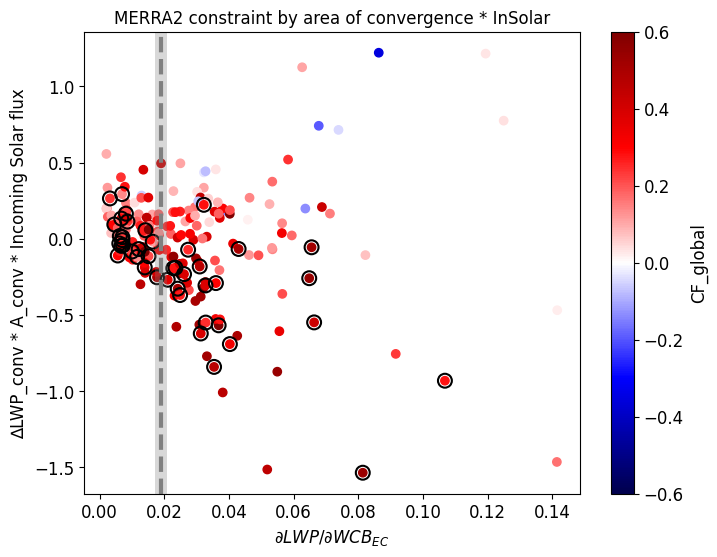

In [10]:
#### Pe - ∆LWP_conv*A_conv - total global CF
#### MERRA2 constraint by area of convergence * SWD
x_p = PPE_grad_LWP_WCB
y_p = final_data['ymap']
c_p = final_data['clrmap']
plt.scatter(x_p, y_p, c=c_p, cmap='seismic',
           vmin=-0.6, vmax=0.6)
plt.colorbar(label='CF_global')
plt.scatter(x_p.sel(runs=constrained), y_p.sel(runs=constrained), 
            edgecolor='black', facecolor='none', s=100, linewidth=1.5, label='Obs Constrained')
plt.axvline(x=obs_grad_LWP_WCB, color='grey', linestyle='--')
plt.axvspan(lower_bound_WCB, upper_bound_WCB, facecolor='grey', alpha=0.3)
plt.xlabel('$∂LWP/∂WCB_{EC}$')
plt.ylabel('∆LWP_conv * A_conv * Incoming Solar flux')
# plt.savefig('figures/∆LWP_Aconv_solarVS∂LWP∂WCBVSCF.png', bbox_inches='tight', dpi=500, facecolor='white')
plt.title('MERRA2 constraint by area of convergence * InSolar')
plt.show()

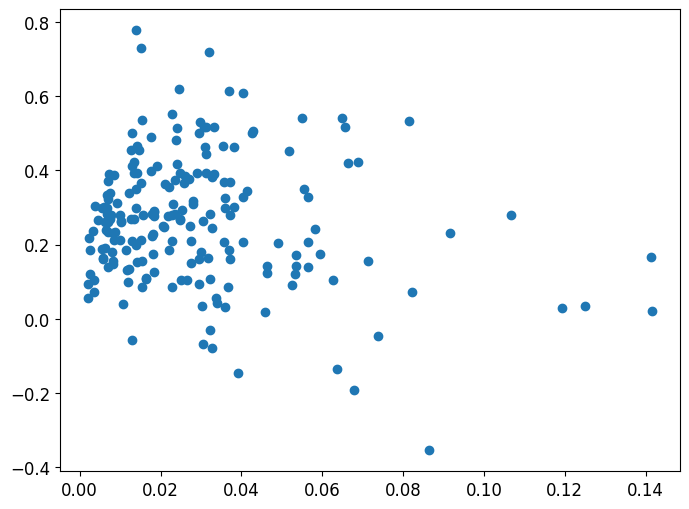

In [11]:
plt.scatter(x_p, c_p)

# one suggestion using the predictors

Training Gaussian Process model...
Model training complete.
Predicting for 1 million samples...
Mean predicted ∆CRE: 0.211
Std dev of predicted ∆CRE: 0.177


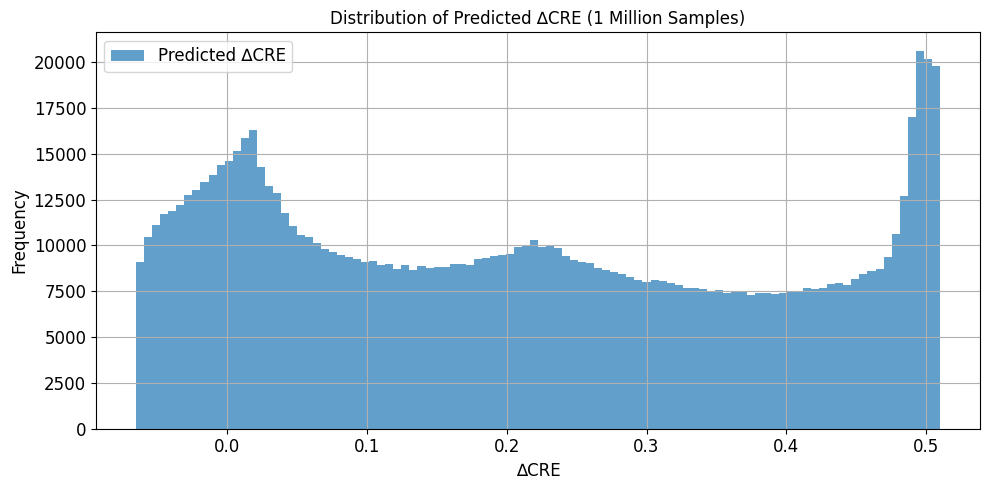

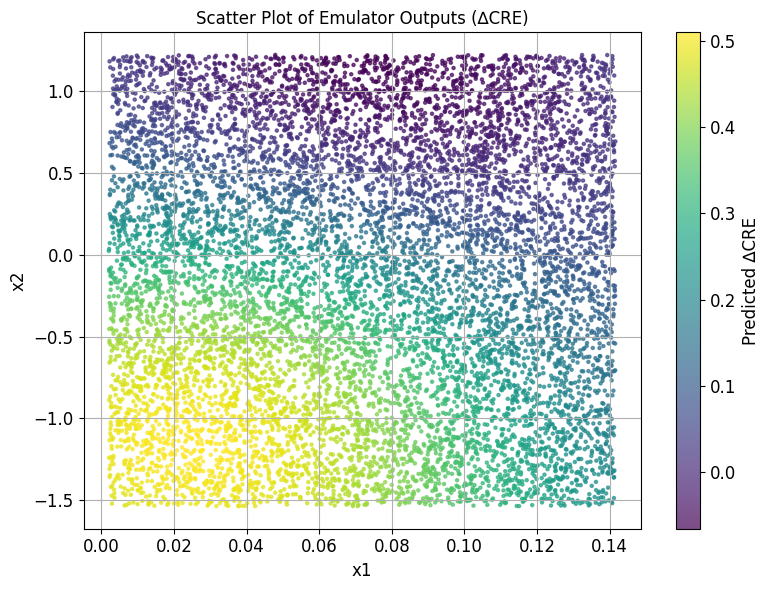

In [47]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load PPE data
# -----------------------------

ind = np.isnan(x_p*y_p*c_p)==False
X = np.array([x_p.data[ind], y_p.data[ind]])
X = X.T
y = c_p.data[ind]

# -----------------------------
# 2. Preprocess inputs
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# 3. Train GPR emulator
# -----------------------------
kernel = RBF(length_scale=1.0) + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True)

print("Training Gaussian Process model...")
gpr.fit(X_scaled, y)
print("Model training complete.")

# -----------------------------
# 4. Generate 1 million new X samples
# -----------------------------
n_samples = 1_000_000

# Sample uniformly within the observed input range
x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
x2_min, x2_max = X[:, 1].min(), X[:, 1].max()

x1_samples = np.random.uniform(x1_min, x1_max, n_samples)
x2_samples = np.random.uniform(x2_min, x2_max, n_samples)

X_new = np.column_stack((x1_samples, x2_samples))  # Shape: (1_000_000, 2)

# -----------------------------
# 5. Predict ∆CRE for new samples
# -----------------------------
X_new_scaled = scaler.transform(X_new)
print("Predicting for 1 million samples...")
y_new_pred, y_new_std = gpr.predict(X_new_scaled, return_std=True)

# -----------------------------
# 6. Analyze and Save Results
# -----------------------------
print(f"Mean predicted ∆CRE: {np.mean(y_new_pred):.3f}")
print(f"Std dev of predicted ∆CRE: {np.std(y_new_pred):.3f}")

# Save predictions
# np.save('y_pred_1M.npy', y_new_pred)
# np.save('y_std_1M.npy', y_new_std)

# Optional: Plot histogram of predictions
plt.figure(figsize=(10, 5))
plt.hist(y_new_pred, bins=100, alpha=0.7, label='Predicted ∆CRE')
plt.xlabel("∆CRE")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted ∆CRE (1 Million Samples)")
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig("delta_cre_histogram.png", dpi=300)
plt.show()

# -----------------------------
# 7. Scatterplot of emulator outputs
# -----------------------------
# Subsample for plotting
n_plot = 10_000
idx = np.random.choice(np.arange(n_samples), size=n_plot, replace=False)

x1_plot = x1_samples[idx]
x2_plot = x2_samples[idx]
y_plot = y_new_pred[idx]

plt.figure(figsize=(8, 6))
sc = plt.scatter(x1_plot, x2_plot, c=y_plot, cmap='viridis', s=5, alpha=0.7)
plt.colorbar(sc, label='Predicted ∆CRE')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Scatter Plot of Emulator Outputs (∆CRE)")
plt.grid(True)
plt.tight_layout()
# plt.savefig("emulator_scatter_plot.png", dpi=300)
plt.show()


# train_gpr_model(X, y)

In [ ]:
'''Trains a GPR model with a standard kernel on 2D input.'''

In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler

def train_gpr_model(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kernel = RBF(length_scale=1.0) + WhiteKernel()
    gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gpr.fit(X_scaled, y)

    return gpr, scaler


# predict_with_gpr(model, scaler, X_new)

In [ ]:
'''Predicts c_p for new inputs (obs-based values).'''

In [24]:
def predict_with_gpr(model, scaler, X_new):
    X_new_scaled = scaler.transform(X_new)
    y_pred, y_std = model.predict(X_new_scaled, return_std=True)
    return y_pred, y_std


# Plot

In [51]:
# Load data
ind = np.isnan(x_p*y_p*c_p)==False
X = np.array([x_p.data[ind], y_p.data[ind]])
X = X.T
y = c_p.data[ind]

# Train model
model, scaler = train_gpr_model(X, y)

# Predict for idealized inputs (obs values)
X_obs = np.array([[obs_grad_LWP_WCB, y_p.sel(runs=constrained)[0]]])
y_pred, y_std = predict_with_gpr(model, scaler, X_obs)

print("Predicted ∆CRE:", y_pred[0])
print("Prediction uncertainty (std):", y_std[0])


Predicted ∆CRE: 0.27532912878703236
Prediction uncertainty (std): 0.13648259195512974


In [53]:
plot_results(X, y, model, scaler)

NameError: name 'plot_results' is not defined

In [54]:
model

GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         normalize_y=True)

# Jacqueline's code

# Gaussian process regression for confidence intervals
Get 90% and 95% confidence intervals for ERFaci and dln(LWP) for each PPE *and* for the combined multi-PPE estimate.

See docstrings in `ppe_gpr.py` for more details on methodology here.

In [12]:
import pickle

import ppe_gpr as pg
import matplotlib.pyplot as plt
import tol_colors as tc

from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import kernels
from sklearn.gaussian_process import kernels,GaussianProcessRegressor
import statsmodels.api as sm

In [17]:
# main_path = "/glade/u/home/jnug/work/multi_PPE_data/"
# file_path = main_path + "annual_ocean_means/"
# pickle_path = main_path + "pickle_jar/"
# out_path = pickle_path + "GP_regression/"

# ppe_list = ["E3SMv3", "GA7.1", "CAM6", "ECHAM6-HAM"]


In [13]:
# random seed for reproducibility
SEED = 20250321

def split_train_test(x, y, z, test_split=0.2, seed=SEED):
    """ 
    Split input multi/single PPE data into training & testing arrays 
    for target variable var (ERFaci or dlnLWP).
    """
    # lwp, lnlwp, dlwp, dlnlwp, dadlwp, dlwp_dadlwp, dnd, erfaci = data

    # get indices for training & testing data
    n_test = int(np.round(len(x)*test_split))
    pct_test = n_test/len(x)
    member_inds = np.arange(len(x))
    np.random.seed(seed)
    ind = np.random.choice(member_inds, replace=False, size=n_test)
    indtest = np.in1d(member_inds, ind)
    indtrain = indtest==False

    # ERFaci = GP(dlnlwp, da/dlwp, dnd)
    # (note: worse with PD LWP vs. dlnlwp; ~same with dlnlwp*da/dlwp vs. da/dlwp)
    # if var == "ERFaci": 
    #     dnd_train = dnd[indtrain]
    #     dlnlwp_train = dlnlwp[indtrain]
    #     dadlwp_train = dadlwp[indtrain]
    #     erfaci_train = erfaci[indtrain]
    #     x_train = np.column_stack((dlnlwp_train, dadlwp_train, dnd_train))
    #     y_train = erfaci_train
        
    #     dnd_test = dnd[indtest]
    #     dlnlwp_test = dlnlwp[indtest]
    #     dadlwp_test = dadlwp[indtest]
    #     erfaci_test = erfaci[indtest]
    #     x_test = np.column_stack((dlnlwp_test, dadlwp_test, dnd_test))
    #     y_test = erfaci_test

    # # dlnLWP = GP(PD lnLWP, dnd)
    # else:
    xi_train = x[indtrain]
    yi_train = y[indtrain]
    # z_train = z[indtrain]
    x_train = np.column_stack((xi_train, yi_train))
    y_train = z[indtrain]
    
    xi_test = x[indtest]
    yi_test = y[indtest]
    # dlnlwp_test = dlnlwp[indtest]
    x_test = np.column_stack((xi_test, yi_test))
    y_test = z[indtest]

    training = [x_train, y_train]
    testing = [x_test, y_test]
    
    return training, testing

In [18]:
def find_good_kernel(var, training, testing, elims=[-3.25, 1], dlims=[-0.01, 0.15],
                    kernels_list=None, pos_slope_only=False, seed=SEED):
    """ 
    Loop through a list of kernels and show the validity plot
    to pick which one is most effective for variable var. 
    If pos_slope_only=True, will only plot kernels where predicted vs. actual
    linear fit has slope > 0. 
    """
    base_kernels = [
        kernels.RBF(),
        kernels.RationalQuadratic(),
        kernels.Matern(),
        kernels.ConstantKernel(),
        kernels.ExpSineSquared(),
    ]

    # pick a structure based on expected relationships between the inputs & outputs
    if kernels_list is None:
        # if var == "ERFaci": 
        #     kernels_list = [kernels.ConstantKernel() + kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x)+ kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + kernels.WhiteKernel() for x in base_kernels]
        # else:
        kernels_list = [kernels.ConstantKernel() + kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + kernels.WhiteKernel() for x in base_kernels]

    for kernel in kernels_list:
        print(kernel)
        train_test_gp(kernel, training, testing, var, show_plot=True, seed=seed,
                     elims=elims, dlims=dlims, plot_pos_slope_only=pos_slope_only)
        print("========================")

In [14]:
def train_test_gp(kernel, training, testing, var, return_model=False,
                  elims=[-3.25, 1], dlims=[-0.01, 0.15], show_plot=True, seed=SEED,
                  plot_pos_slope_only=False, copy_X_train=False):
    """ 
    Train/test a GP model with a given kernel, then (if desired) plot
    predicted vs. actual values to evaluate its validity.
    Input "var" is "ERFaci" for ERFaci or "dlnlwp" for dln(LWP).
    """
    x_train, y_train = training
    x_test, y_test = testing
    
    # fit & predict
    gp = GaussianProcessRegressor(kernel, alpha=1e-10,
                                 n_restarts_optimizer=10, normalize_y=False,
                                 random_state=seed, copy_X_train=copy_X_train)
    gp.fit(x_train, y_train)
    pred_test, sd_test = gp.predict(x_test, return_std=True)
    lml = gp.log_marginal_likelihood(gp.kernel_.theta)
    rmse = sm.tools.eval_measures.rmse(y_test, pred_test)

    # linear reg to see how close to 1-1
    X = sm.add_constant(y_test)
    model = sm.OLS(pred_test, X)
    results = model.fit()
    
    # Plot
    if show_plot:
        lims11 = [2*x for x in elims]
        lims11[1] = np.abs(lims11[1])
        if plot_pos_slope_only:
            if results.params[1] > 0:
            # # temp: add a few others to cut down 
            # if results.params[1] > 0 and lml > 137.1:
                plt.scatter(y_test, pred_test)
                plt.errorbar(y_test, pred_test, yerr=np.abs(pred_test-y_test), fmt="o", capsize=5)
                # if var == "ERFaci": 
                #     plt.plot(lims11, lims11, color="k", label="1:1", zorder=0, lw=1)
                #     plt.xlim(elims)
                #     plt.ylim(elims)
                # else:
                plt.plot(lims11, lims11, color="k", label="1:1", zorder=0, lw=1)
                plt.xlim(dlims)
                plt.ylim(dlims)
                plt.legend()
                plt.title(f"Log marginal likelihood: {lml:.2f}, RMSE: {rmse:.3f}" + "\n" + f"r$^2$: {results.rsquared:.3f}, slope: {results.params[1]:.3f}")
                plt.xlabel(var)
                plt.ylabel("Prediction")
                plt.show()
        else:
            plt.scatter(y_test, pred_test)
            plt.errorbar(y_test, pred_test, yerr=np.abs(pred_test-y_test), fmt="o", capsize=5)
            # if var == "ERFaci": 
            #     plt.plot(lims11, lims11, color="k", label="1:1", zorder=0, lw=1)
            #     plt.xlim(elims)
            #     plt.ylim(elims)
            # else:
            plt.plot(lims11, lims11, color="k", label="1:1", zorder=0, lw=1)
            plt.xlim(dlims)
            plt.ylim(dlims)
            plt.legend()
            plt.title(f"Log marginal likelihood: {lml:.2f}, RMSE: {rmse:.3f}" + "\n" + f"r$^2$: {results.rsquared:.3f}, slope: {results.params[1]:.3f}")
            plt.xlabel(var)
            plt.ylabel("Prediction")
            plt.show()
        

    if return_model:
        return gp


### Choose kernels for individual PPEs


In [16]:
# ds_dict = pg.get_ppe_ds_dict(file_path, pickle_path)

def find_kernel_single_PPE(var, x, y, z, elims, dlims, kernels_list=None, test_split=0.2,
                          pos_slope_only=False, seed=pg.SEED):
    # ds = ds_dict[ppe]
    # data = pg.get_ppe_data(ds, ppe)
    training, testing = split_train_test(x, y, z, test_split=test_split, seed=seed)
    find_good_kernel(var, training, testing, elims=elims, dlims=dlims,
                     kernels_list=kernels_list, pos_slope_only=pos_slope_only,
                     seed=seed)
    

In [43]:
base_kernels = [
    kernels.RBF(),
    kernels.RationalQuadratic(),
    kernels.Matern(),
    kernels.ConstantKernel(),
    kernels.ExpSineSquared(),
]


In [ ]:
kernels=['Linear','Bias','White','Exponential','RBF','Polynomial','Matern12']
# kernels=['Linear','Bias','White','Exponential']

#### ∆CRE

In [22]:
ind = np.isnan(x_p*y_p*c_p)==False
x_p = x_p[ind]
y_p = y_p[ind]
c_p = c_p[ind]


###### commented

In [5]:
# data = pg.get_ppe_data(pg.get_ppe_ds_dict(file_path, pickle_path)["E3SMv3"], "E3SMv3")
# lwp, lnlwp, dlwp, dlnlwp, dadlwp, dlwp_dadlwp, dnd, erfaci = data


In [26]:
# # new, based on E3SMv3 scatter plots
# dkernels_1 = [kernels.ConstantKernel() + \
#               kernels.ConstantKernel()*x + \
#               kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + \
#               kernels.WhiteKernel() for x in base_kernels]

# # old, based on multi-PPE scatter plots 
# dkernels_2 = [kernels.ConstantKernel() + \
#               kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + \
#               kernels.WhiteKernel() for x in base_kernels]

# # new but with two variables
# dkernels_3 = [kernels.ConstantKernel() + \
#               kernels.ConstantKernel()*x + \
#               kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), y) + \
#               kernels.WhiteKernel() for x in base_kernels for y in base_kernels]

# kernels_list = dkernels_1 + dkernels_3

In [27]:
# new, based on CAM6 scatter plots
dkernels_1 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*x + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), y) + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels]

# old, based on multi-PPE scatter plots 
dkernels_2 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), y) + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels]

# simpler?
dkernels_3 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*x + \
              kernels.ConstantKernel()*y + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels]
dkernels_4 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*kernels.Product(y, x) + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels]

kernels_list = dkernels_3 + dkernels_4 #dkernels_1  + dkernels_2

# the best ones of set 3-4
test1 = kernels.ConstantKernel() + \
        kernels.ConstantKernel()*kernels.ExpSineSquared() + \
        kernels.ConstantKernel()*kernels.ExpSineSquared() + \
        kernels.WhiteKernel()
test2 = kernels.ConstantKernel() + \
        kernels.ConstantKernel()*kernels.ExpSineSquared() + \
        kernels.ConstantKernel()*kernels.RationalQuadratic() + \
        kernels.WhiteKernel()
test3 = kernels.ConstantKernel() + \
        kernels.ConstantKernel()*kernels.Product(kernels.ExpSineSquared(), kernels.ExpSineSquared()) +\
        kernels.WhiteKernel()

kernels_list = [test1, test2, test3]

In [28]:
kernels_list

[1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1),
 1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1),
 1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)]

###### gp

In [65]:
from sklearn.gaussian_process.kernels import (
    RBF, RationalQuadratic, Matern, ExpSineSquared, ConstantKernel,
    DotProduct, WhiteKernel
)

# Define a kernel list including the ones you asked for
base_kernels = [
    RBF(length_scale=1),                              # RBF
    RationalQuadratic(alpha=1, length_scale=1),       # RationalQuadratic
    Matern(length_scale=1, nu=0.5),                   # Matern12 ≈ Exponential
    Matern(length_scale=1, nu=1.5),                   # Matern32
    Matern(length_scale=1, nu=2.5),                   # Matern52
    ExpSineSquared(length_scale=1, periodicity=1),    # Periodic kernel
    ConstantKernel(1.0),                              # Bias / Constant kernel
    DotProduct(),                                     # Linear kernel
    WhiteKernel(noise_level=1.0),                     # White noise kernel
    # Polynomial kernel is not directly available in sklearn, but you can define one like:
    DotProduct(sigma_0=1.0) ** 2                      # Approximating a polynomial of degree 2
]


In [71]:
# import itertools
# from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, Matern, ExpSineSquared, ConstantKernel

# # Define your base kernels
# base_kernels = [
#     RBF(length_scale=1),
#     RationalQuadratic(alpha=1, length_scale=1),
#     Matern(length_scale=1, nu=1.5),
#     ConstantKernel(1.0),  # 1**2 is equivalent to ConstantKernel(1.0)
#     ExpSineSquared(length_scale=1, periodicity=1)
# ]

# Get all 3-combinations
out = itertools.combinations(base_kernels, 2)

# Sum each combination into a composite kernel
# kernel_list = [k1 + k2 + k3 for k1, k2, k3 in out]
kernel_list = [k1 + k2 + k1*k2 for k1, k2 in out]


RBF(length_scale=1) + RationalQuadratic(alpha=1, length_scale=1) + RBF(length_scale=1) * RationalQuadratic(alpha=1, length_scale=1)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


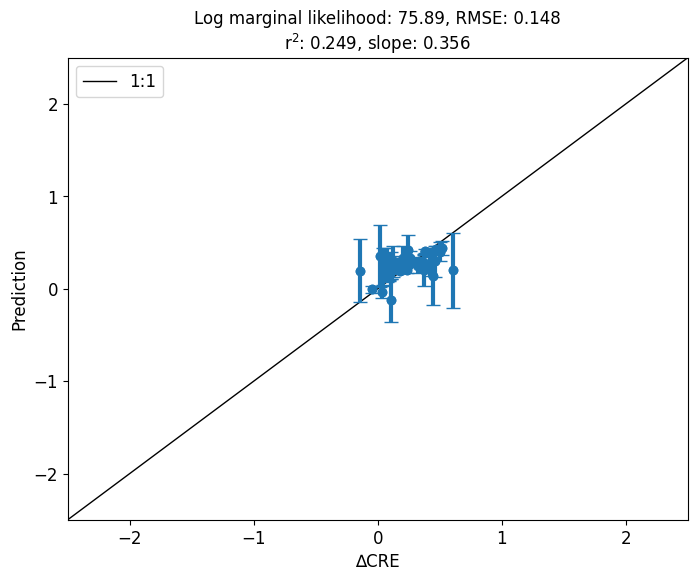

RBF(length_scale=1) + Matern(length_scale=1, nu=0.5) + RBF(length_scale=1) * Matern(length_scale=1, nu=0.5)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


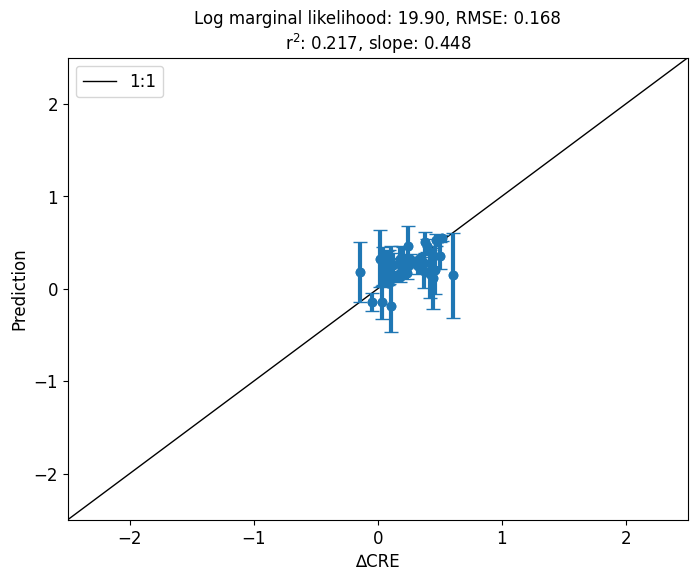

RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + RBF(length_scale=1) * Matern(length_scale=1, nu=1.5)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


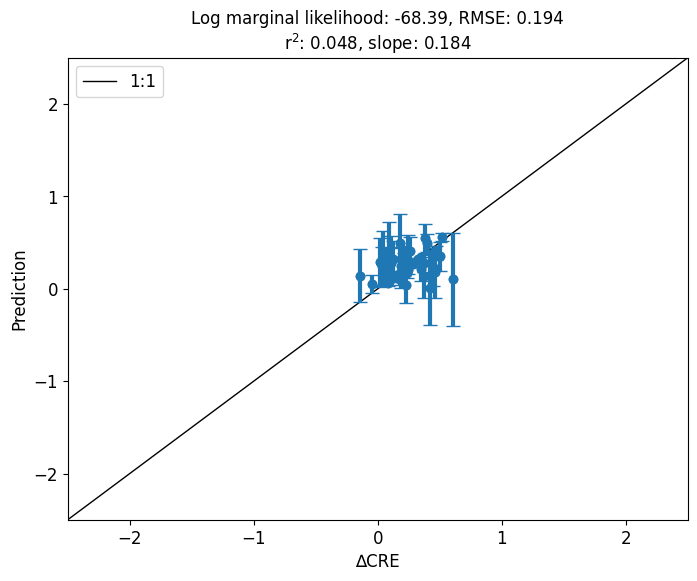

RBF(length_scale=1) + Matern(length_scale=1, nu=2.5) + RBF(length_scale=1) * Matern(length_scale=1, nu=2.5)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


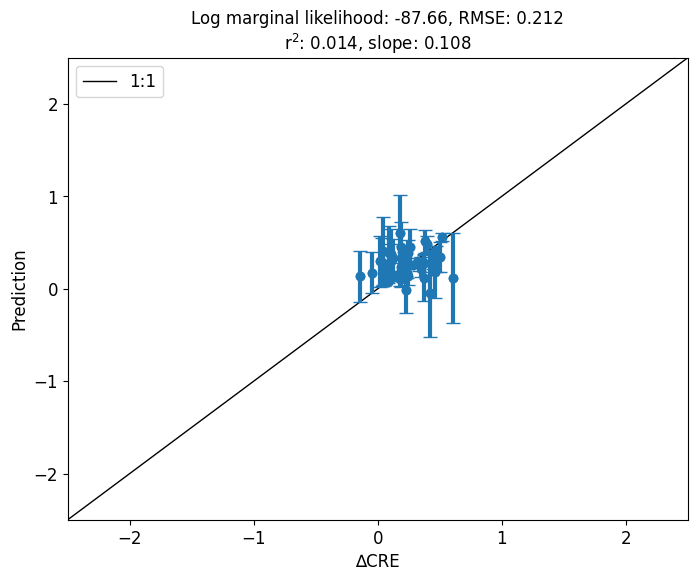

RBF(length_scale=1) + ExpSineSquared(length_scale=1, periodicity=1) + RBF(length_scale=1) * ExpSineSquared(length_scale=1, periodicity=1)


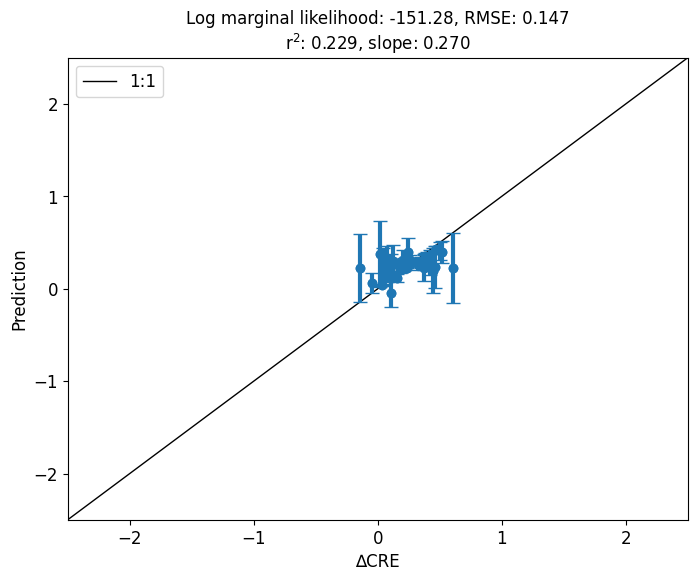

RBF(length_scale=1) + 1**2 + RBF(length_scale=1) * 1**2


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


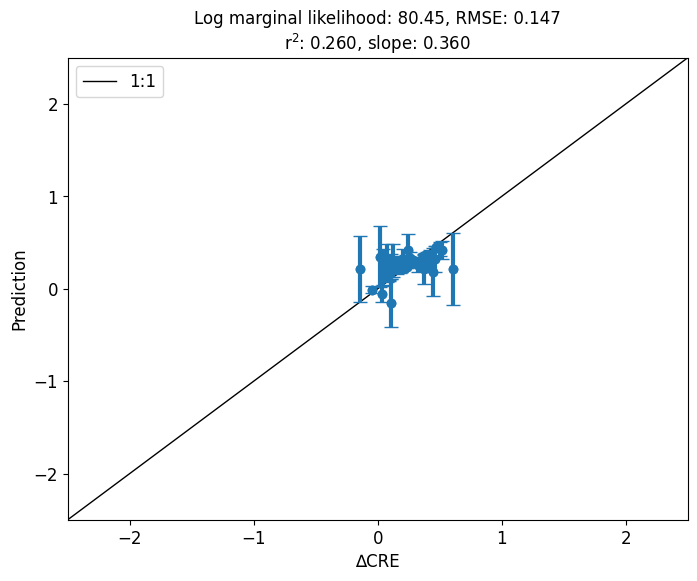

RBF(length_scale=1) + DotProduct(sigma_0=1) + RBF(length_scale=1) * DotProduct(sigma_0=1)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


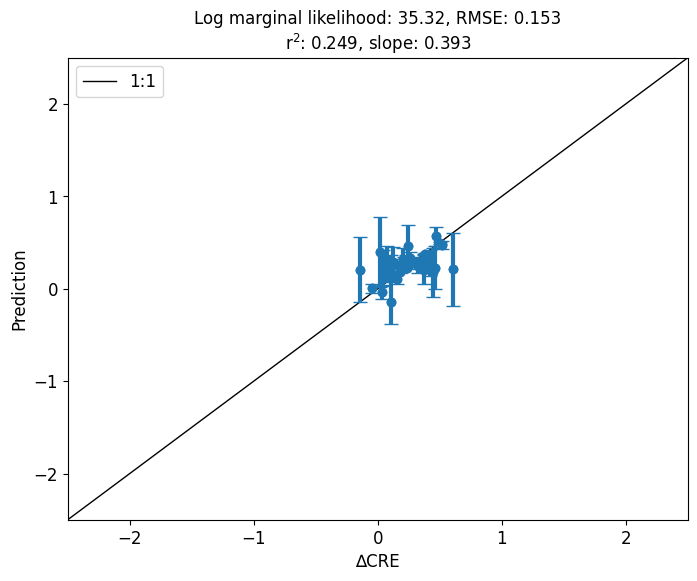

RBF(length_scale=1) + WhiteKernel(noise_level=1) + RBF(length_scale=1) * WhiteKernel(noise_level=1)


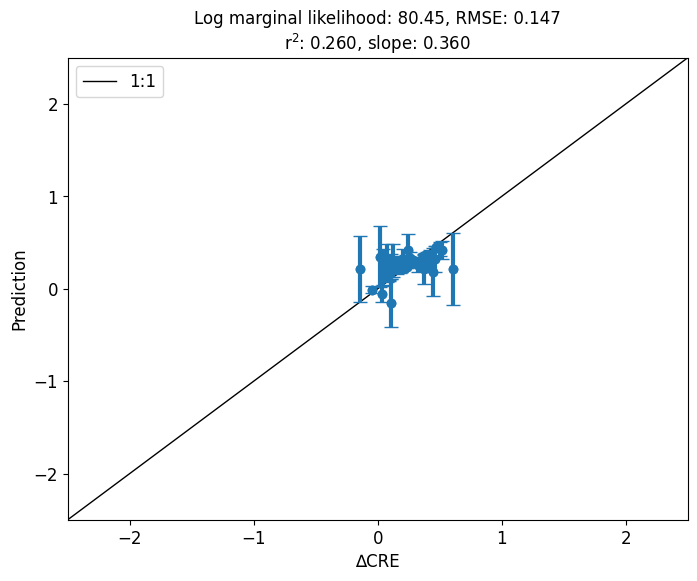

RBF(length_scale=1) + DotProduct(sigma_0=1) ** 2 + RBF(length_scale=1) * DotProduct(sigma_0=1) ** 2


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


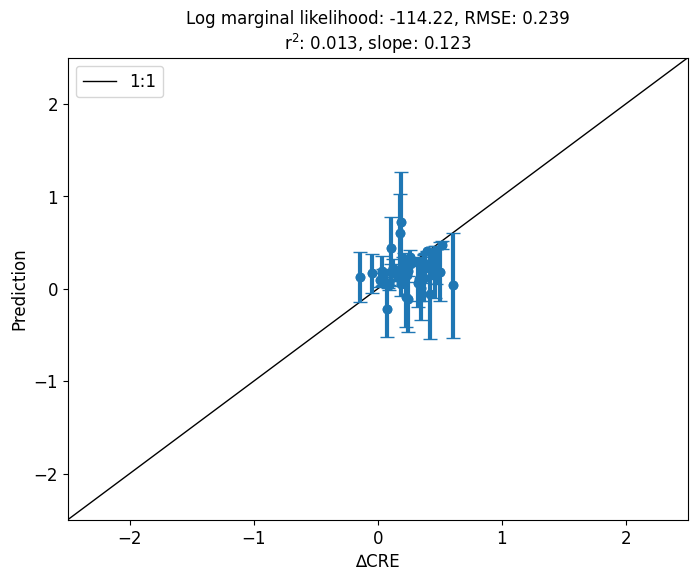

RationalQuadratic(alpha=1, length_scale=1) + Matern(length_scale=1, nu=0.5) + RationalQuadratic(alpha=1, length_scale=1) * Matern(length_scale=1, nu=0.5)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


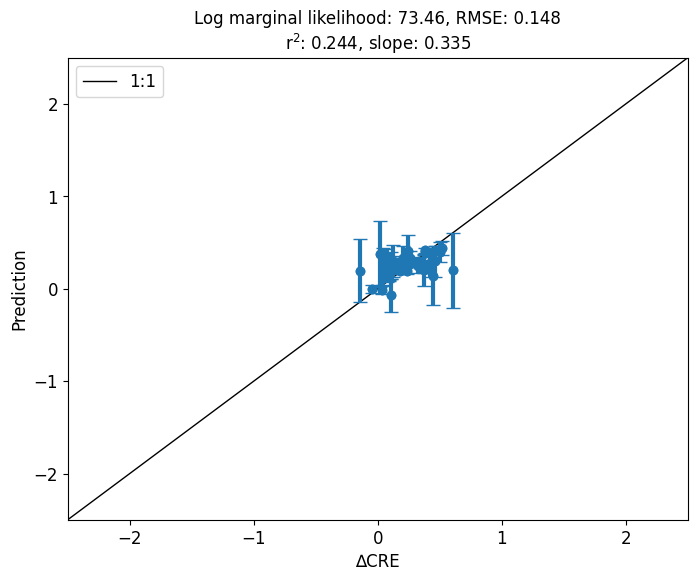

RationalQuadratic(alpha=1, length_scale=1) + Matern(length_scale=1, nu=1.5) + RationalQuadratic(alpha=1, length_scale=1) * Matern(length_scale=1, nu=1.5)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/py

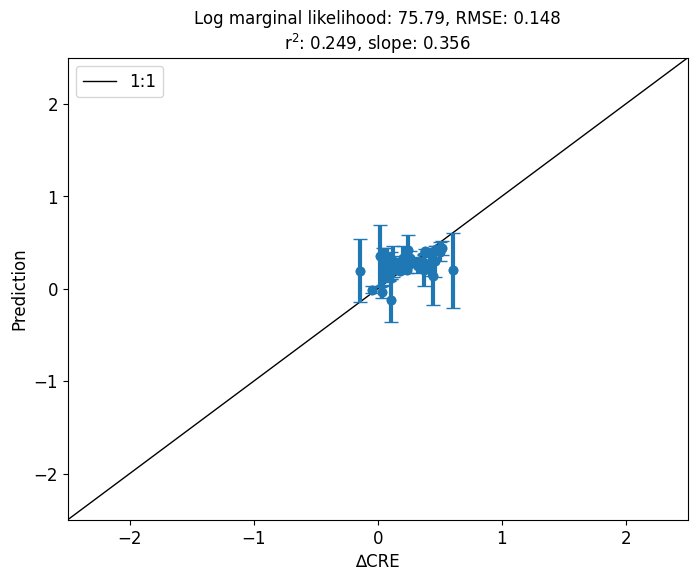

RationalQuadratic(alpha=1, length_scale=1) + Matern(length_scale=1, nu=2.5) + RationalQuadratic(alpha=1, length_scale=1) * Matern(length_scale=1, nu=2.5)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


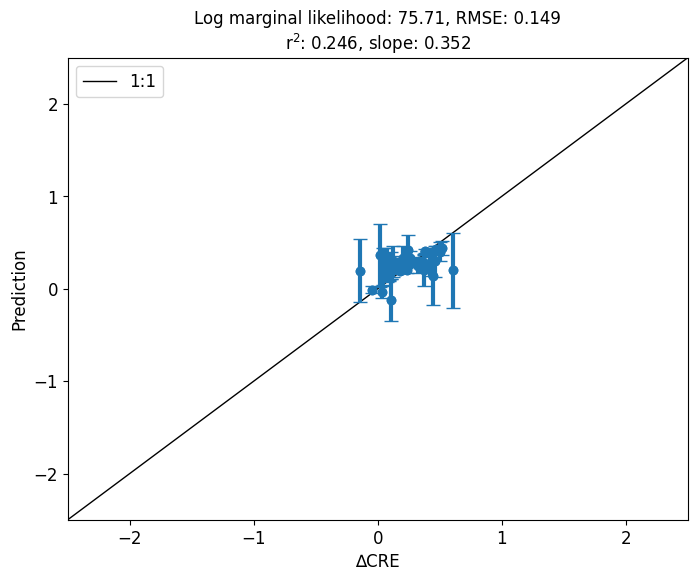

RationalQuadratic(alpha=1, length_scale=1) + ExpSineSquared(length_scale=1, periodicity=1) + RationalQuadratic(alpha=1, length_scale=1) * ExpSineSquared(length_scale=1, periodicity=1)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


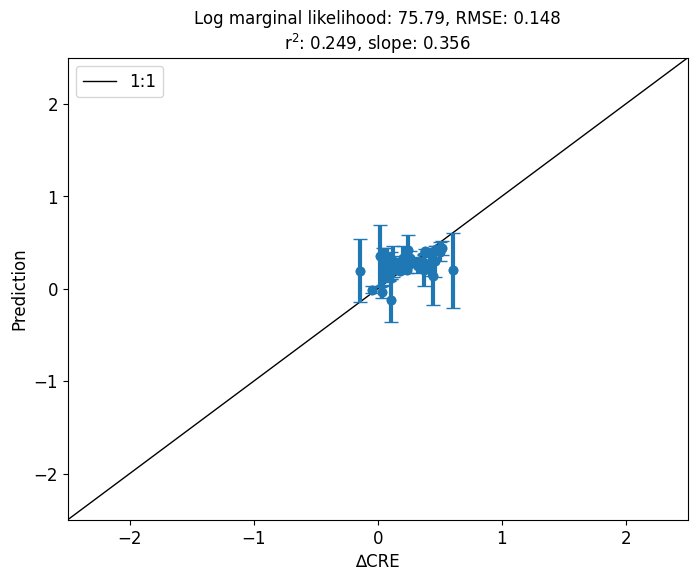

RationalQuadratic(alpha=1, length_scale=1) + 1**2 + RationalQuadratic(alpha=1, length_scale=1) * 1**2


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


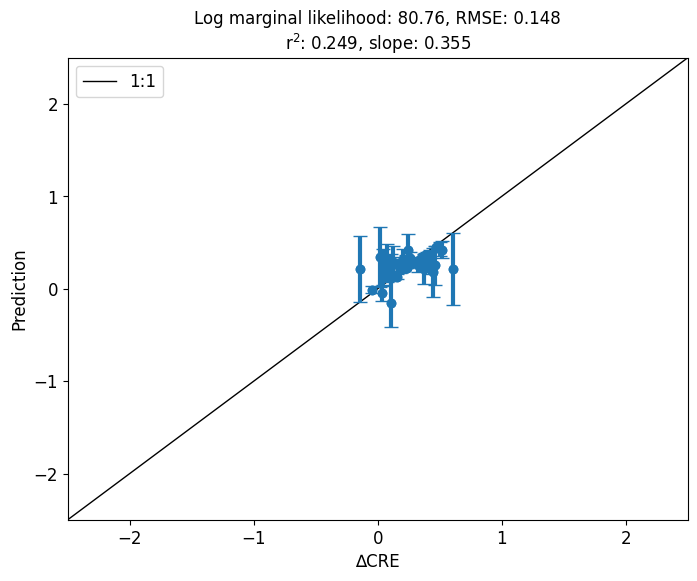

RationalQuadratic(alpha=1, length_scale=1) + DotProduct(sigma_0=1) + RationalQuadratic(alpha=1, length_scale=1) * DotProduct(sigma_0=1)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


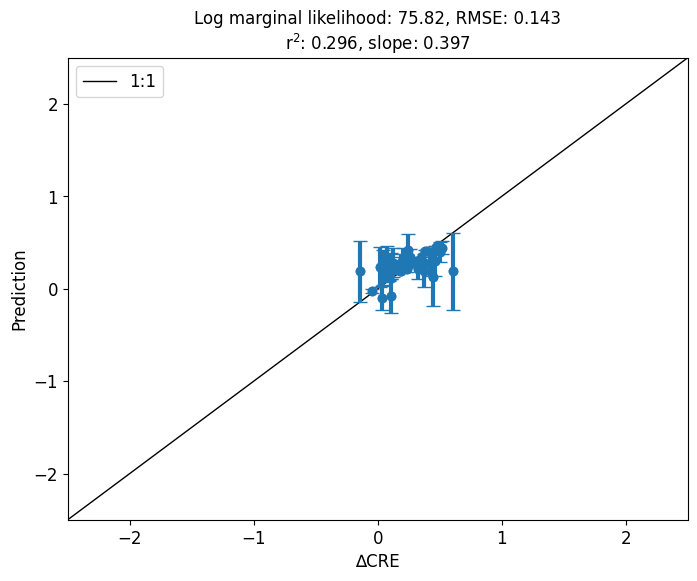

RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1) + RationalQuadratic(alpha=1, length_scale=1) * WhiteKernel(noise_level=1)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


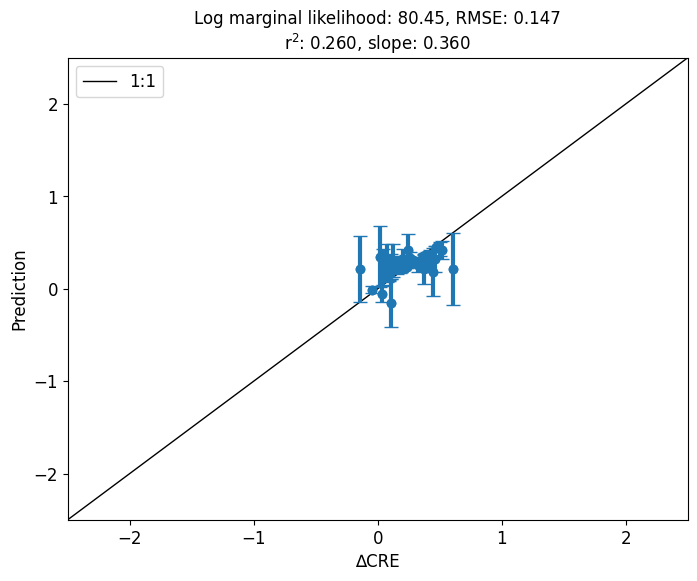

RationalQuadratic(alpha=1, length_scale=1) + DotProduct(sigma_0=1) ** 2 + RationalQuadratic(alpha=1, length_scale=1) * DotProduct(sigma_0=1) ** 2


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


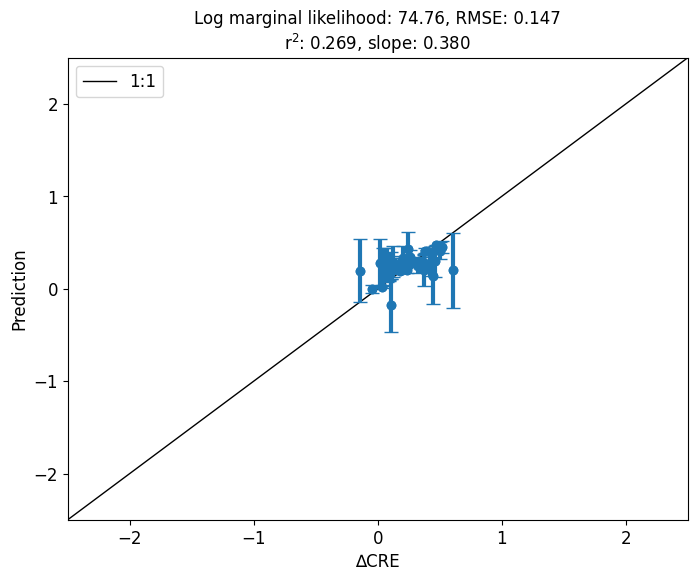

Matern(length_scale=1, nu=0.5) + Matern(length_scale=1, nu=1.5) + Matern(length_scale=1, nu=0.5) * Matern(length_scale=1, nu=1.5)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


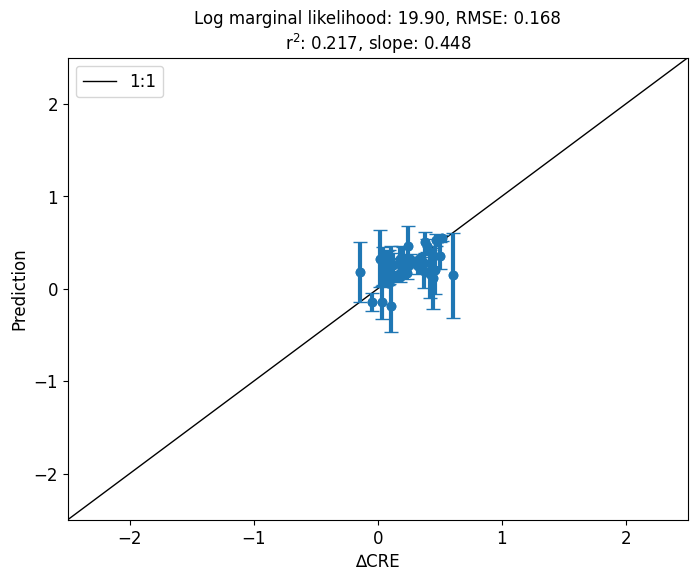

Matern(length_scale=1, nu=0.5) + Matern(length_scale=1, nu=2.5) + Matern(length_scale=1, nu=0.5) * Matern(length_scale=1, nu=2.5)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


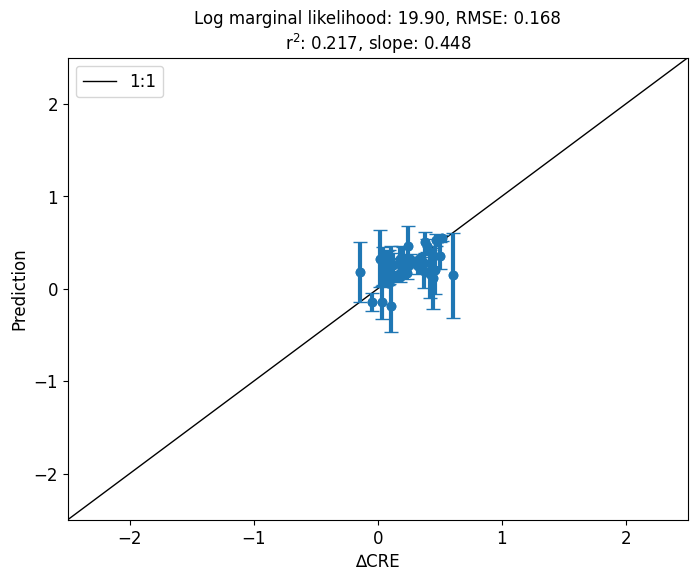

Matern(length_scale=1, nu=0.5) + ExpSineSquared(length_scale=1, periodicity=1) + Matern(length_scale=1, nu=0.5) * ExpSineSquared(length_scale=1, periodicity=1)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


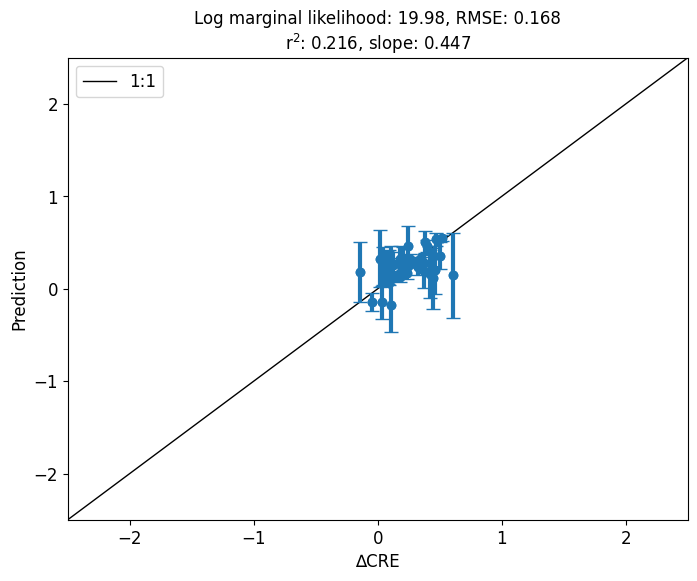

Matern(length_scale=1, nu=0.5) + 1**2 + Matern(length_scale=1, nu=0.5) * 1**2


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


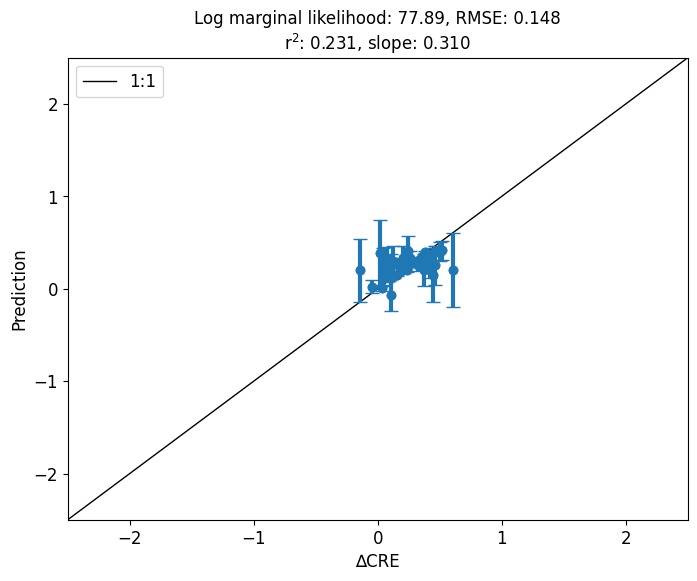

Matern(length_scale=1, nu=0.5) + DotProduct(sigma_0=1) + Matern(length_scale=1, nu=0.5) * DotProduct(sigma_0=1)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


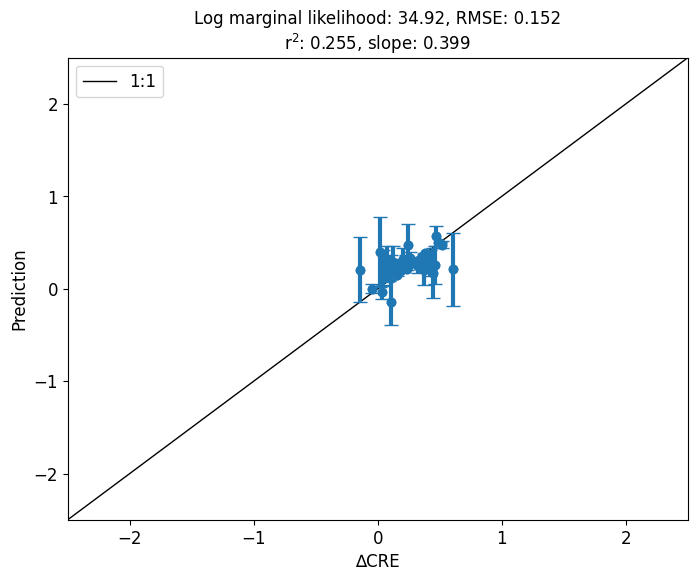

Matern(length_scale=1, nu=0.5) + WhiteKernel(noise_level=1) + Matern(length_scale=1, nu=0.5) * WhiteKernel(noise_level=1)


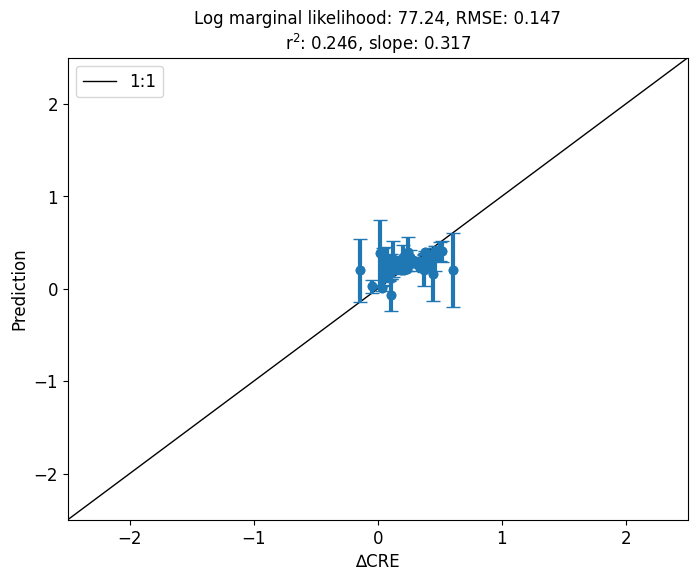

Matern(length_scale=1, nu=0.5) + DotProduct(sigma_0=1) ** 2 + Matern(length_scale=1, nu=0.5) * DotProduct(sigma_0=1) ** 2


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__kernel__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


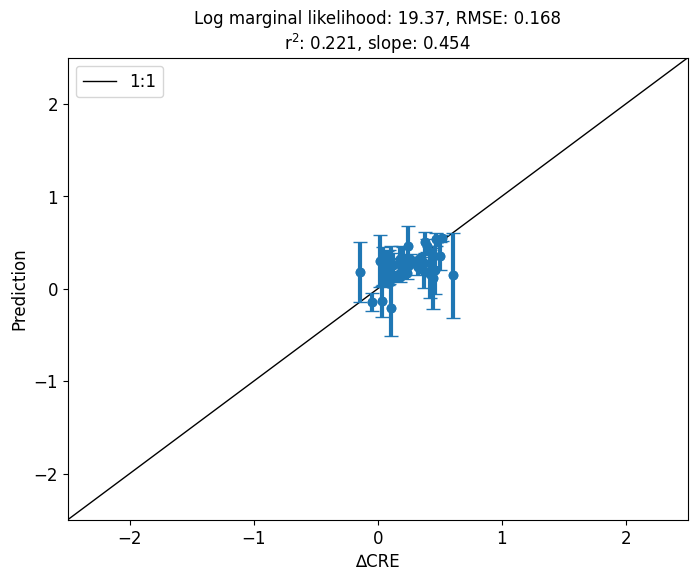

Matern(length_scale=1, nu=1.5) + Matern(length_scale=1, nu=2.5) + Matern(length_scale=1, nu=1.5) * Matern(length_scale=1, nu=2.5)


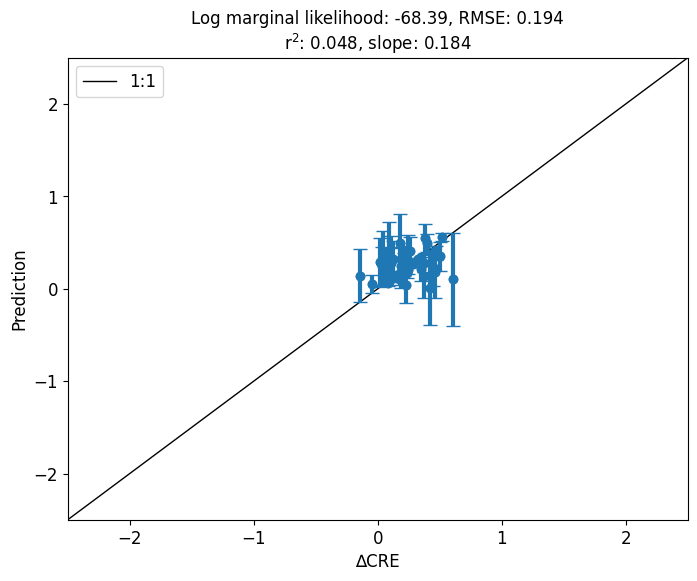

Matern(length_scale=1, nu=1.5) + ExpSineSquared(length_scale=1, periodicity=1) + Matern(length_scale=1, nu=1.5) * ExpSineSquared(length_scale=1, periodicity=1)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:428: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


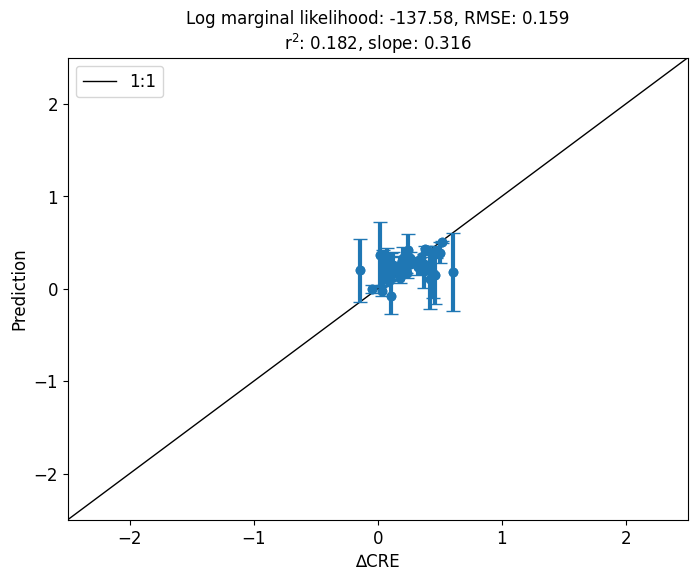

Matern(length_scale=1, nu=1.5) + 1**2 + Matern(length_scale=1, nu=1.5) * 1**2


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


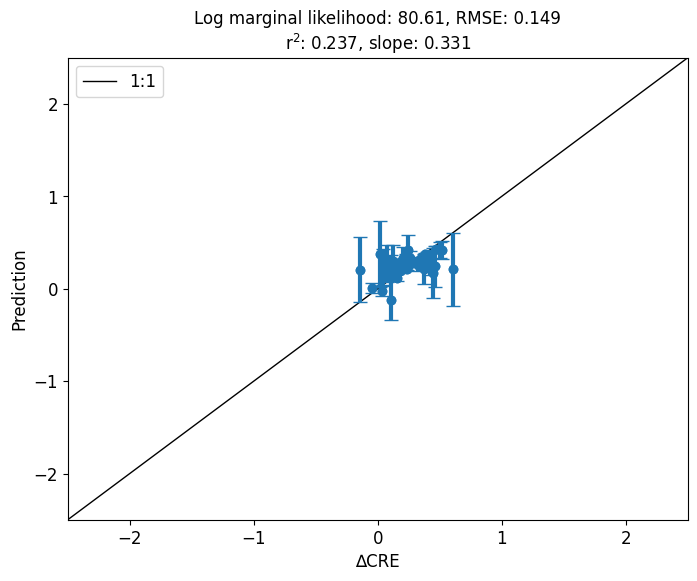

Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1) + Matern(length_scale=1, nu=1.5) * DotProduct(sigma_0=1)


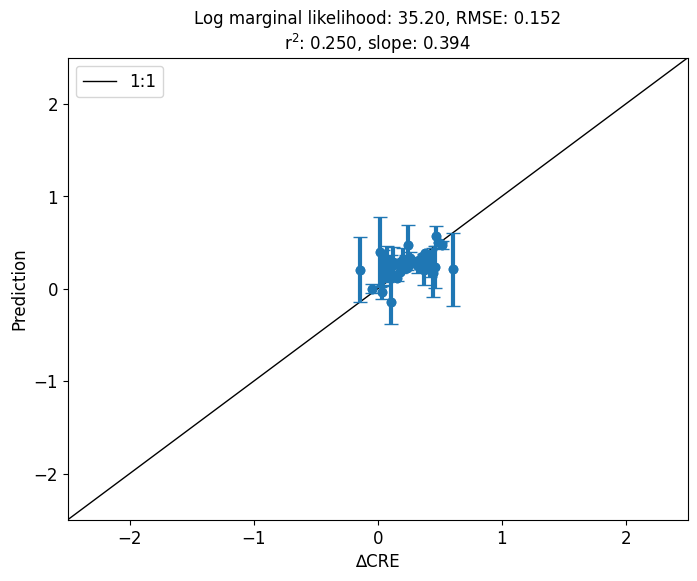

Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1) + Matern(length_scale=1, nu=1.5) * WhiteKernel(noise_level=1)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


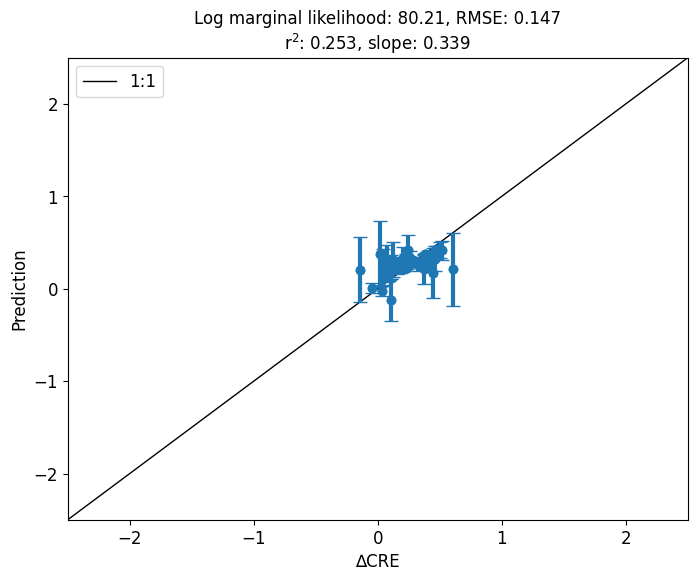

Matern(length_scale=1, nu=1.5) + DotProduct(sigma_0=1) ** 2 + Matern(length_scale=1, nu=1.5) * DotProduct(sigma_0=1) ** 2


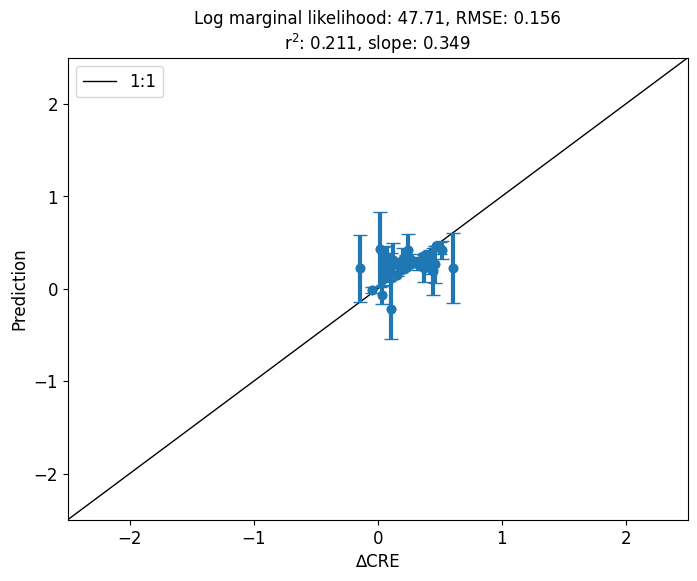

Matern(length_scale=1, nu=2.5) + ExpSineSquared(length_scale=1, periodicity=1) + Matern(length_scale=1, nu=2.5) * ExpSineSquared(length_scale=1, periodicity=1)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:428: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


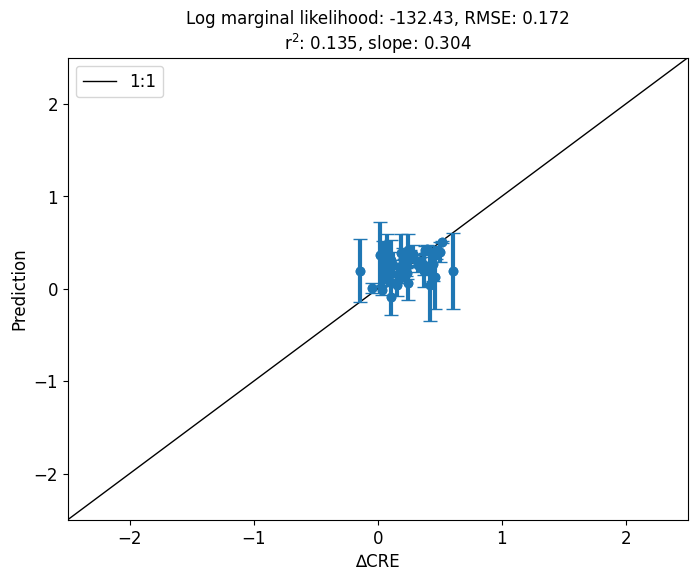

Matern(length_scale=1, nu=2.5) + 1**2 + Matern(length_scale=1, nu=2.5) * 1**2


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


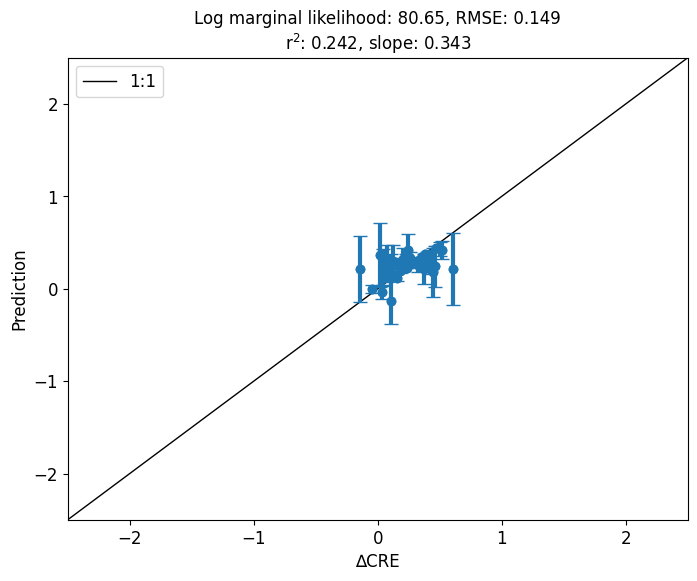

Matern(length_scale=1, nu=2.5) + DotProduct(sigma_0=1) + Matern(length_scale=1, nu=2.5) * DotProduct(sigma_0=1)


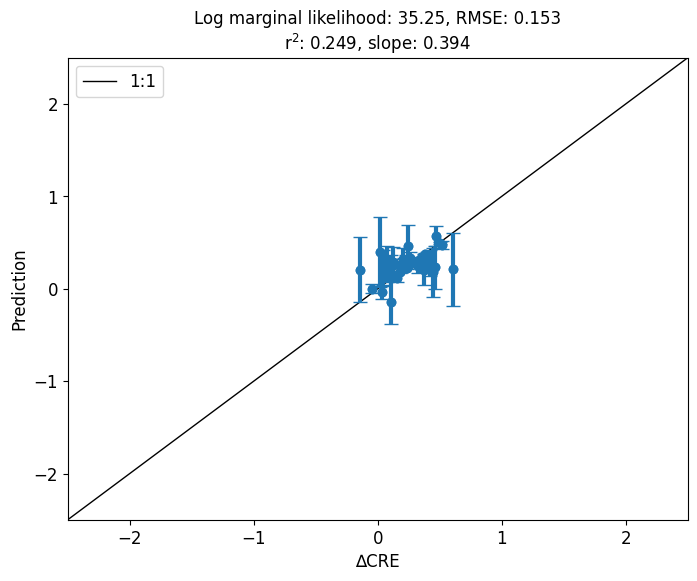

Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1) + Matern(length_scale=1, nu=2.5) * WhiteKernel(noise_level=1)


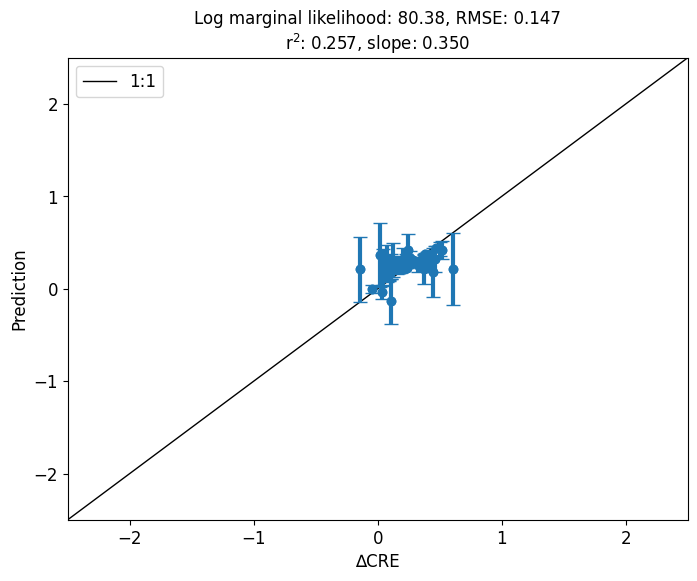

Matern(length_scale=1, nu=2.5) + DotProduct(sigma_0=1) ** 2 + Matern(length_scale=1, nu=2.5) * DotProduct(sigma_0=1) ** 2


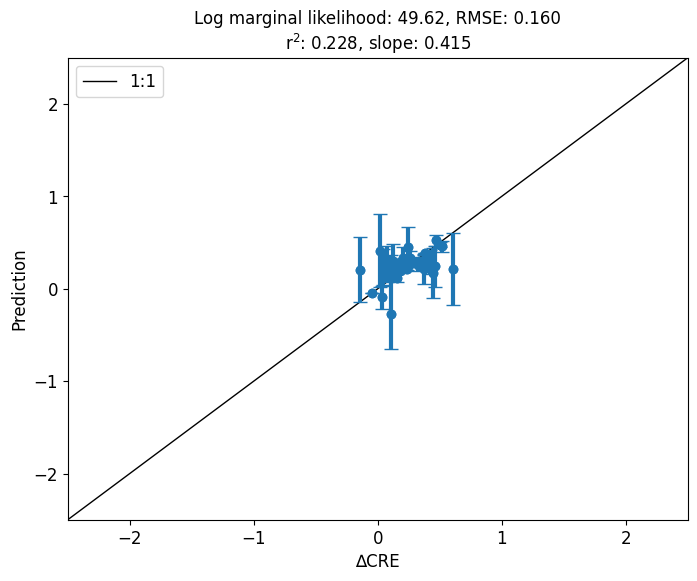

ExpSineSquared(length_scale=1, periodicity=1) + 1**2 + ExpSineSquared(length_scale=1, periodicity=1) * 1**2


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


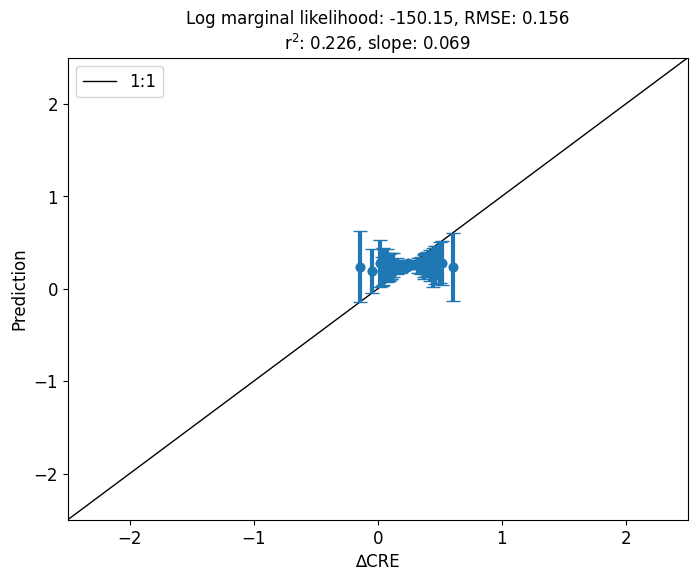

ExpSineSquared(length_scale=1, periodicity=1) + DotProduct(sigma_0=1) + ExpSineSquared(length_scale=1, periodicity=1) * DotProduct(sigma_0=1)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


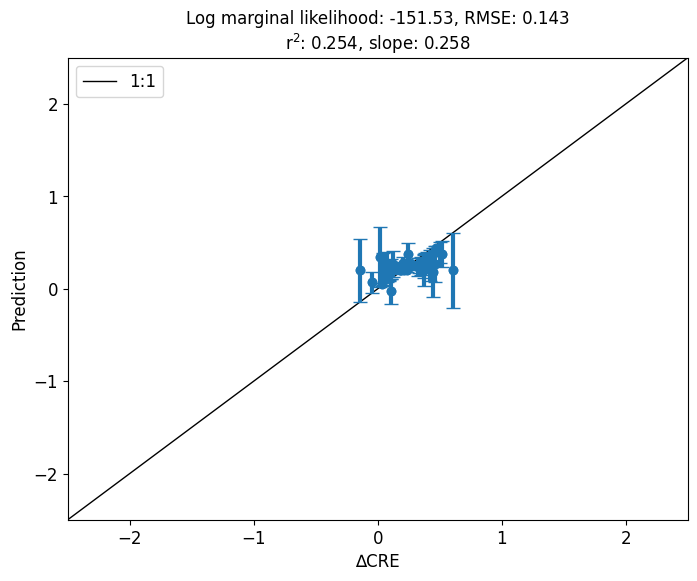

ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1) + ExpSineSquared(length_scale=1, periodicity=1) * WhiteKernel(noise_level=1)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


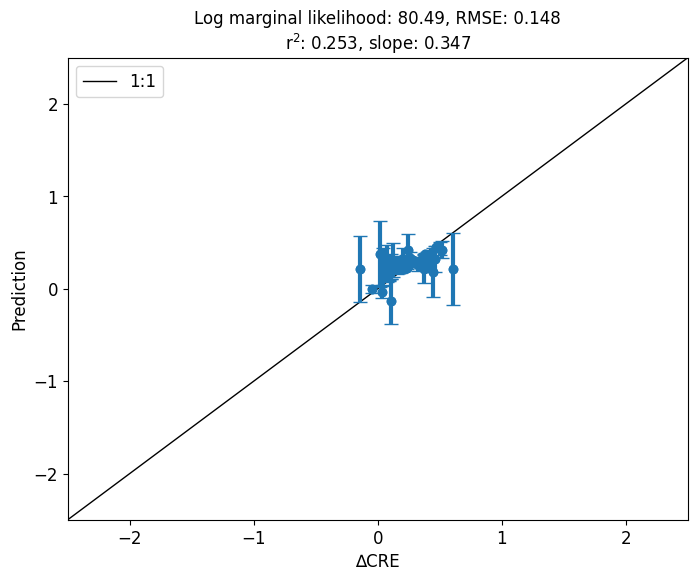

ExpSineSquared(length_scale=1, periodicity=1) + DotProduct(sigma_0=1) ** 2 + ExpSineSquared(length_scale=1, periodicity=1) * DotProduct(sigma_0=1) ** 2


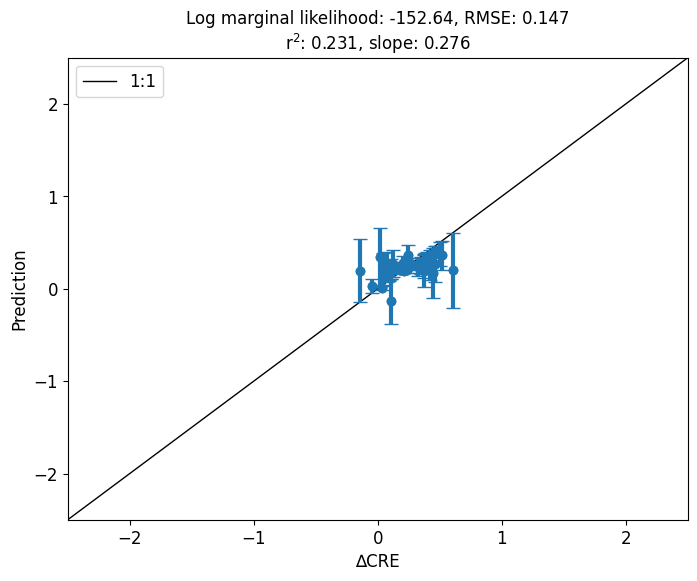

1**2 + DotProduct(sigma_0=1) + 1**2 * DotProduct(sigma_0=1)


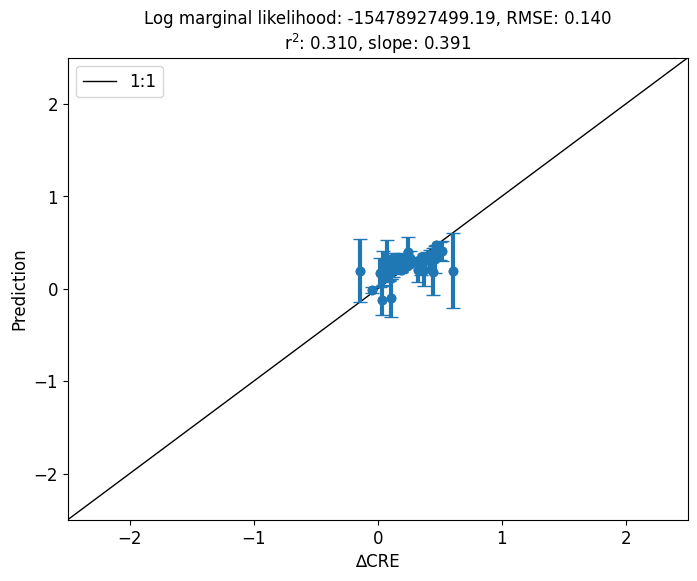

1**2 + WhiteKernel(noise_level=1) + 1**2 * WhiteKernel(noise_level=1)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


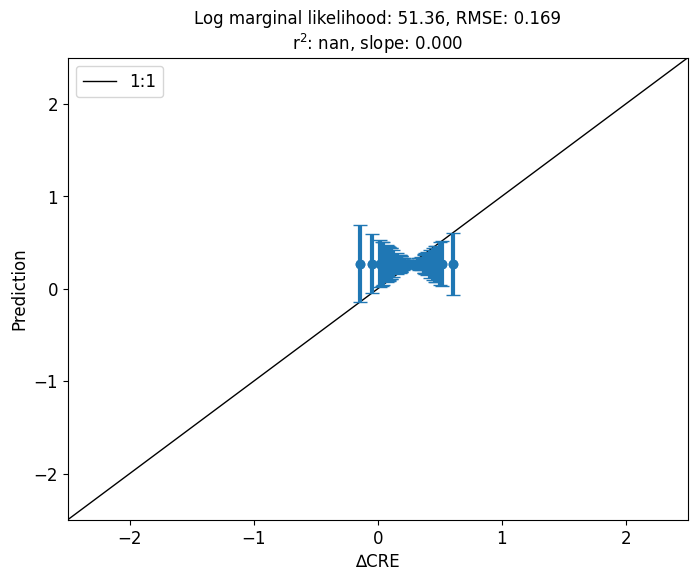

1**2 + DotProduct(sigma_0=1) ** 2 + 1**2 * DotProduct(sigma_0=1) ** 2


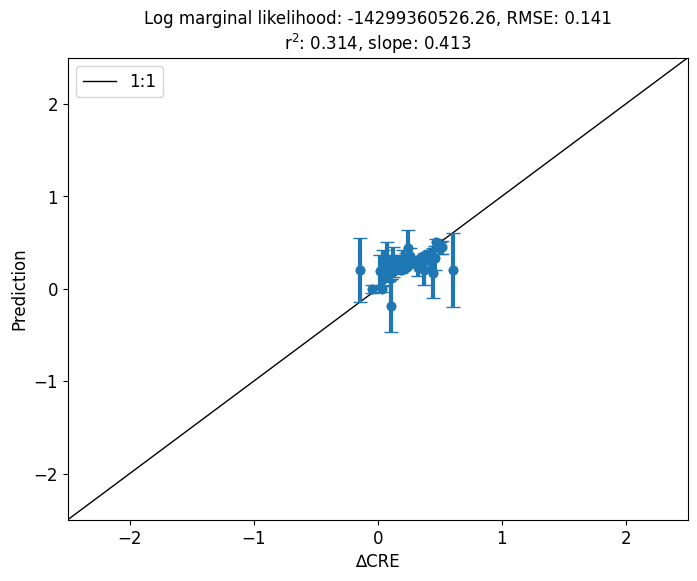

DotProduct(sigma_0=1) + WhiteKernel(noise_level=1) + DotProduct(sigma_0=1) * WhiteKernel(noise_level=1)


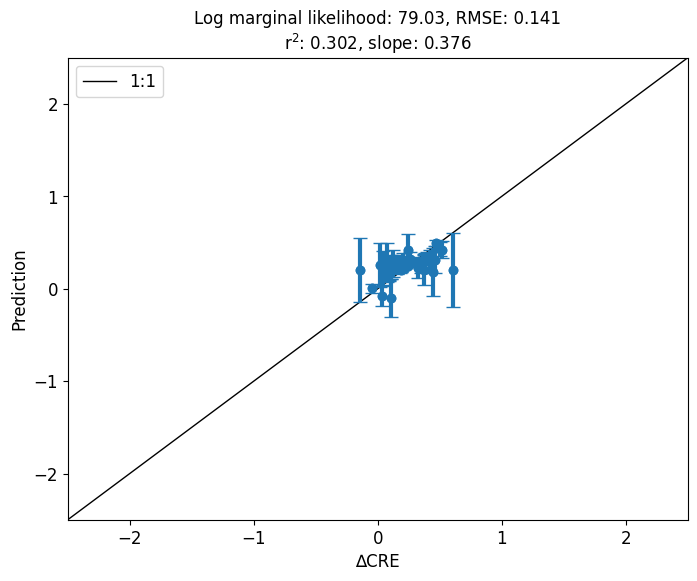

DotProduct(sigma_0=1) + DotProduct(sigma_0=1) ** 2 + DotProduct(sigma_0=1) * DotProduct(sigma_0=1) ** 2


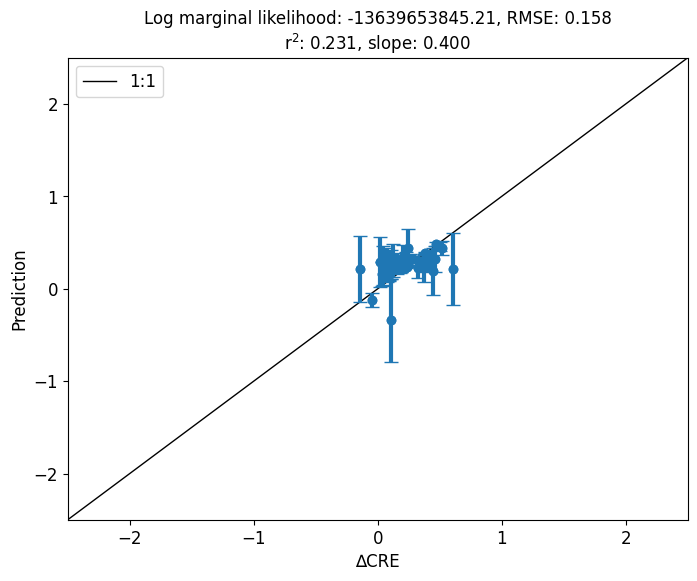

WhiteKernel(noise_level=1) + DotProduct(sigma_0=1) ** 2 + WhiteKernel(noise_level=1) * DotProduct(sigma_0=1) ** 2


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__kernel__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


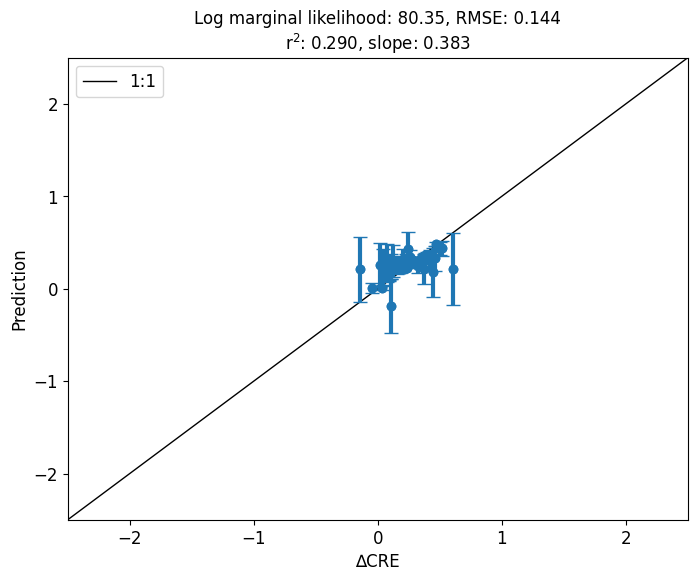

In [72]:
var = '∆CRE'
# for combination in out:
# print(combination)
# kernel = list(out)
find_kernel_single_PPE(var, x_p, y_p, c_p, elims=[-5, 5], dlims=[-2.5, 2.5],
                      kernels_list=kernel_list)


1**2 + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


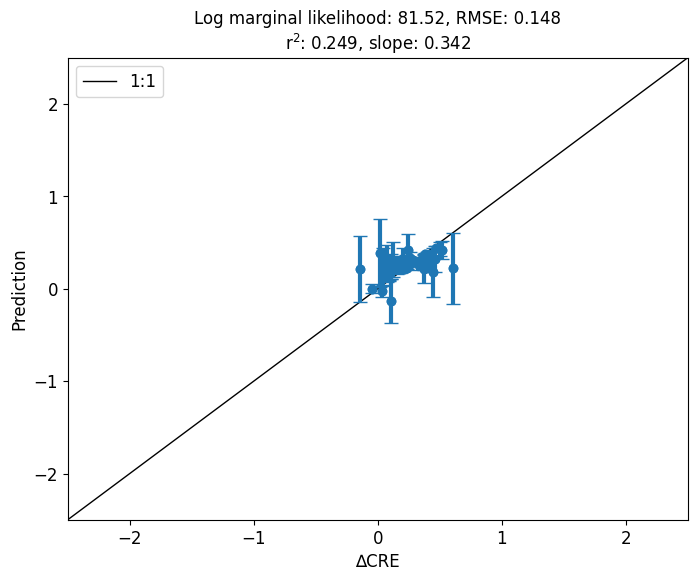

1**2 + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


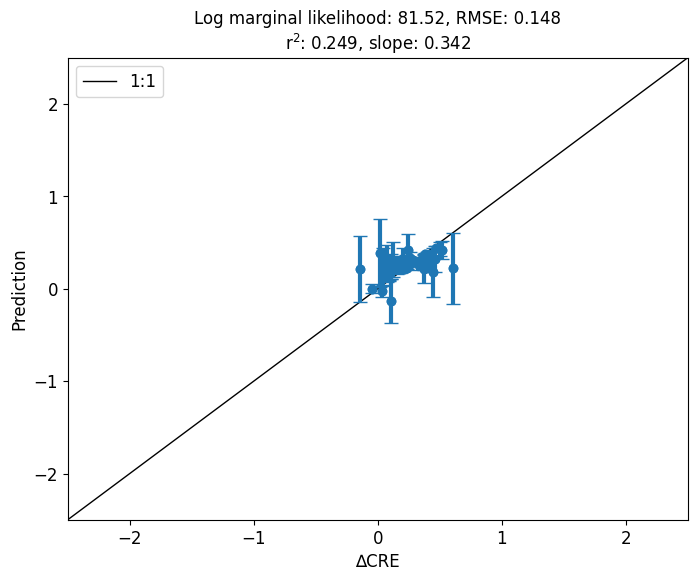

1**2 + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


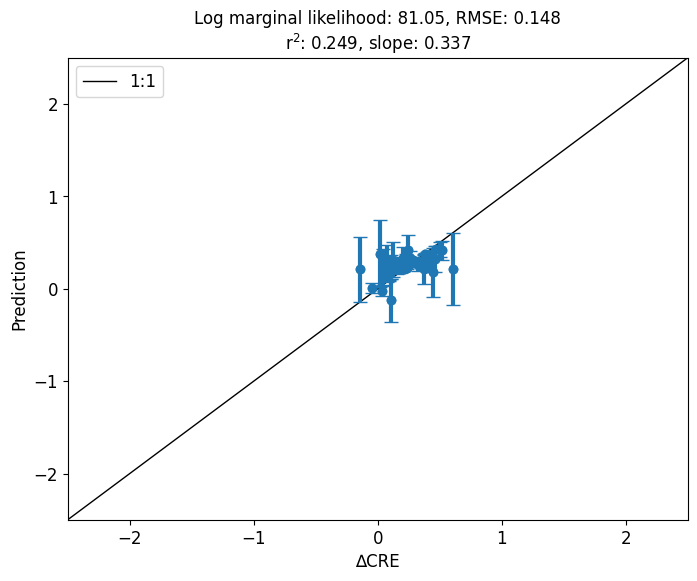

1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


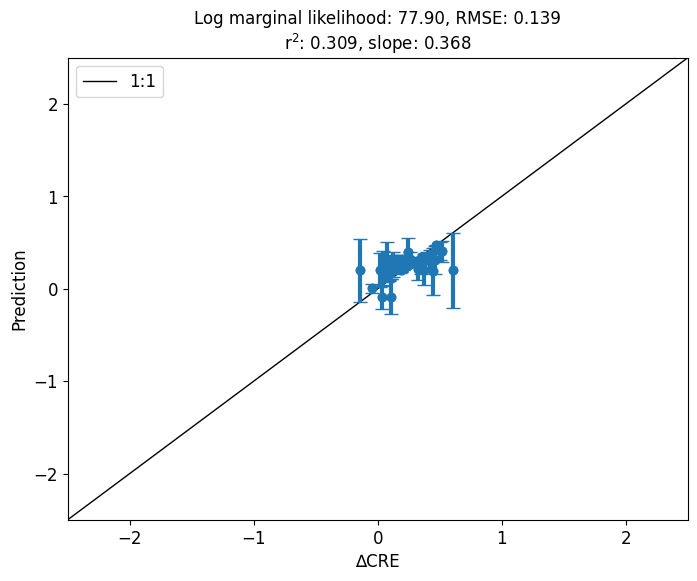

1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


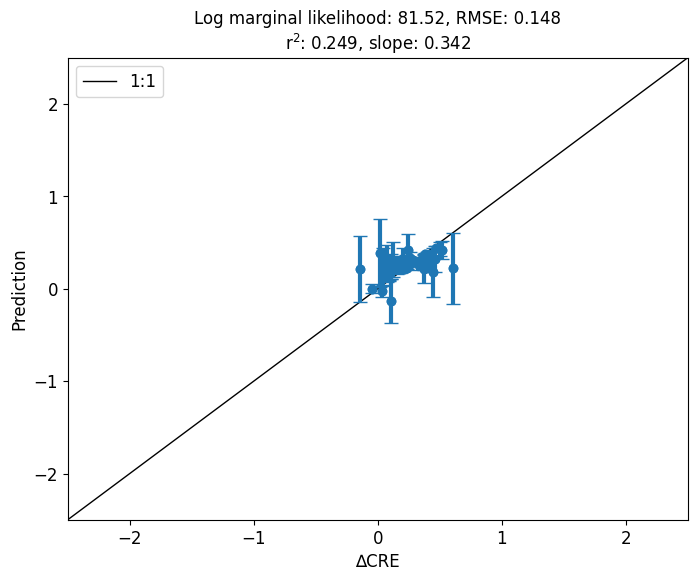

In [51]:
# var = '∆CRE'
var = '∆CRE'
find_kernel_single_PPE(var, x_p, y_p, c_p, elims=[-5, 5], dlims=[-2.5, 2.5],
                          kernels_list=None)

# "winner" is this one:
# dlnlwp_e3sm_kernel = kernels.ConstantKernel() + \
#                      kernels.ConstantKernel() *kernels.ExpSineSquared() + \
#                      kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.RationalQuadratic()) + \
#                      kernels.WhiteKernel()


1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


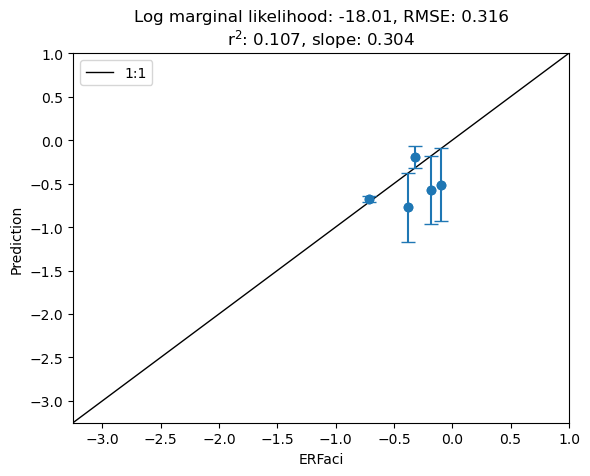

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.

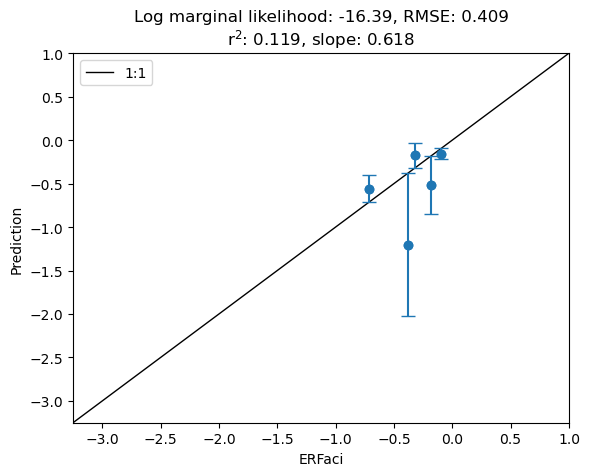

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

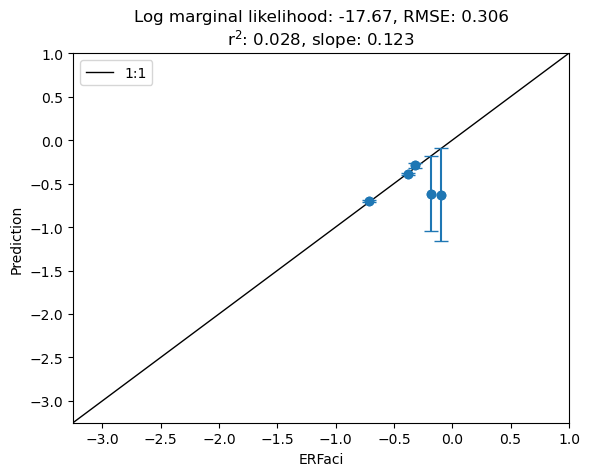

In [51]:
# new, based on E3SMv3 scatter plots
ekernels_1 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*x + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + \
              kernels.WhiteKernel() for x in base_kernels]

# old, based on multi-PPE scatter plots 
ekernels_2 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + \
              kernels.WhiteKernel() for x in base_kernels]

# new but with 3 variables
ekernels_3 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*x + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), y) + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), z) + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels for z in base_kernels]

kernels_list = ekernels_3 

# these are the ones with positive slope for predicted vs. actual from ekernels_3
# (ekernels_1 and ekernels_2 were all negative)
test1 = kernels.ConstantKernel() + \
        kernels.ConstantKernel()*kernels.ExpSineSquared() + \
        kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.RationalQuadratic()) + \
        kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.ExpSineSquared()) + \
        kernels.WhiteKernel()
test2 = kernels.ConstantKernel() + \
        kernels.ConstantKernel()*kernels.ConstantKernel() + \
        kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.ExpSineSquared()) + \
        kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.Matern()) + \
        kernels.WhiteKernel()
test3 = kernels.ConstantKernel() + \
        kernels.ConstantKernel()*kernels.RBF() + \
        kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.Matern()) + \
        kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.ExpSineSquared()) + \
        kernels.WhiteKernel()

# erfaci
find_kernel_single_PPE("E3SMv3", "ERFaci", elims=[-5, 5], dlims=[0, 0.05],
                          # kernels_list=ekernels_3, pos_slope_only=True)
                          kernels_list=[test1, test2, test3], pos_slope_only=True)


# "winner" is this one (test2):
erfaci_e3sm_kernel = kernels.ConstantKernel() + \
                     kernels.ConstantKernel()*kernels.ConstantKernel() + \
                     kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.ExpSineSquared()) + \
                     kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.Matern()) + \
                     kernels.WhiteKernel()


#### GA7.1

In [12]:
data = pg.get_ppe_data(pg.get_ppe_ds_dict(file_path, pickle_path)["GA7.1"], "GA7.1")
lwp, lnlwp, dlwp, dlnlwp, dadlwp, dlwp_dadlwp, dnd, erfaci = data


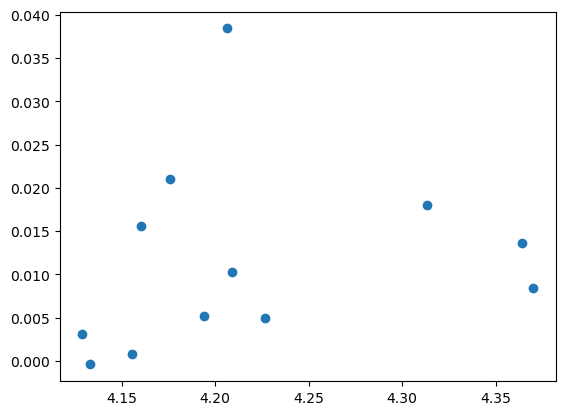

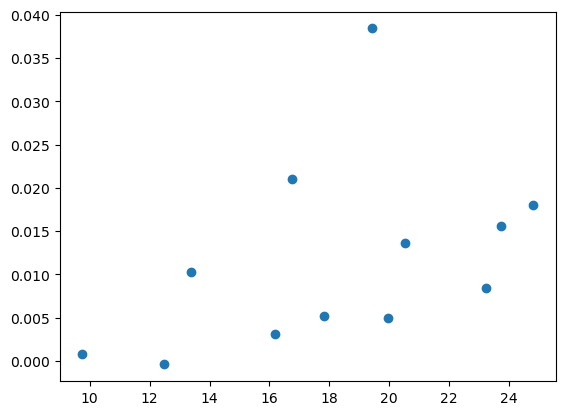

In [56]:
# dlnlwp: try quadratic and linear?
plt.scatter(lnlwp, dlnlwp)
plt.show()
plt.scatter(dnd, dlnlwp)
plt.show()

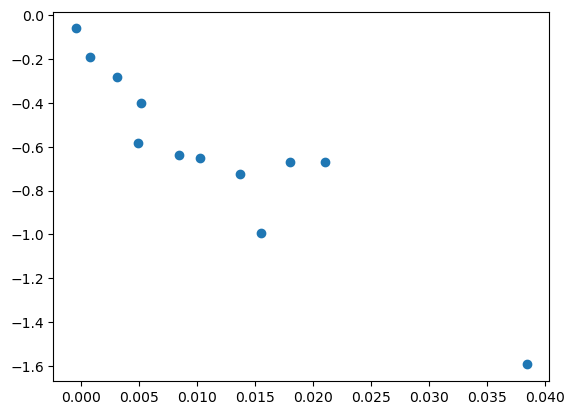

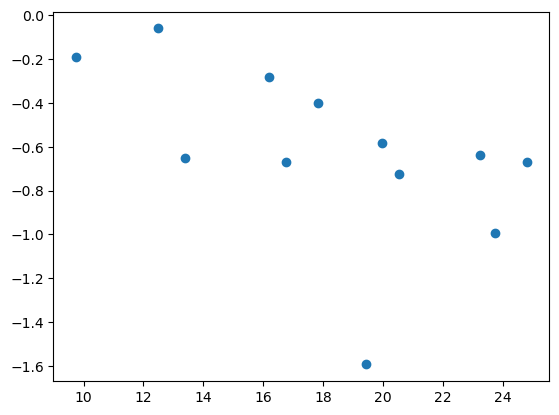

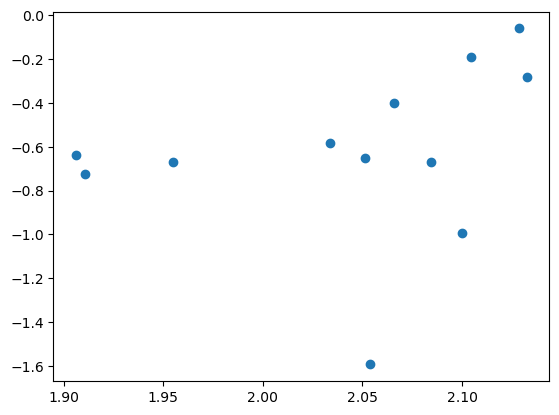

In [57]:
# erfaci: try linear, linear, dot product?
plt.scatter(dlnlwp, erfaci)
plt.show()
plt.scatter(dnd, erfaci)
plt.show()
plt.scatter(dadlwp, erfaci)
plt.show()

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  wa

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  wa

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

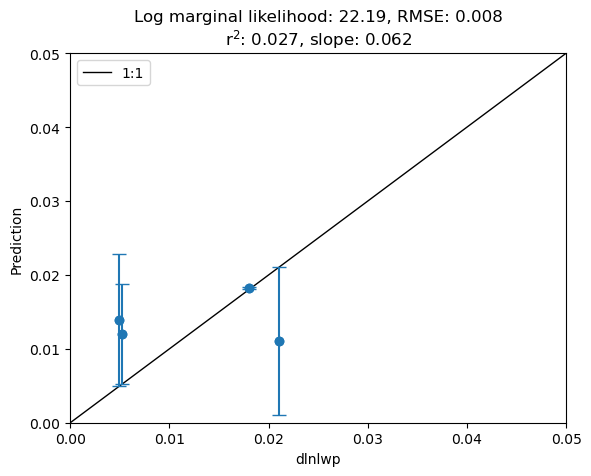

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  wa

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.wa

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  wa

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.wa

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

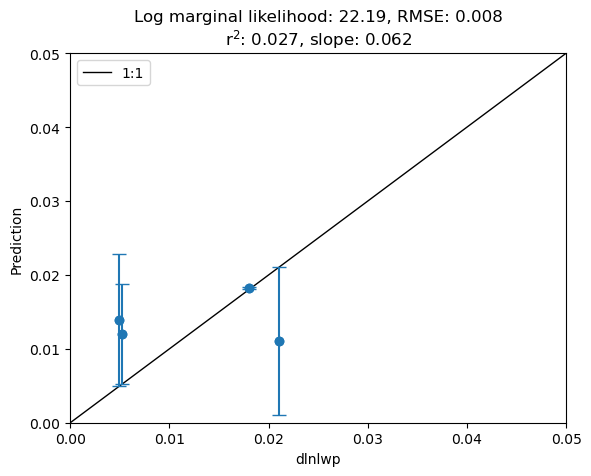

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  wa

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

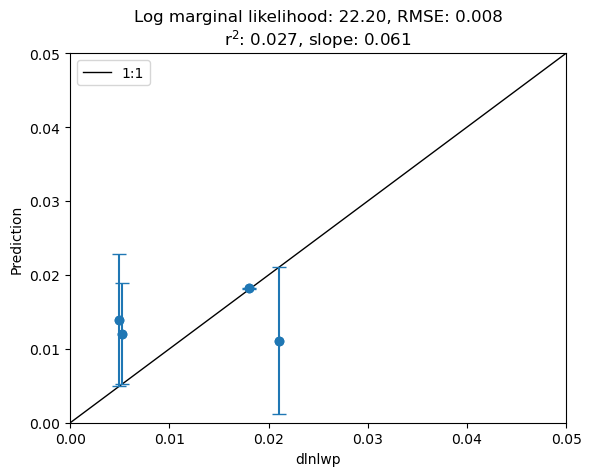

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

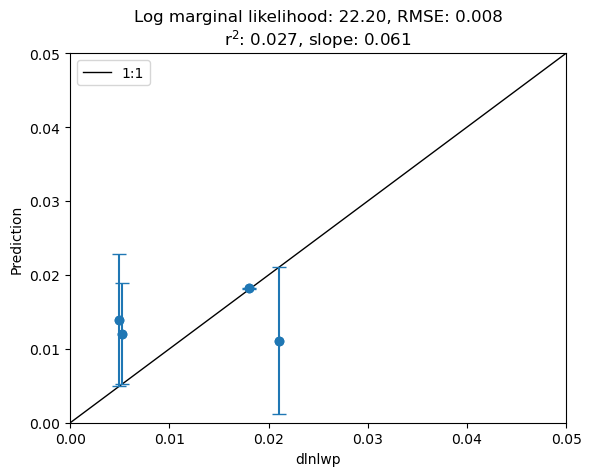

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


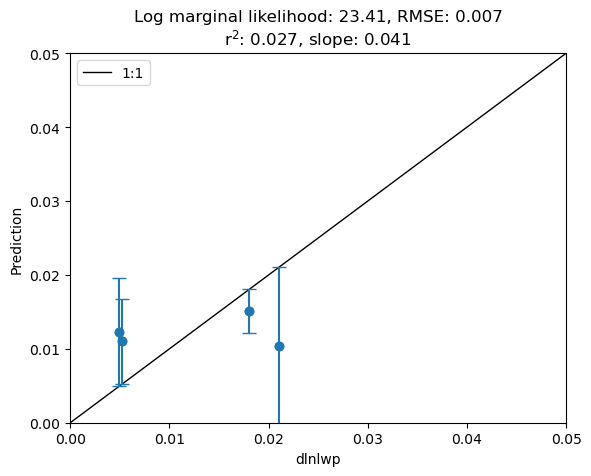

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

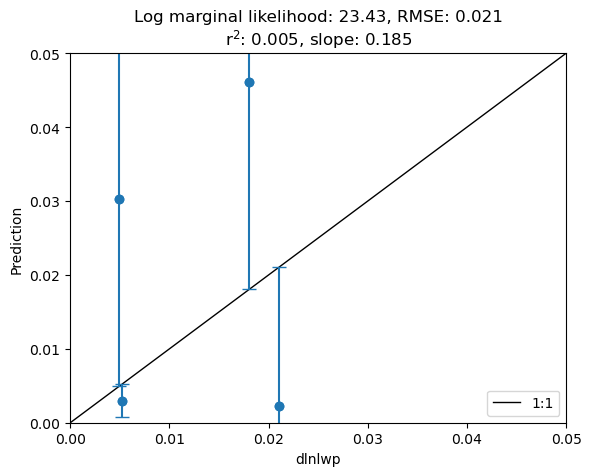

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  wa

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.wa

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.wa

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  wa

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  wa

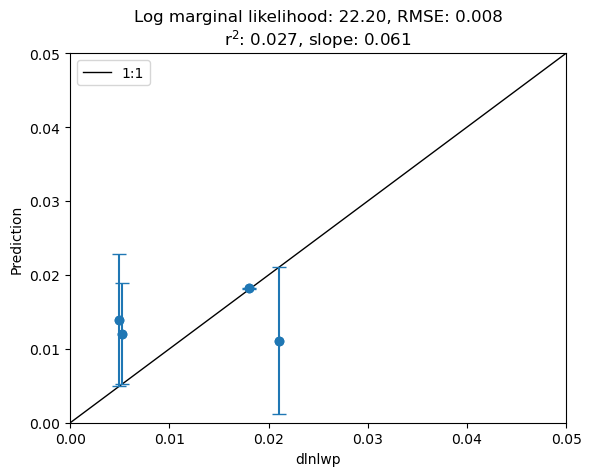

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  wa

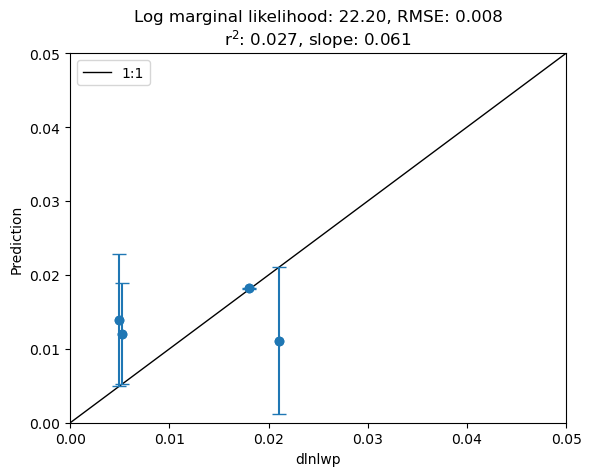

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

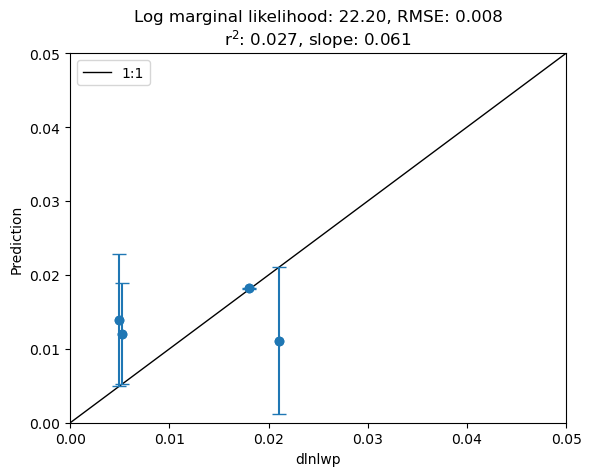

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.war

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

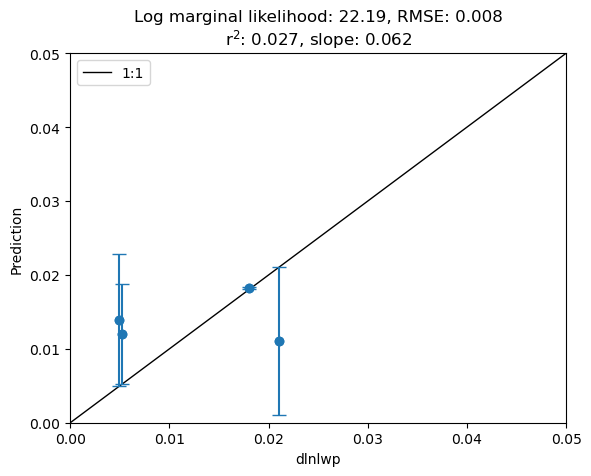

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.wa

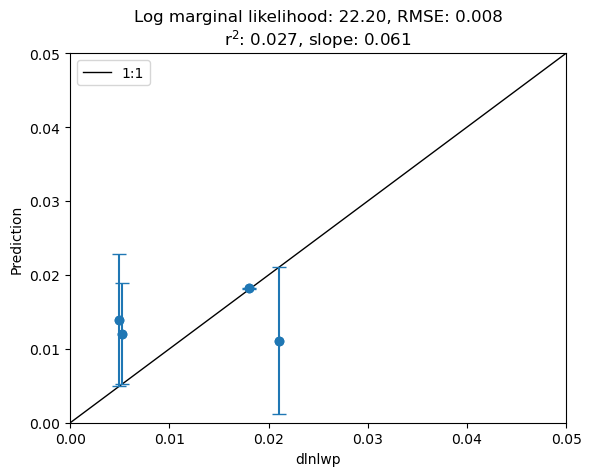

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  wa

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit a

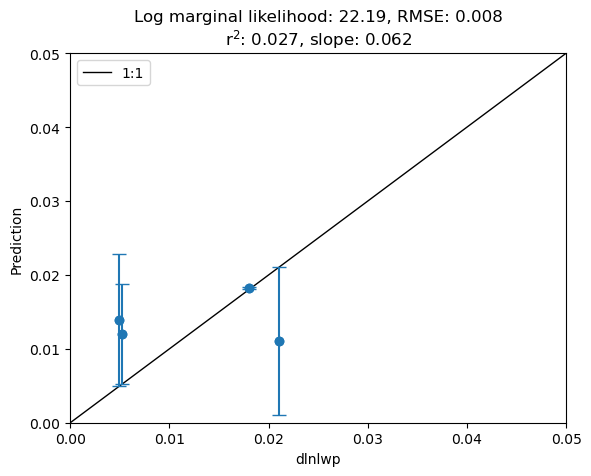

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  wa

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.wa

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  wa

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.wa

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

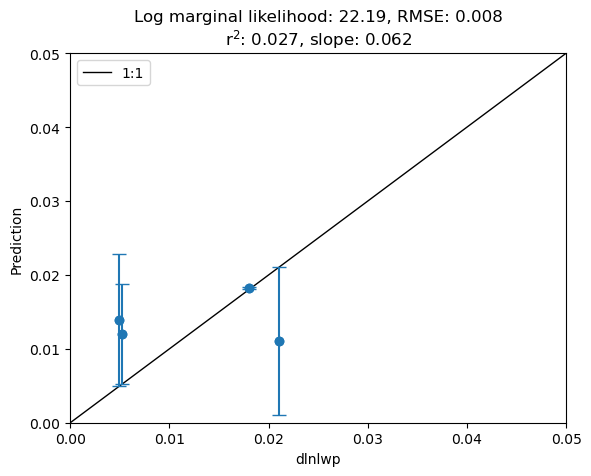

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  wa

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

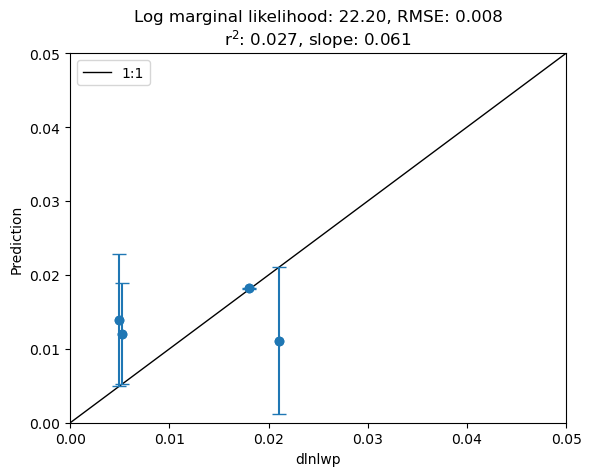

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

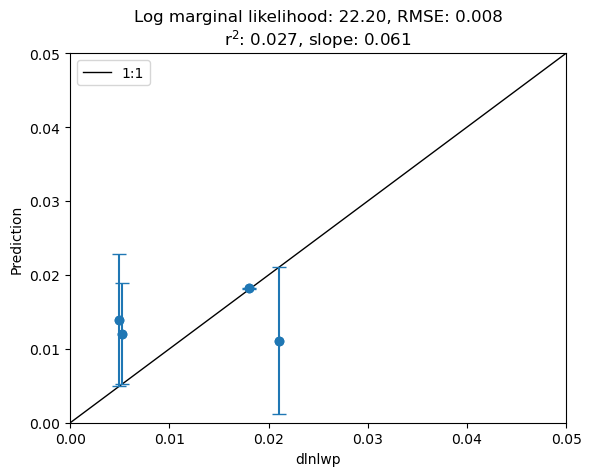

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


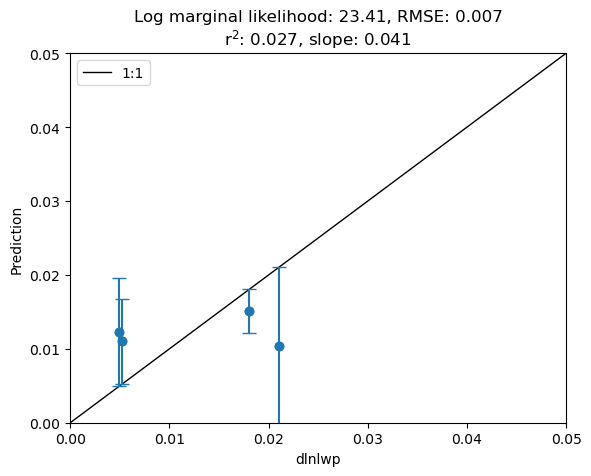

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

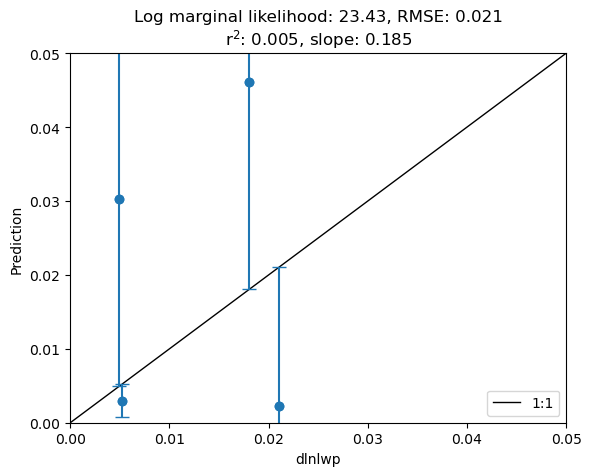

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  wa

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.wa

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.wa

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.wa

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 

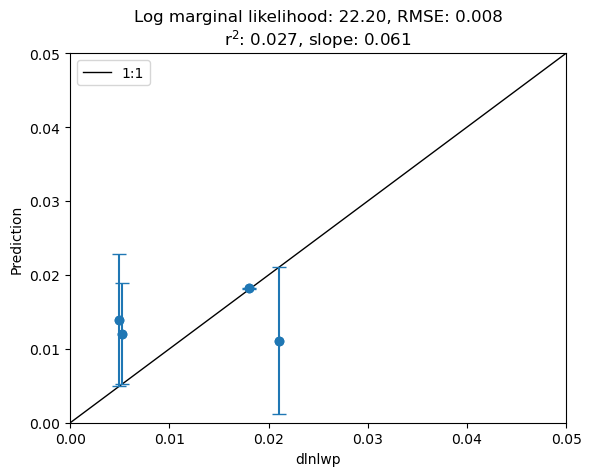

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

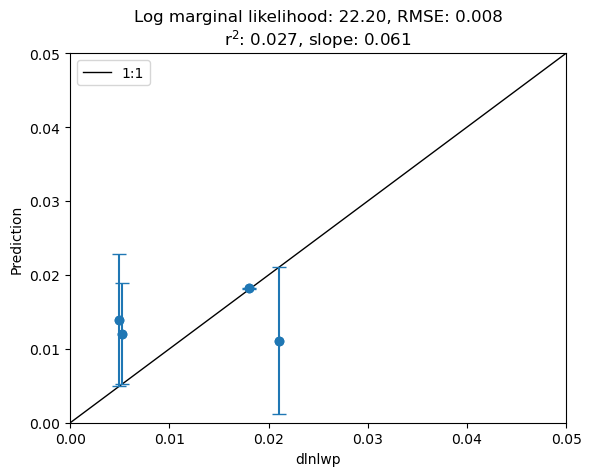

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 

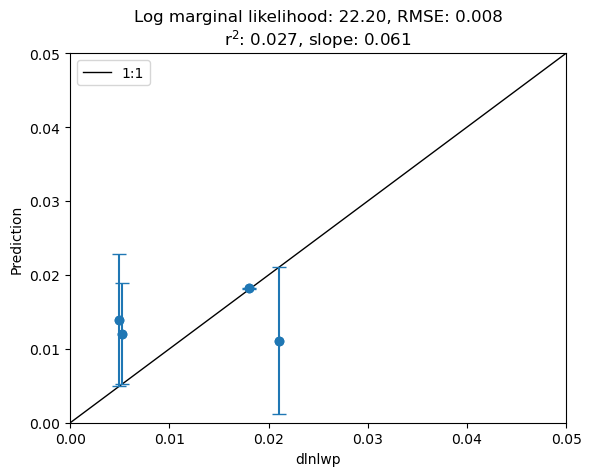

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

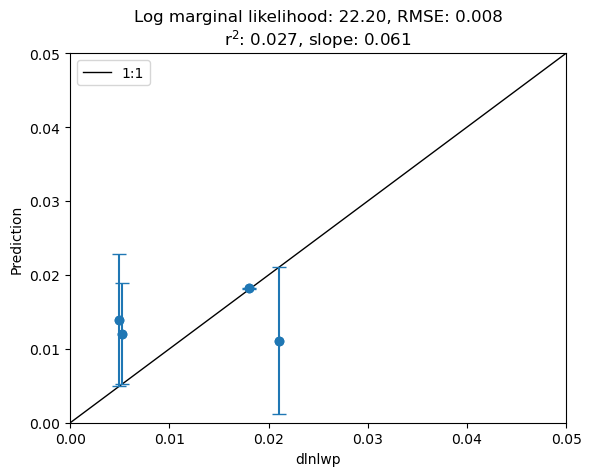

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 

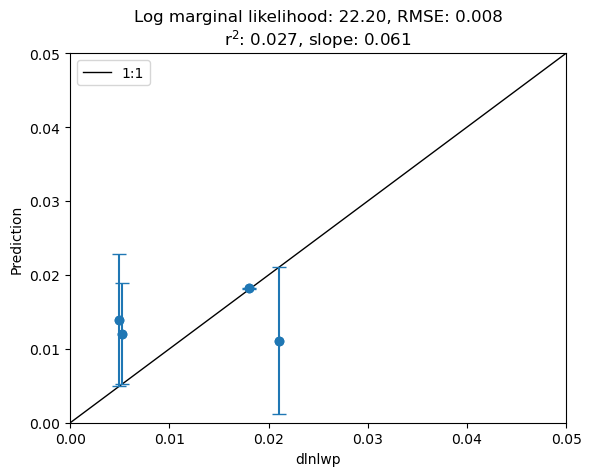

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 

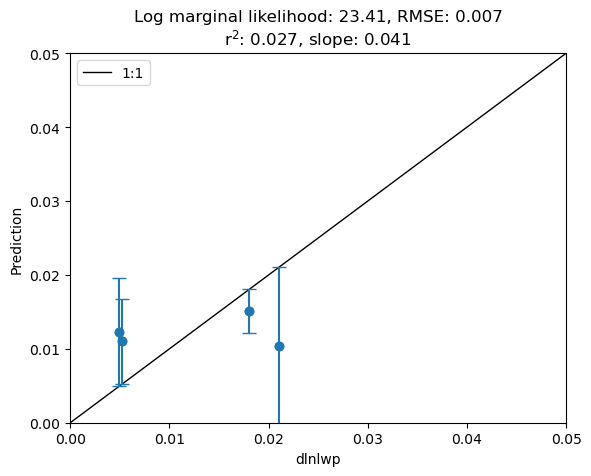

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 

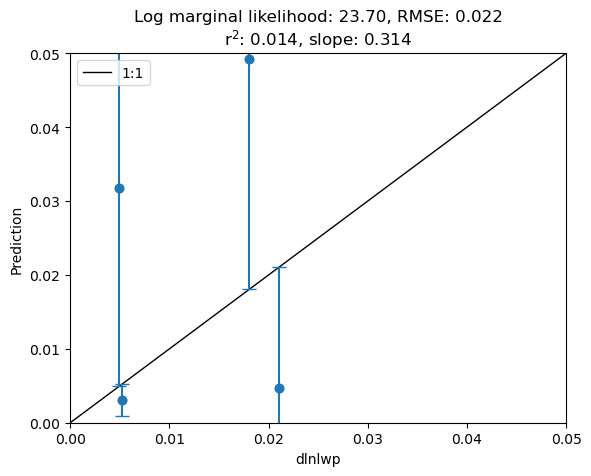

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.wa

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  war

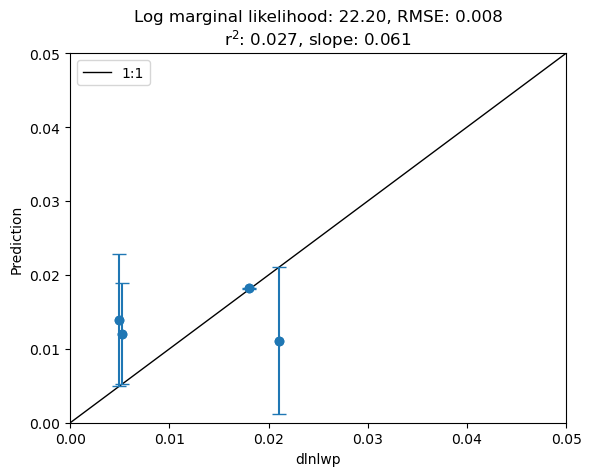

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.wa

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  wa

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  wa

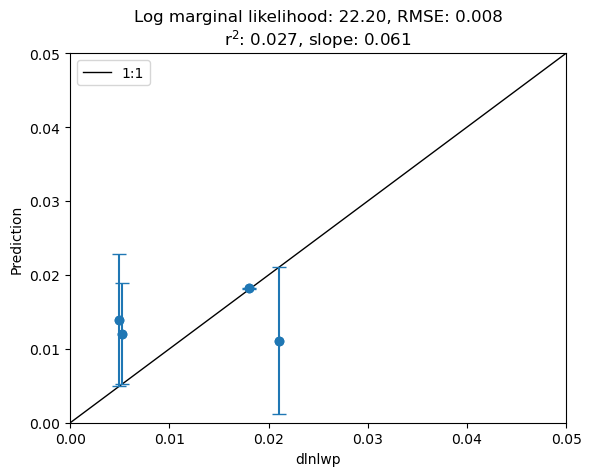

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.wa

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
 

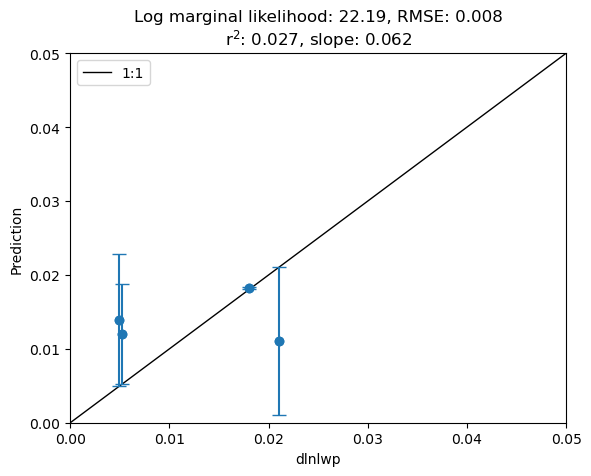

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  wa

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.wa

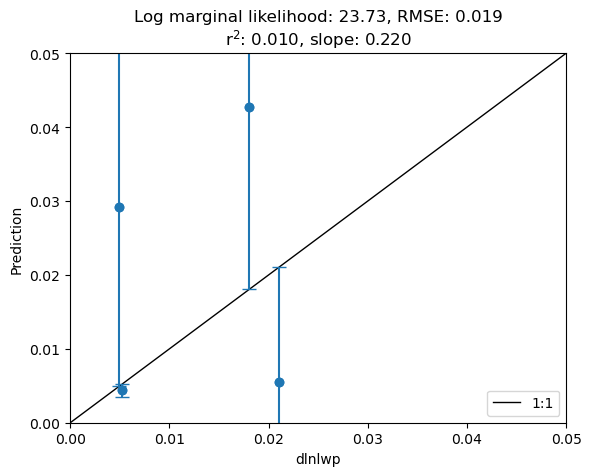

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

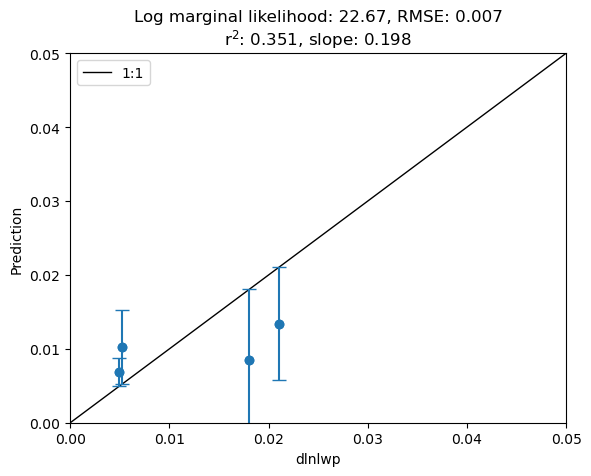

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.wa

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warning

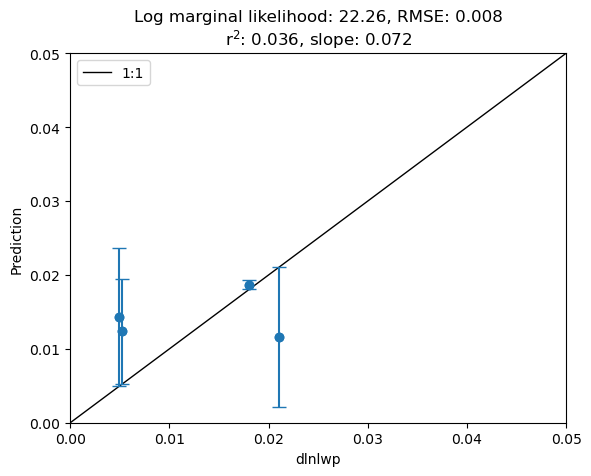

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

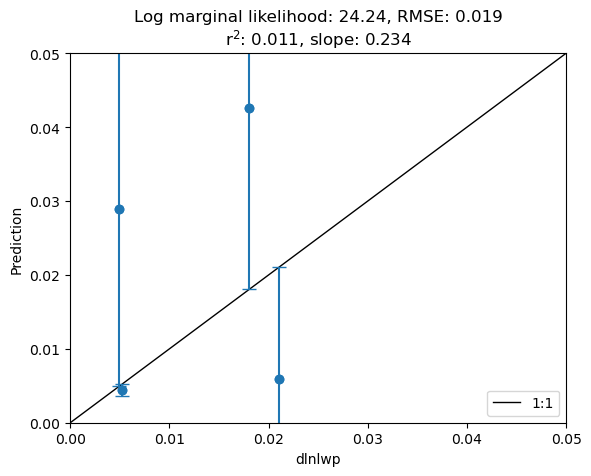

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

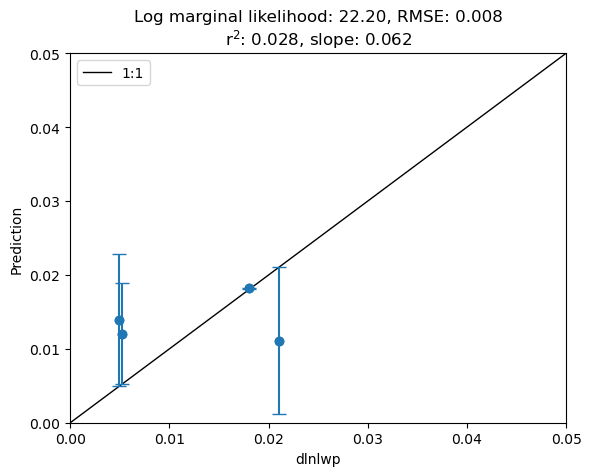

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

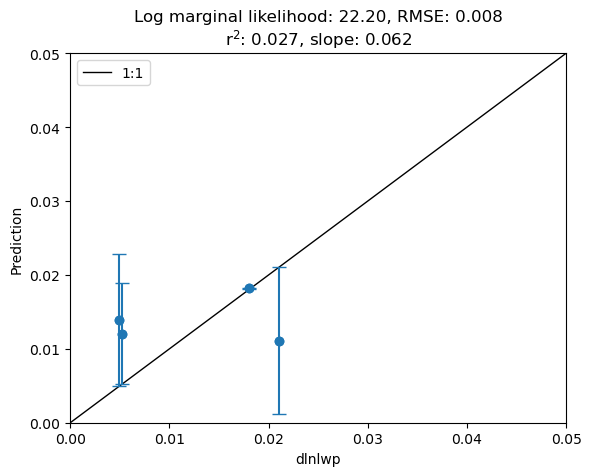

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  wa

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.wa

1**2 + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 

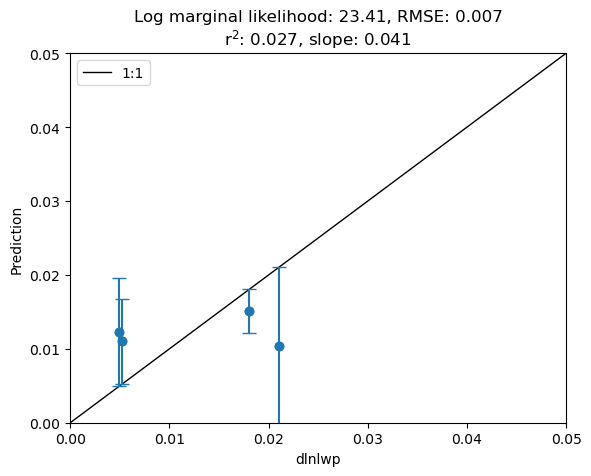

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

1**2 + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnin

1**2 + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

1**2 + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnin

1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


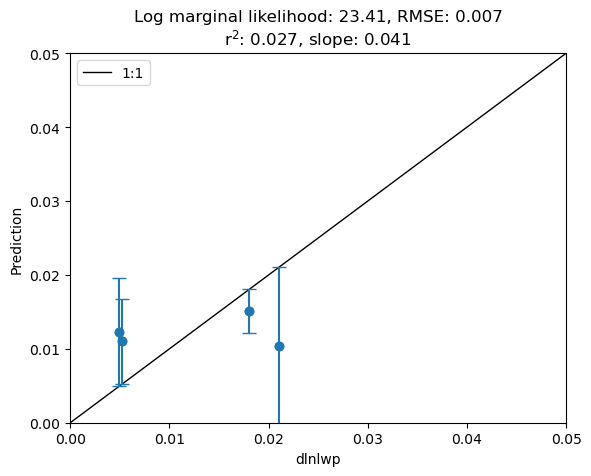

1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnin

In [43]:
# new, based on GA7.1 scatter plots
dkernels_1 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*x + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + \
              kernels.WhiteKernel() for x in base_kernels]

# old, based on multi-PPE scatter plots 
dkernels_2 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + \
              kernels.WhiteKernel() for x in base_kernels]

# new but with 3 variables
dkernels_3 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*x + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), y) + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), z) + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels for z in base_kernels]

kernels_list = dkernels_3 + dkernels_1  + dkernels_2

# dlnlwp
# use 70-30 split bc sample size is small for testing
find_kernel_single_PPE("GA7.1", "dlnlwp", elims=[-2, 1], dlims=[0, 0.05],
                        kernels_list=kernels_list, pos_slope_only=True,
                       test_split=0.3)

# "winner"
dlnlwp_ga71_kernel = kernels.ConstantKernel() + \
                     kernels.ConstantKernel()*kernels.ExpSineSquared() + \
                     kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.Matern()) + \
                     kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.ConstantKernel()) + \
                     kernels.WhiteKernel()

                     

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__periodicity is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:478: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


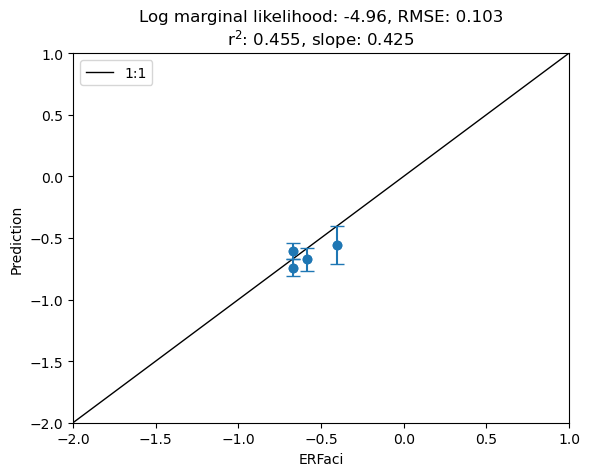

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/g

In [33]:
# new, based on GA7.1 scatter plots
ekernels_1 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*x + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), y) + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), z) + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels for z in base_kernels]

# old, based on multi-PPE scatter plots 
ekernels_2 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + \
              kernels.WhiteKernel() for x in base_kernels]# for y in base_kernels]

# simpler? 
ekernels_3 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + \
              kernels.WhiteKernel() for x in base_kernels]


# these formats generally performs better than ekernels_2
kernels_list = ekernels_3 + ekernels_1

# erfaci
# use 70-30 split bc sample size is small for testing
find_kernel_single_PPE("GA7.1", "ERFaci", elims=[-2, 1], dlims=[0, 0.05],
                        kernels_list=kernels_list, pos_slope_only=True,
                       test_split=0.3)

# "Winner"
erfaci_ga71_kernel = kernels.ConstantKernel() + \
                      kernels.ConstantKernel()*kernels.ExpSineSquared() + \
                      kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.RationalQuadratic()) + \
                      kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.RationalQuadratic()) + \
                      kernels.WhiteKernel()


##### Notes from the ERFaci loop

#### CAM6

In [5]:
data = pg.get_ppe_data(pg.get_ppe_ds_dict(file_path, pickle_path)["CAM6"], "CAM6")
lwp, lnlwp, dlwp, dlnlwp, dadlwp, dlwp_dadlwp, dnd, erfaci = data


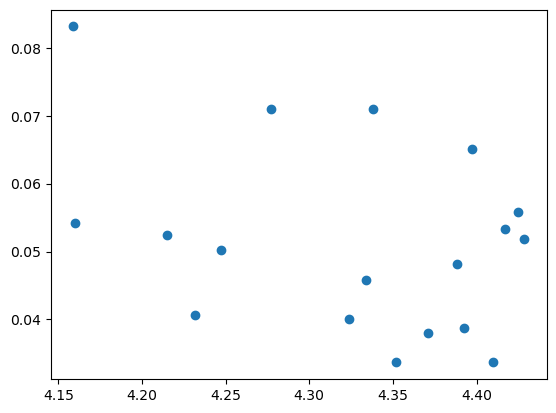

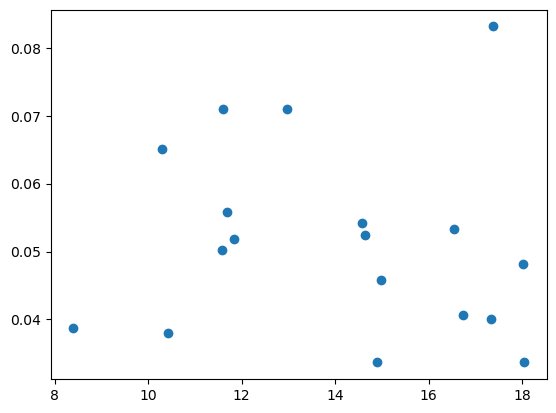

In [6]:
# dlnlwp: try linear + one normal?
plt.scatter(lnlwp, dlnlwp)
plt.show()
plt.scatter(dnd, dlnlwp)
plt.show()


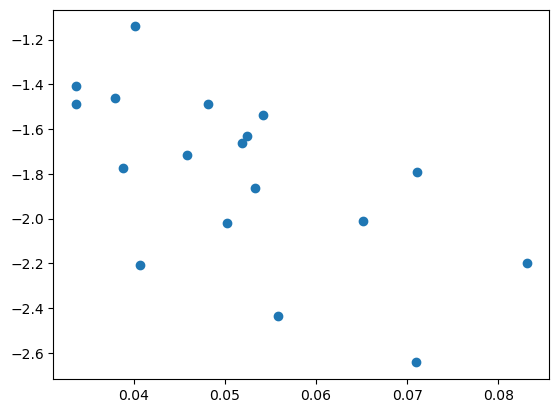

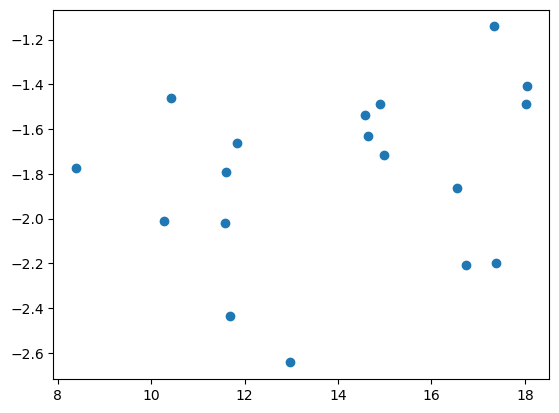

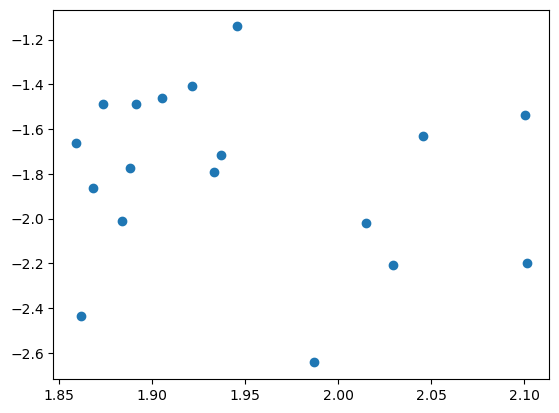

In [7]:
# erfaci: try linear + 2 normal?
plt.scatter(dlnlwp, erfaci)
plt.show()
plt.scatter(dnd, erfaci)
plt.show()
plt.scatter(dadlwp, erfaci)
plt.show()


1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


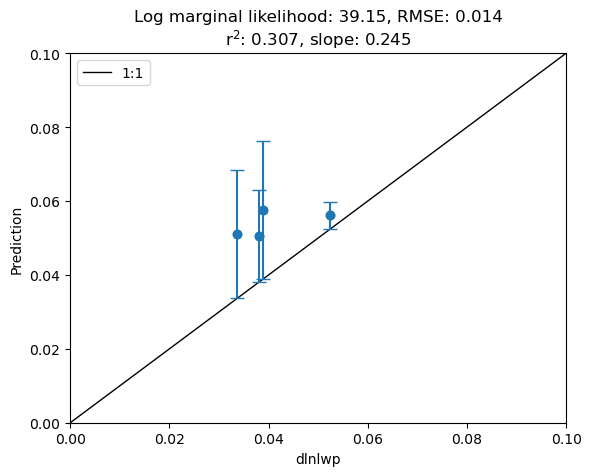

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


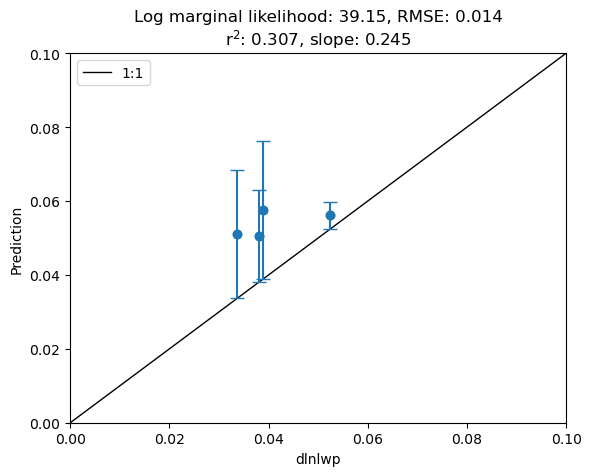

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


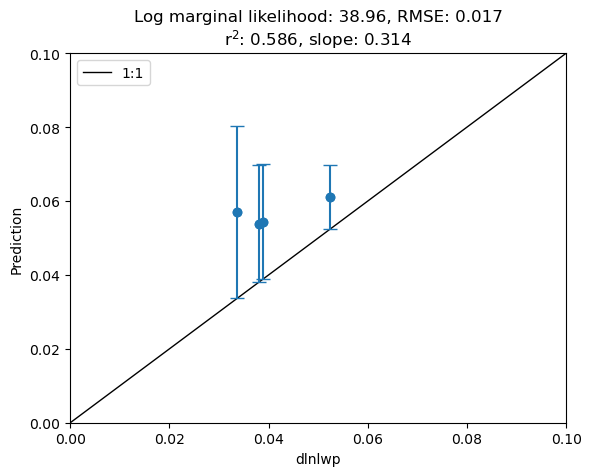

In [21]:
# new, based on CAM6 scatter plots
dkernels_1 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*x + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), y) + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels]

# old, based on multi-PPE scatter plots 
dkernels_2 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), y) + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels]

# simpler?
dkernels_3 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*x + \
              kernels.ConstantKernel()*y + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels]
dkernels_4 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*kernels.Product(y, x) + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels]

kernels_list = dkernels_3 + dkernels_4 #dkernels_1  + dkernels_2

# the best ones of set 3-4
test1 = kernels.ConstantKernel() + \
        kernels.ConstantKernel()*kernels.ExpSineSquared() + \
        kernels.ConstantKernel()*kernels.ExpSineSquared() + \
        kernels.WhiteKernel()
test2 = kernels.ConstantKernel() + \
        kernels.ConstantKernel()*kernels.ExpSineSquared() + \
        kernels.ConstantKernel()*kernels.RationalQuadratic() + \
        kernels.WhiteKernel()
test3 = kernels.ConstantKernel() + \
        kernels.ConstantKernel()*kernels.Product(kernels.ExpSineSquared(), kernels.ExpSineSquared()) +\
        kernels.WhiteKernel()

kernels_list = [test1, test2, test3]

# dlnlwp
find_kernel_single_PPE("CAM6", "dlnlwp", elims=[-2, 1], dlims=[0, 0.1],
                        kernels_list=kernels_list, pos_slope_only=True)

# # "winner"
dlnlwp_cam6_kernel = kernels.ConstantKernel() + \
                     kernels.ConstantKernel()*kernels.ExpSineSquared() + \
                     kernels.ConstantKernel()*kernels.RationalQuadratic() + \
                     kernels.WhiteKernel()


1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


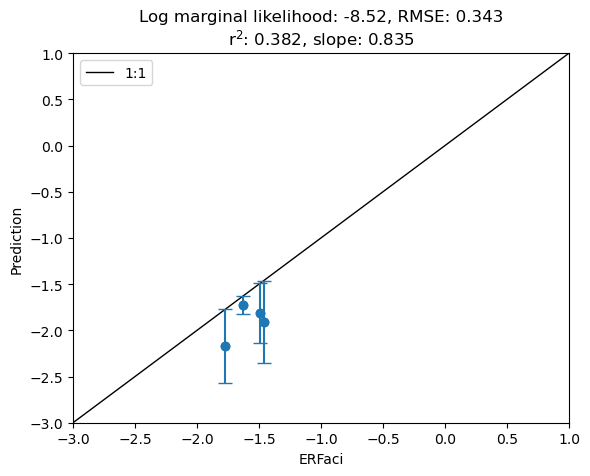

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:478: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


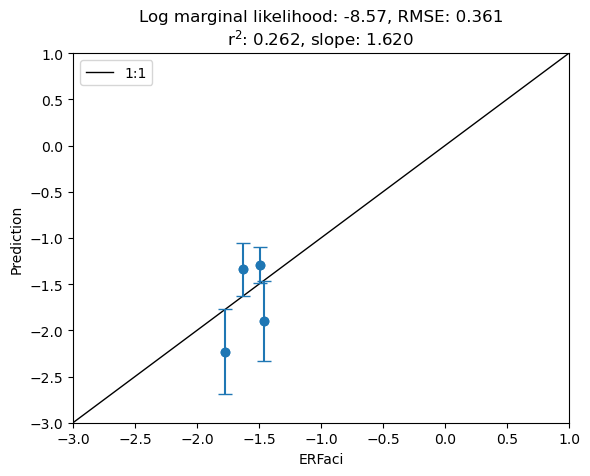

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


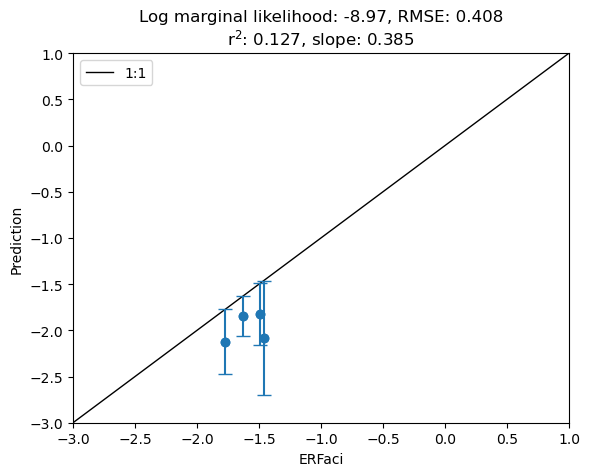

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


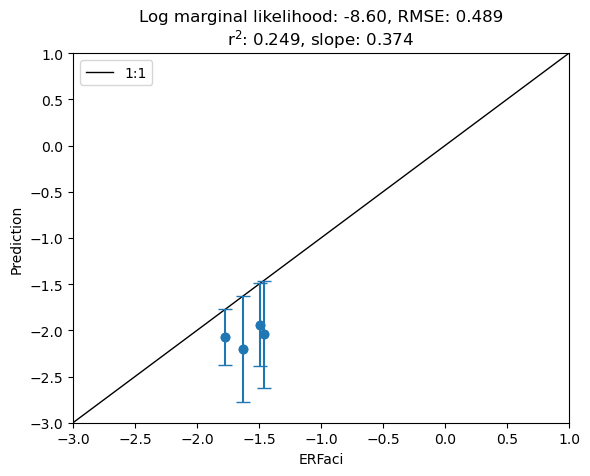

In [28]:
# new, based on CAM6 scatter plots
ekernels_1 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*x + \
              kernels.ConstantKernel()*y + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), z) + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels for z in base_kernels]

# old, based on multi-PPE scatter plots 
ekernels_2 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), y) + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels]

kernels_list = ekernels_1 + ekernels_2


# based on 1 & 2
test1 = kernels.ConstantKernel() + \
        kernels.ConstantKernel()*kernels.ExpSineSquared() + \
        kernels.ConstantKernel()*kernels.RationalQuadratic() + \
        kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.ExpSineSquared()) + \
        kernels.WhiteKernel()
test2 = kernels.ConstantKernel() + \
        kernels.ConstantKernel()*kernels.ExpSineSquared() + \
        kernels.ConstantKernel()*kernels.ExpSineSquared() + \
        kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.RBF()) + \
        kernels.WhiteKernel()
test3 = kernels.ConstantKernel() + \
        kernels.ConstantKernel()*kernels.Matern() + \
        kernels.ConstantKernel()*kernels.Matern() + \
        kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.ExpSineSquared()) + \
        kernels.WhiteKernel()
test4 = kernels.ConstantKernel() + \
        kernels.ConstantKernel()*kernels.Matern() + \
        kernels.ConstantKernel()*kernels.RBF() + \
        kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.ExpSineSquared()) + \
        kernels.WhiteKernel()
kernels_list = [test1, test2, test3, test4]

# erfaci
find_kernel_single_PPE("CAM6", "ERFaci", elims=[-3, 1], dlims=[0, 0.1],
                        kernels_list=kernels_list, pos_slope_only=True)

erfaci_cam6_kernel = kernels.ConstantKernel() + \
                     kernels.ConstantKernel()*kernels.ExpSineSquared() + \
                     kernels.ConstantKernel()*kernels.ExpSineSquared() + \
                     kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.RBF()) + \
                     kernels.WhiteKernel()


#### ECHAM6-HAM

In [5]:
data = pg.get_ppe_data(pg.get_ppe_ds_dict(file_path, pickle_path)["ECHAM6-HAM"], "ECHAM6-HAM")
lwp, lnlwp, dlwp, dlnlwp, dadlwp, dlwp_dadlwp, dnd, erfaci = data


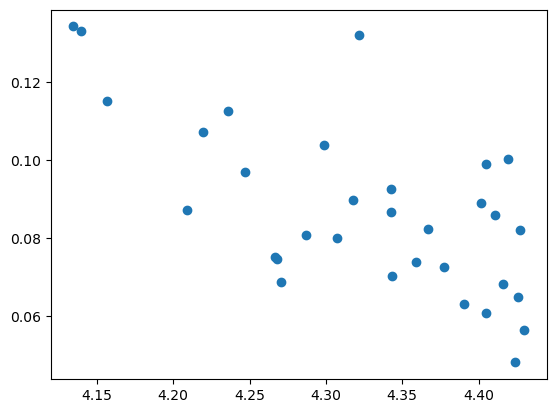

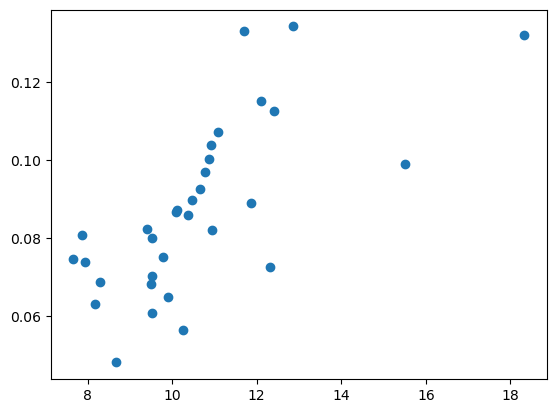

In [6]:
# dlnlwp: try two linear?
plt.scatter(lnlwp, dlnlwp)
plt.show()
plt.scatter(dnd, dlnlwp)
plt.show()

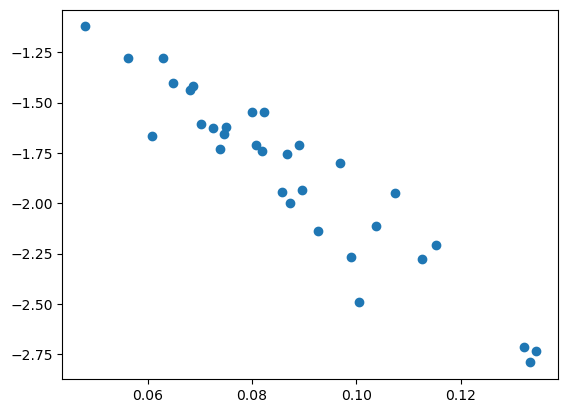

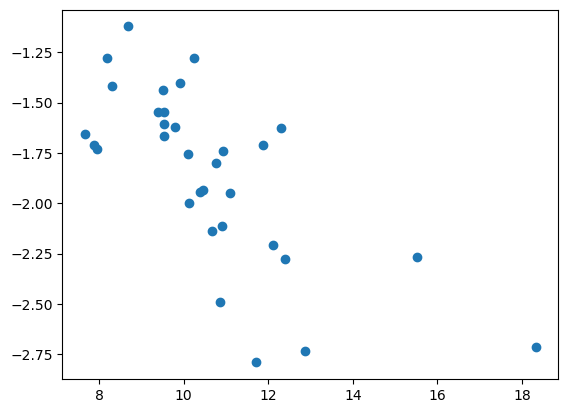

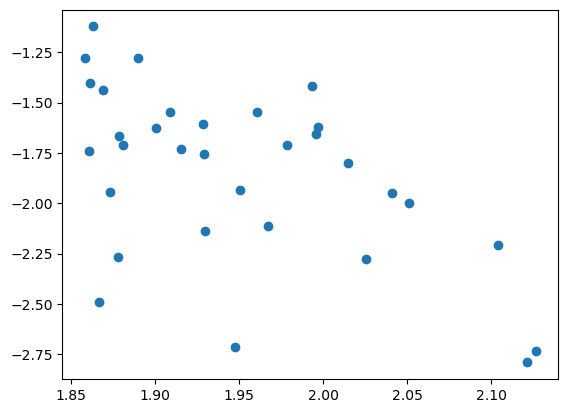

In [7]:
# erfaci: try 2 linear + 1 quadratic?
plt.scatter(dlnlwp, erfaci)
plt.show()
plt.scatter(dnd, erfaci)
plt.show()
plt.scatter(dadlwp, erfaci)
plt.show()

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


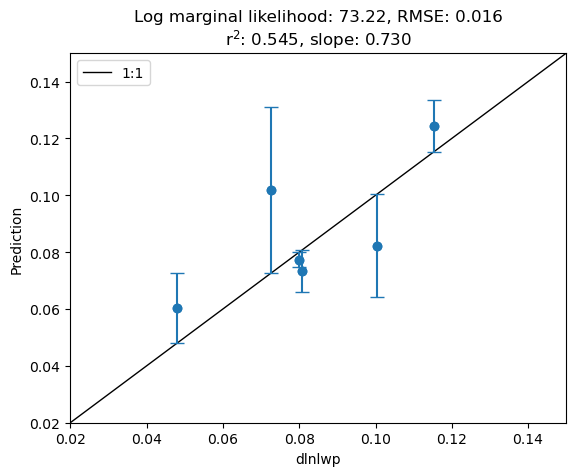

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


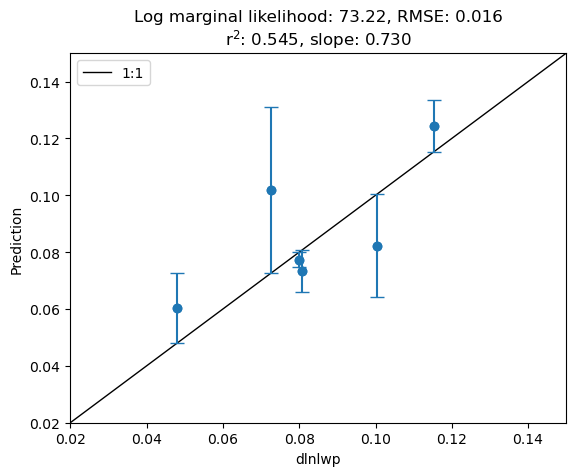

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


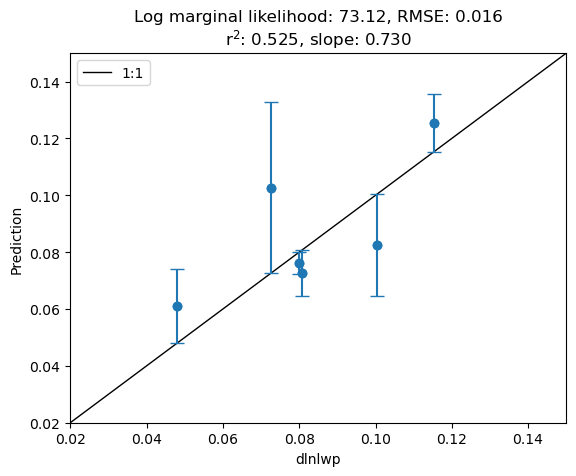

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


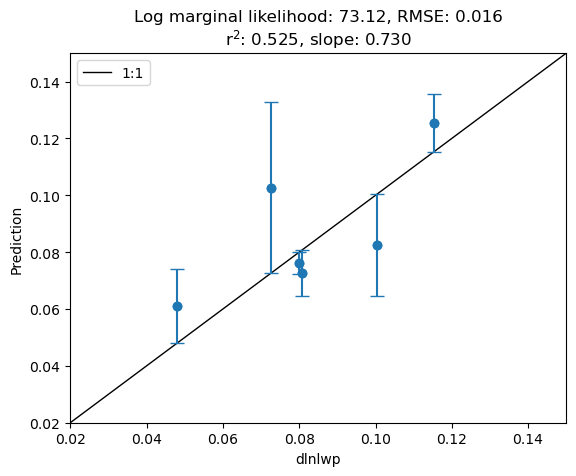

1**2 + 1**2 * RBF(length_scale=1) + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


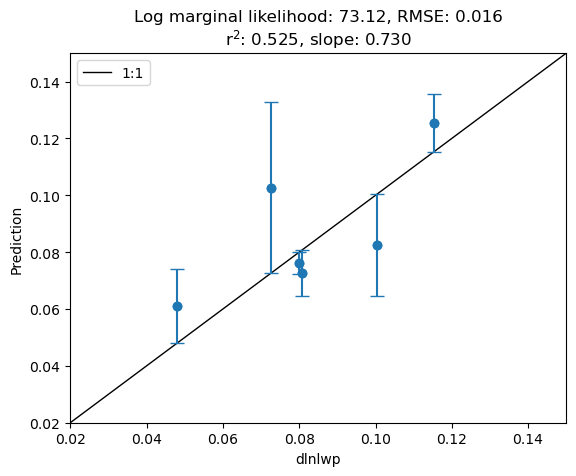

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find 

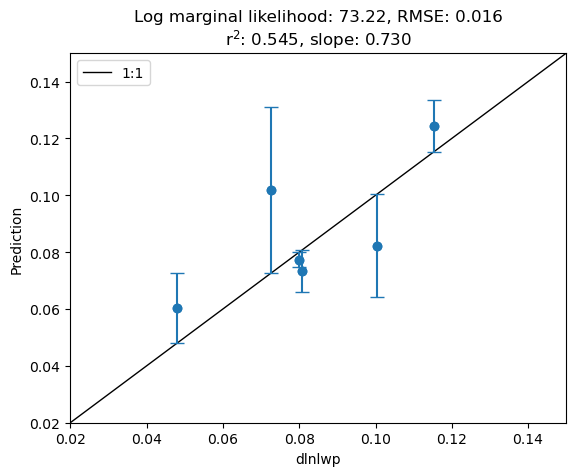

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


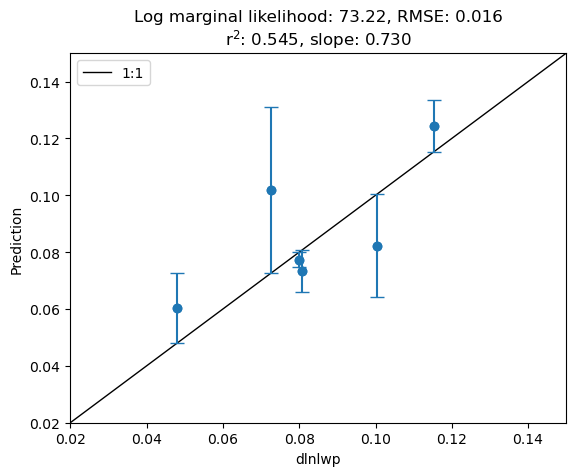

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find 

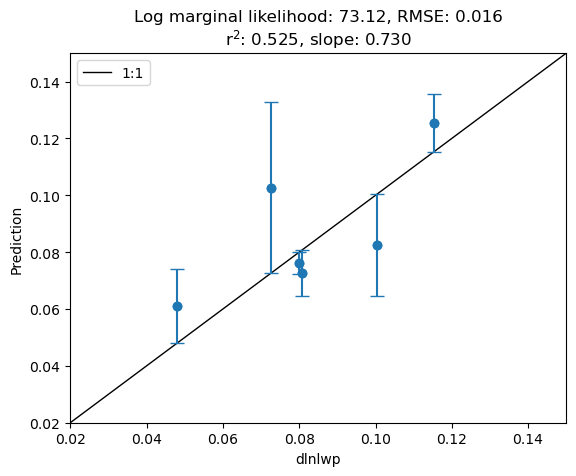

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find 

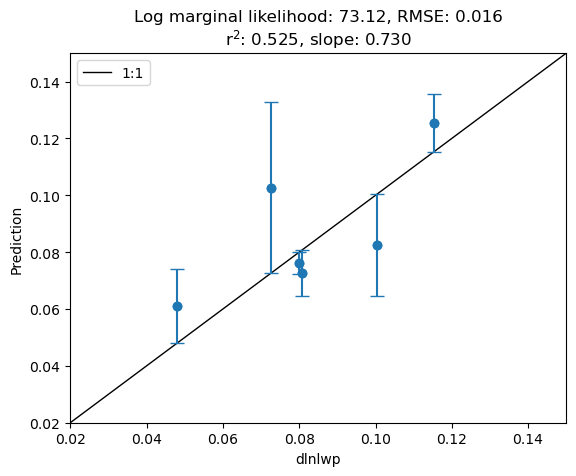

1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


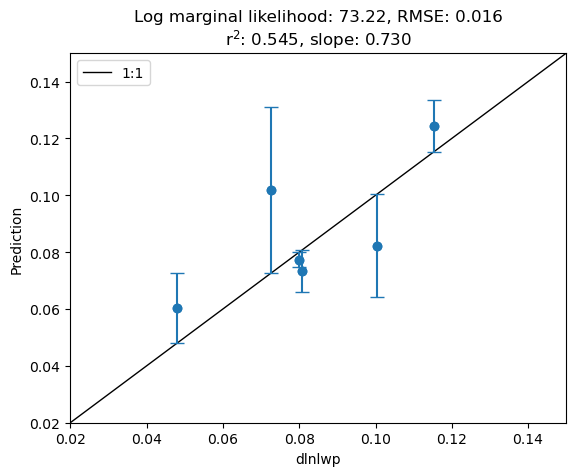

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


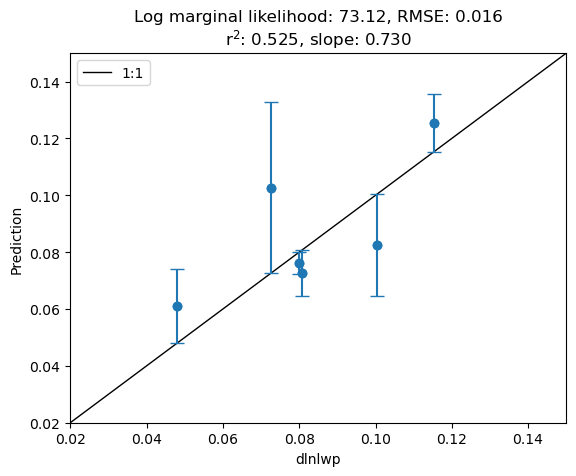

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


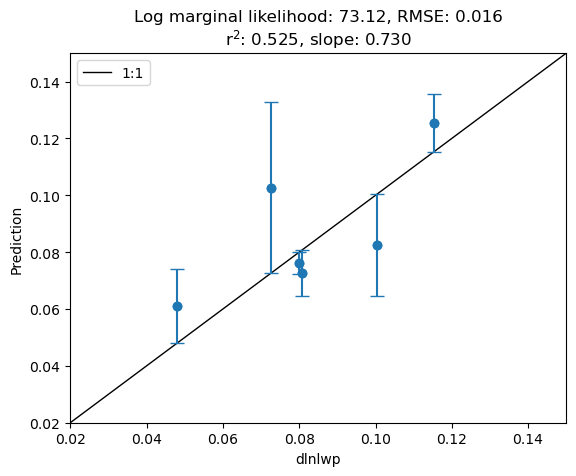

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


1**2 + 1**2 * 1**2 + 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.wa

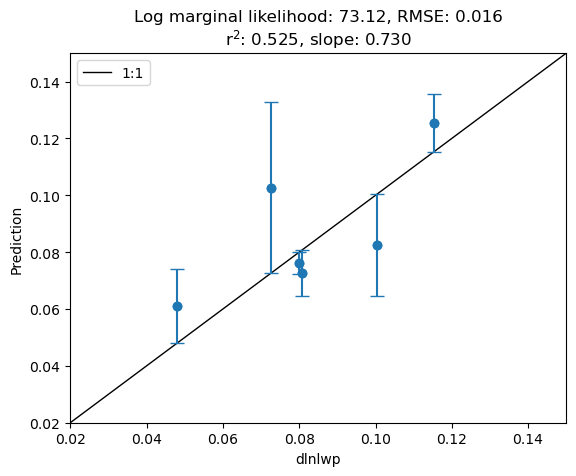

1**2 + 1**2 * 1**2 + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


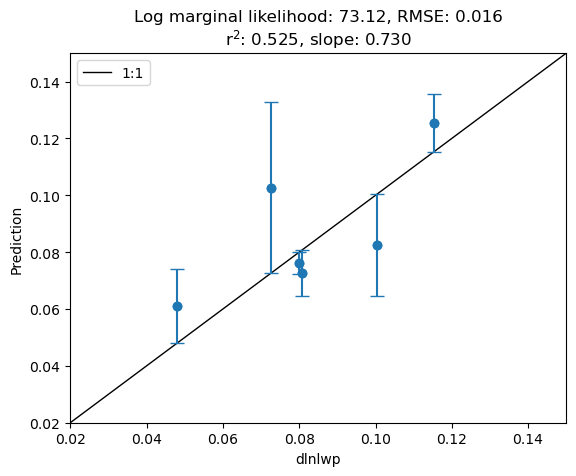

1**2 + 1**2 * 1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


1**2 + 1**2 * 1**2 + 1**2 * 1**2 + WhiteKernel(noise_level=1)
1**2 + 1**2 * 1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


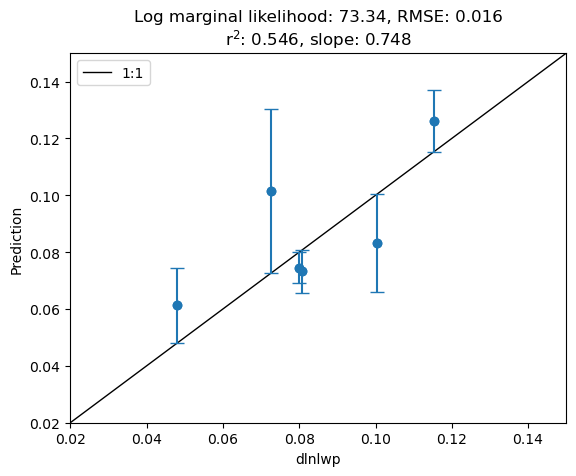

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


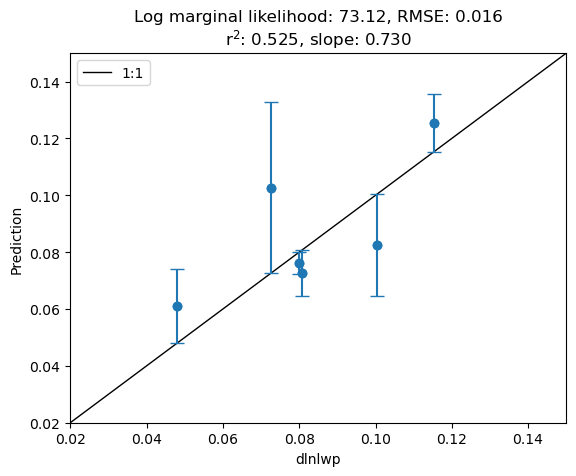

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


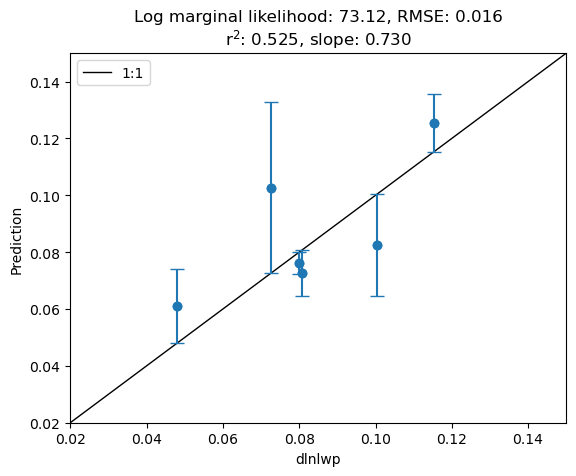

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


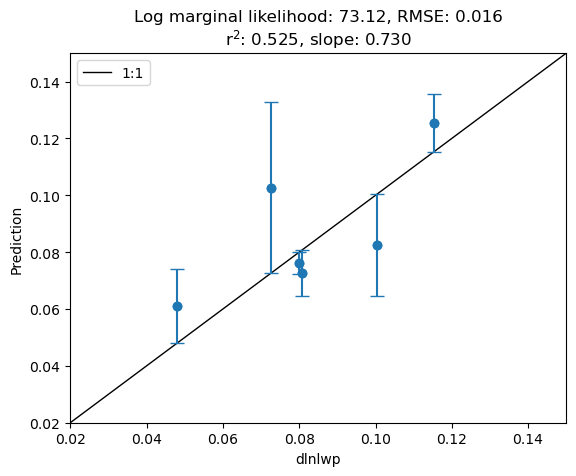

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


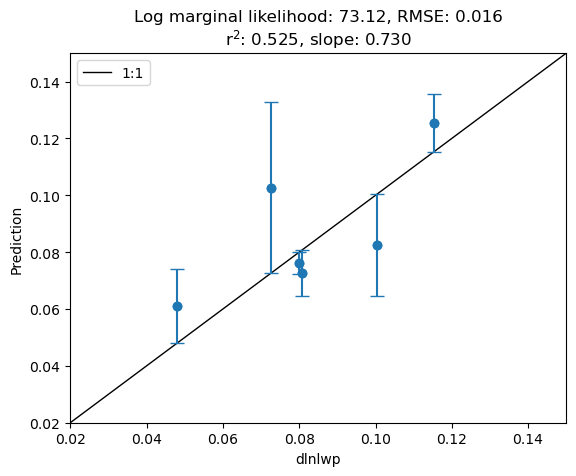

1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)
1**2 + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.w

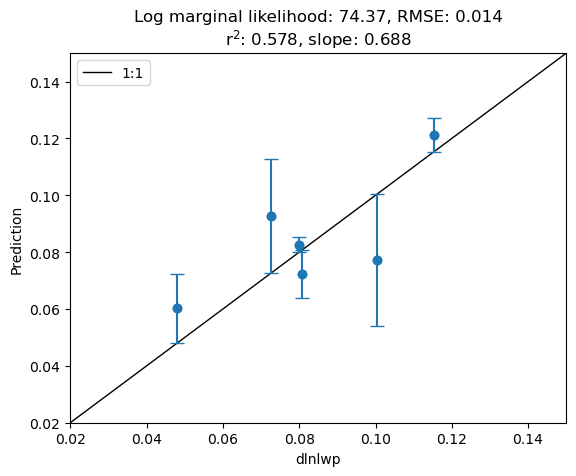

1**2 + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


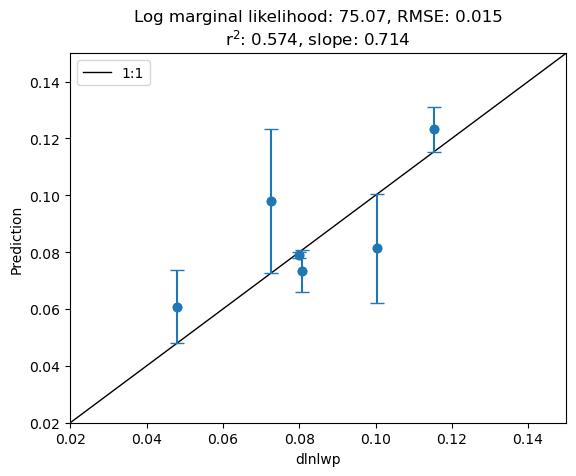

1**2 + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.

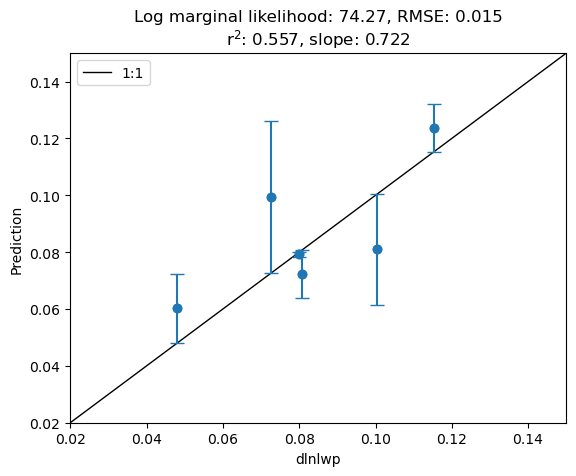

1**2 + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


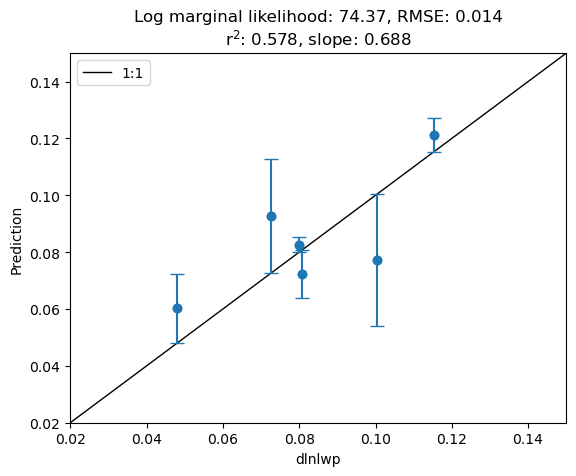

1**2 + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


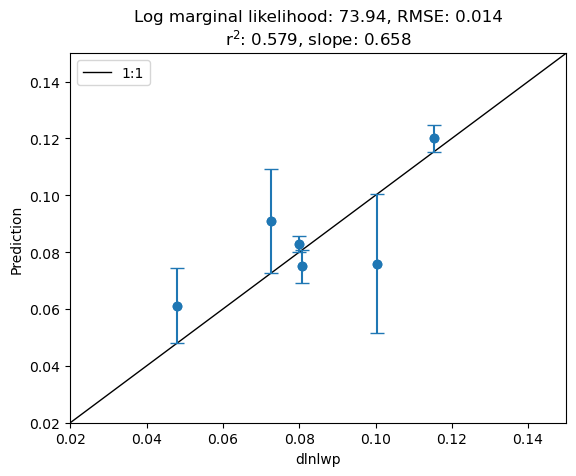

1**2 + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.w

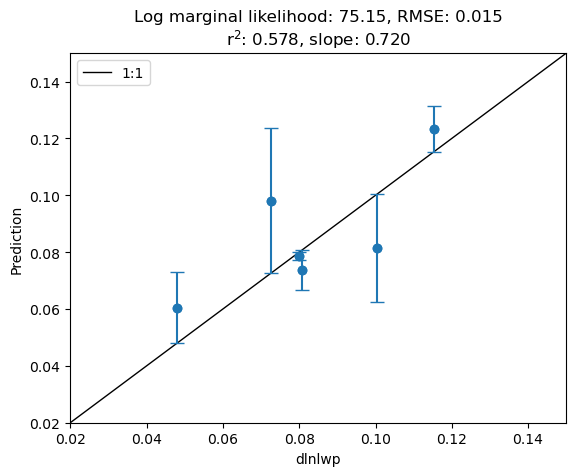

1**2 + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


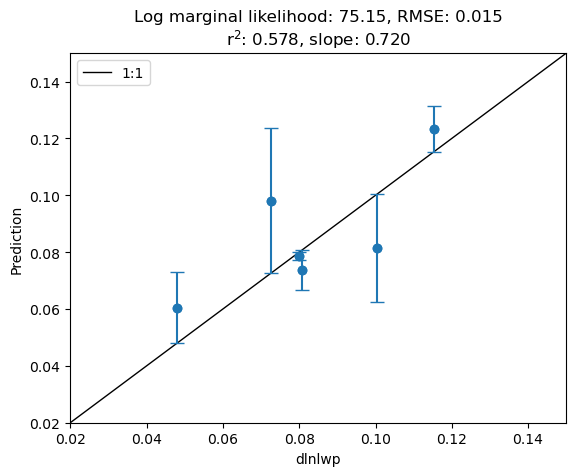

1**2 + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


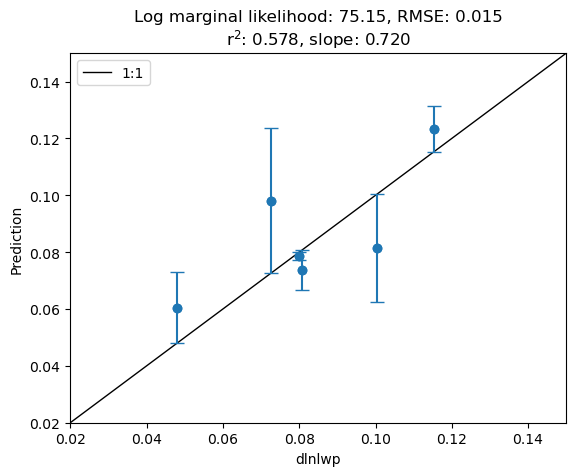

1**2 + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


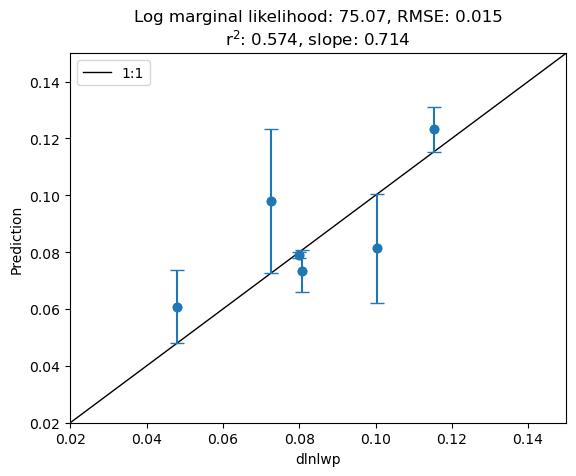

1**2 + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


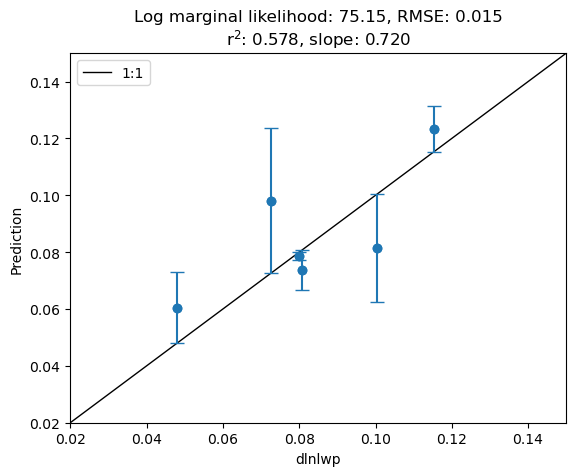

1**2 + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

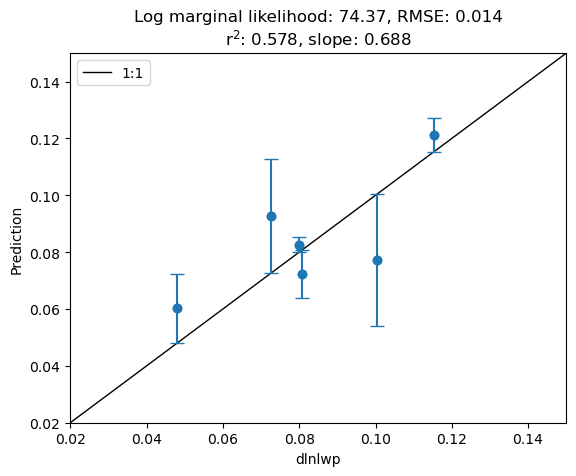

1**2 + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


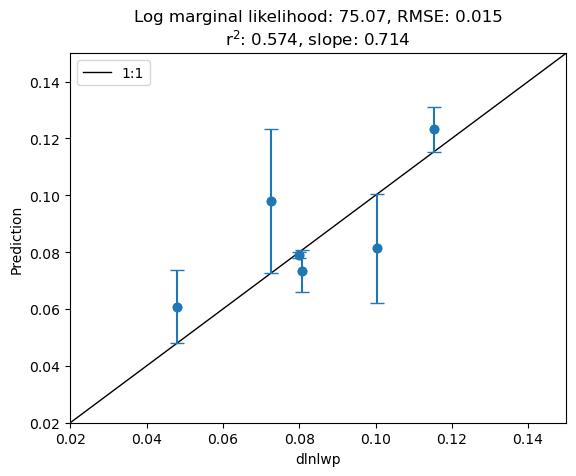

1**2 + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.w

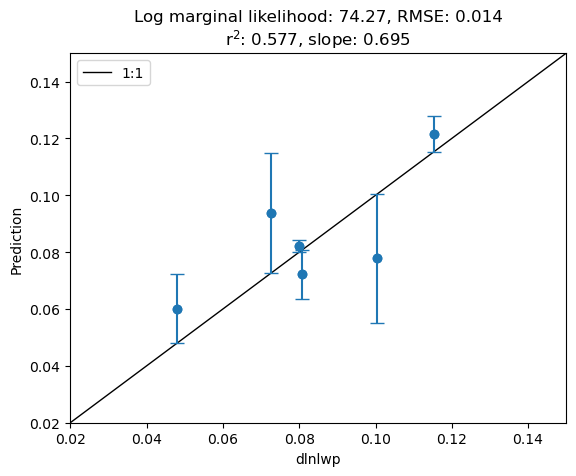

1**2 + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


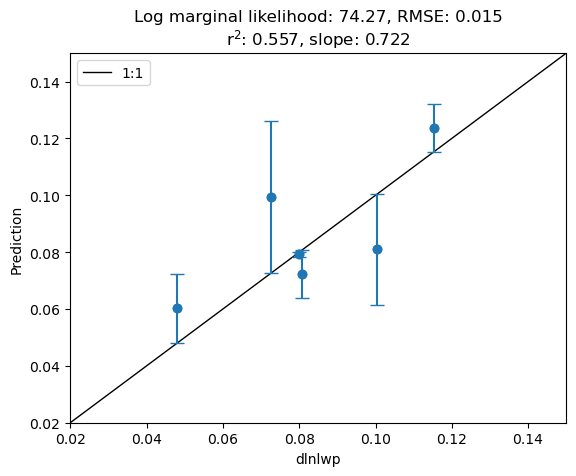

1**2 + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


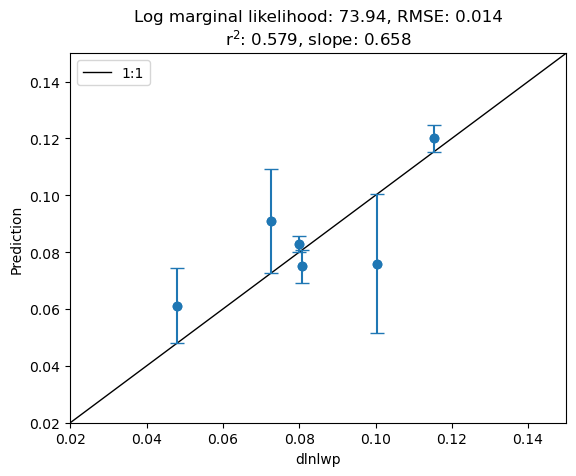

1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


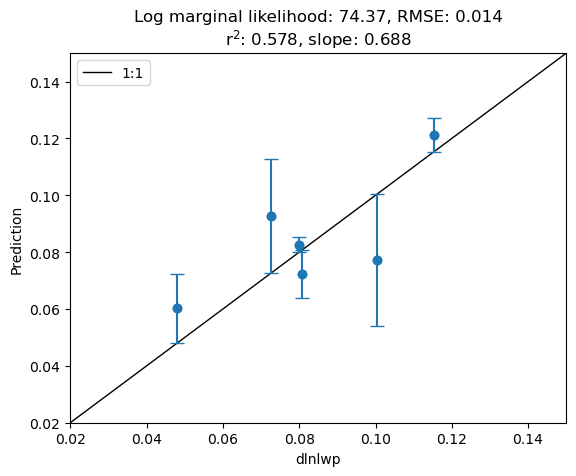

1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


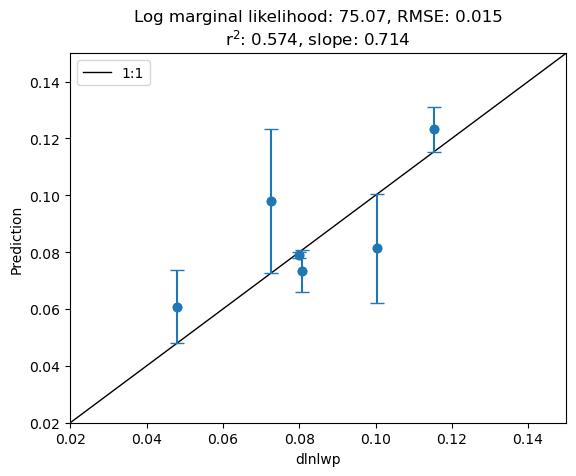

1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


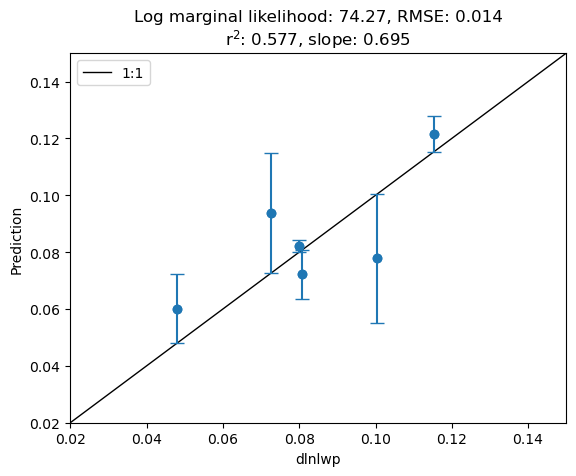

1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


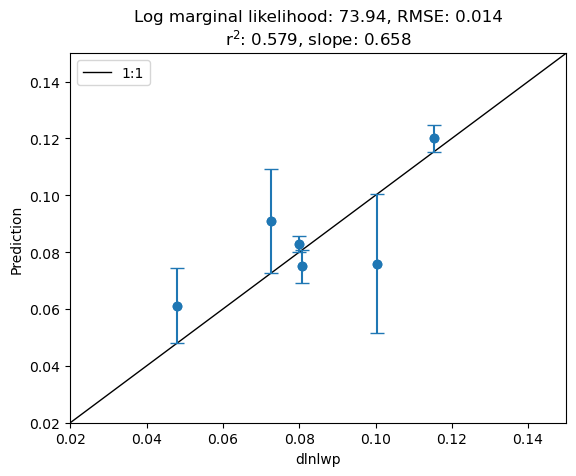

1**2 + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


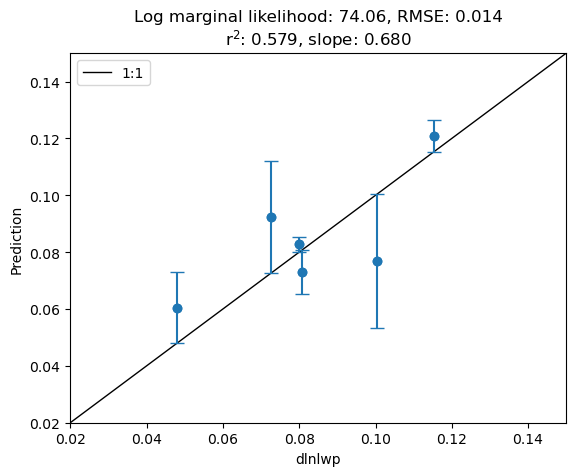

1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


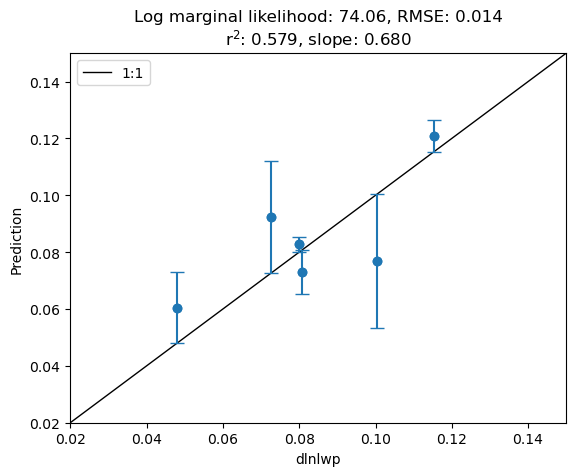

1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


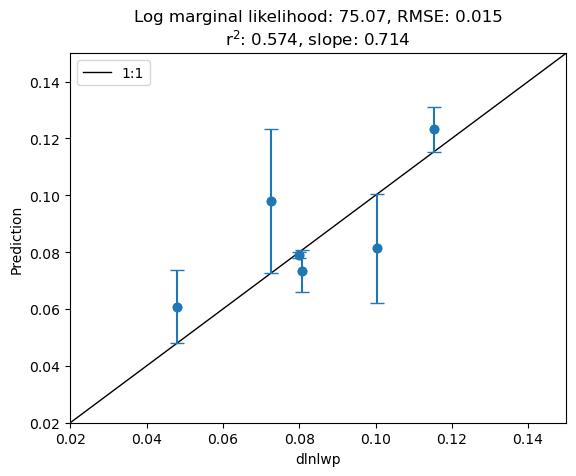

1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


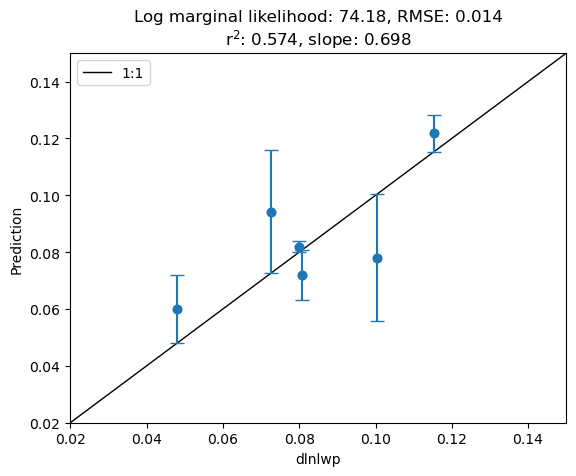

1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * 1**2 + WhiteKernel(noise_level=1)


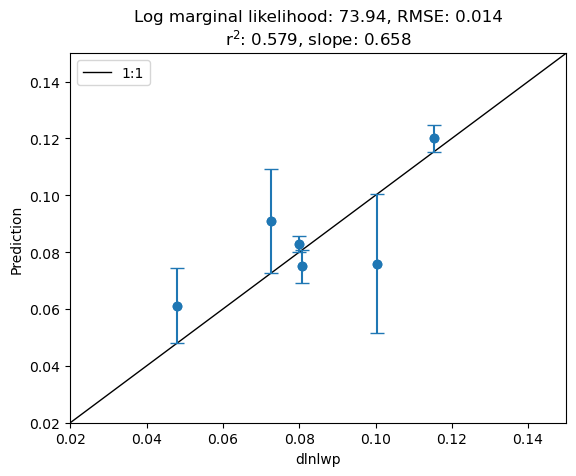

1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  wa

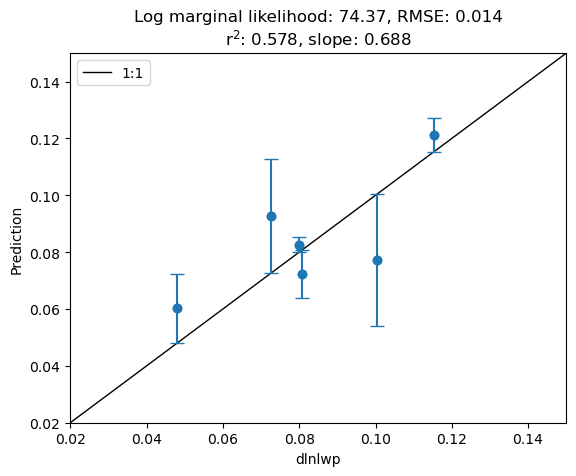

In [13]:
# new, based on EHAM scatter plots
dkernels_1 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*x + \
              kernels.ConstantKernel()*y + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels]

# old, based on multi-PPE scatter plots 
dkernels_2 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), y) + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels]

kernels_list = dkernels_1 + dkernels_2

# dlnlwp
find_kernel_single_PPE("ECHAM6-HAM", "dlnlwp", elims=[-3.5, -0.75], dlims=[0.02, 0.15],
                          kernels_list=kernels_list, pos_slope_only=True)

dlnlwp_eham_kernel = kernels.ConstantKernel() + \
                     kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.RationalQuadratic()) + \
                     kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.RBF()) + \
                     kernels.WhiteKernel()


1**2 + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * 1**2 + 1**2 * DotProduct(sigma_0=1) * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit agai

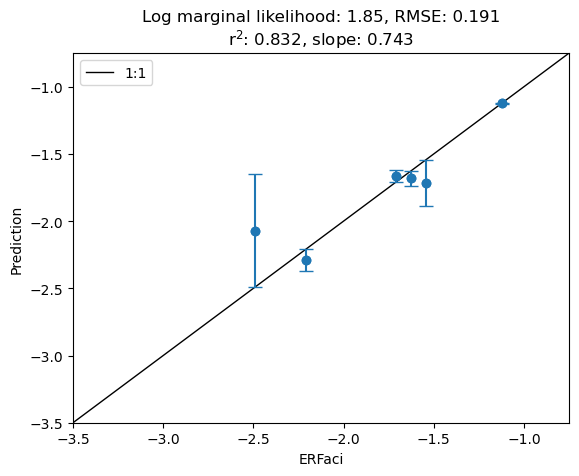

In [10]:
# new, based on EHAM scatter plots
ekernels_1 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*x + \
              kernels.ConstantKernel()*y + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), z) + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels for z in base_kernels]

# old, based on multi-PPE scatter plots 
ekernels_2 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), y) + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels]

kernels_list = ekernels_1 + ekernels_2


# erfaci
find_kernel_single_PPE("ECHAM6-HAM", "ERFaci", elims=[-3.5, -0.75], dlims=[0.02, 0.15],
                          kernels_list=kernels_list, pos_slope_only=True)


# "winner" is this one 
erfaci_eham_kernel = kernels.ConstantKernel() + \
                     kernels.ConstantKernel()*kernels.ExpSineSquared() + \
                     kernels.ConstantKernel()*kernels.ConstantKernel() + \
                     kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.Matern()) + \
                     kernels.WhiteKernel()


#### Multi-PPE


In [5]:
data = pg.get_multippe_data(pg.get_ppe_ds_dict(file_path, pickle_path))
lwp, lnlwp, dlwp, dlnlwp, dadlwp, dlwp_dadlwp, dnd, erfaci = data


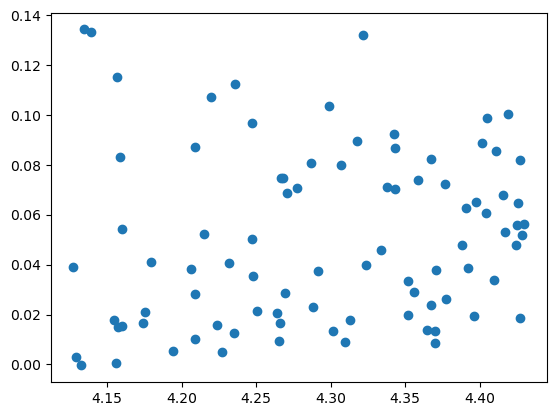

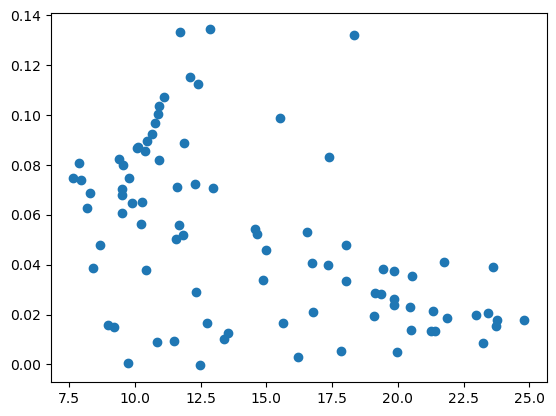

In [6]:
# dlnlwp: 
plt.scatter(lnlwp, dlnlwp)
plt.show()
plt.scatter(dnd, dlnlwp)
plt.show()

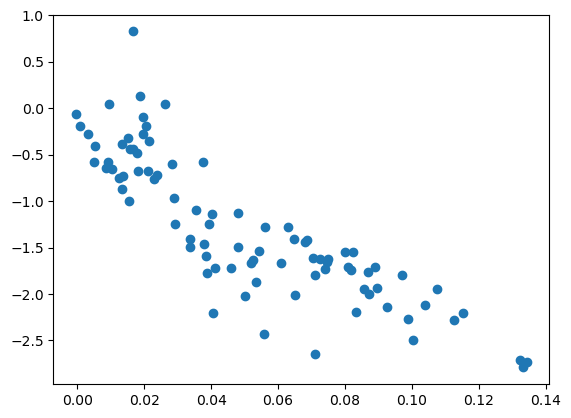

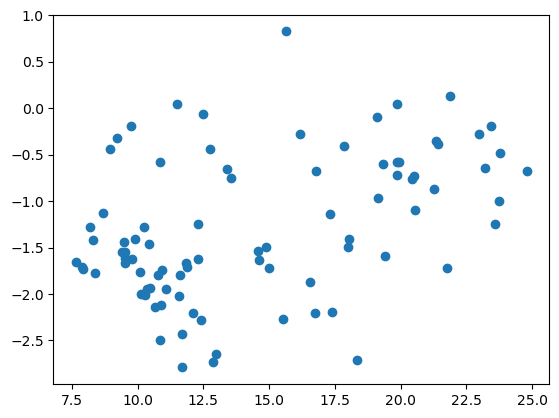

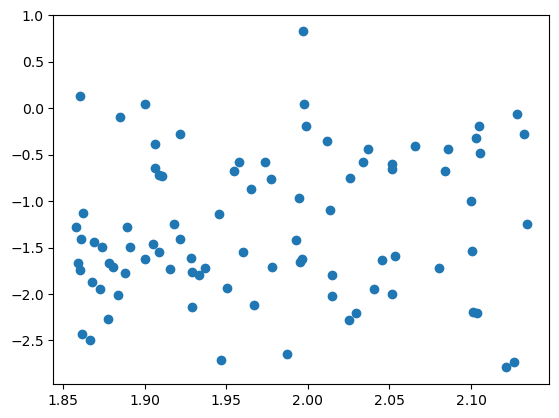

In [7]:
# erfaci: 
plt.scatter(dlnlwp, erfaci)
plt.show()
plt.scatter(dnd, erfaci)
plt.show()
plt.scatter(dadlwp, erfaci)
plt.show()

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * DotProduct(sigma_0=1) * 1**2 + 1**2 * DotProduct(sigma_0=1) * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

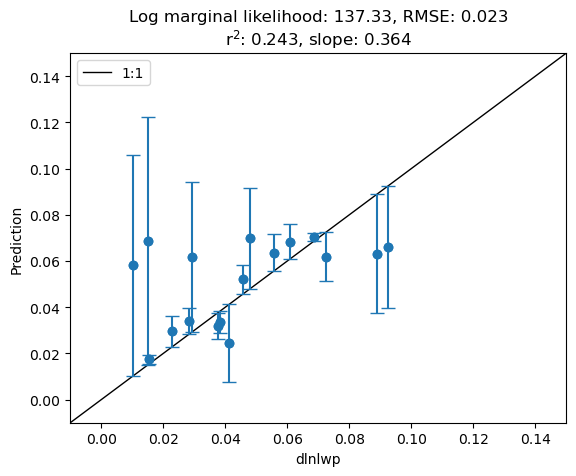

1**2 + 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1)


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


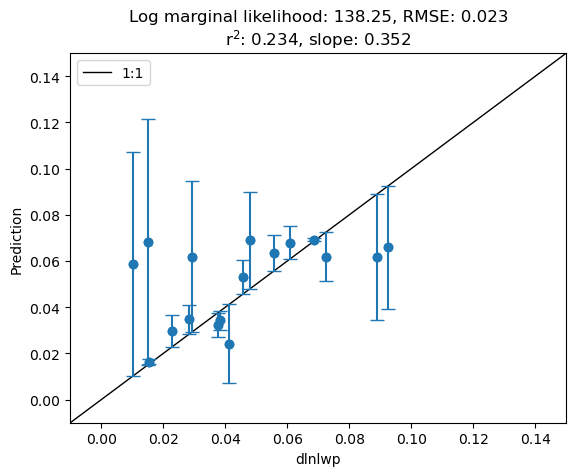

1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


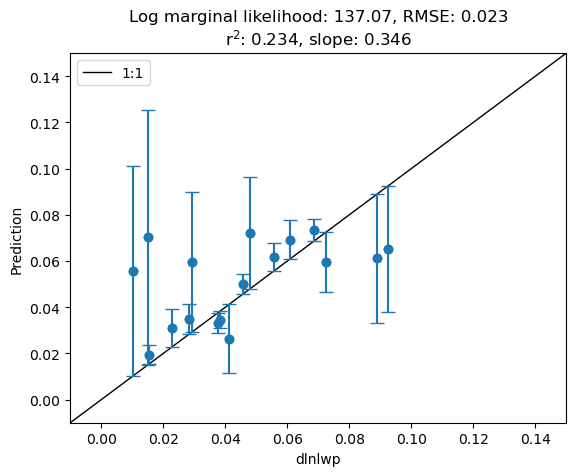

In [26]:
dkernels_1 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*x + \
              kernels.ConstantKernel()*y + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels]

dkernels_2 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), y) + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels]

dkernels_3 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*x + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), y) + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), z) + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels  for z in base_kernels]

kernels_list = dkernels_1 + dkernels_2 + dkernels_3

# compare the new "best" to the old one
test1 = kernels.ConstantKernel() + \
        kernels.ConstantKernel()*kernels.Matern() + \
        kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.ConstantKernel()) + \
        kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.RBF()) + \
        kernels.WhiteKernel()
test2 = kernels.ConstantKernel() + \
        kernels.ConstantKernel()*kernels.Matern() + \
        kernels.ConstantKernel()*kernels.RBF() + \
        kernels.WhiteKernel()
test3 = pg.DLNLWP_KERNEL

# dlnlwp
training, testing = pg.split_train_test(data, "dlnlwp", test_split=0.2)
pg.find_good_kernel("dlnlwp", training, testing,
                   # kernels_list=kernels_list, pos_slope_only=True)
                   kernels_list=[test1, test2, test3], pos_slope_only=False)

# "winner"
dlnlwp_multi_kernel = kernels.ConstantKernel() + \
                      kernels.ConstantKernel()*kernels.Matern() + \
                      kernels.ConstantKernel()*kernels.RBF() + \
                      kernels.WhiteKernel()


1**2 + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1)


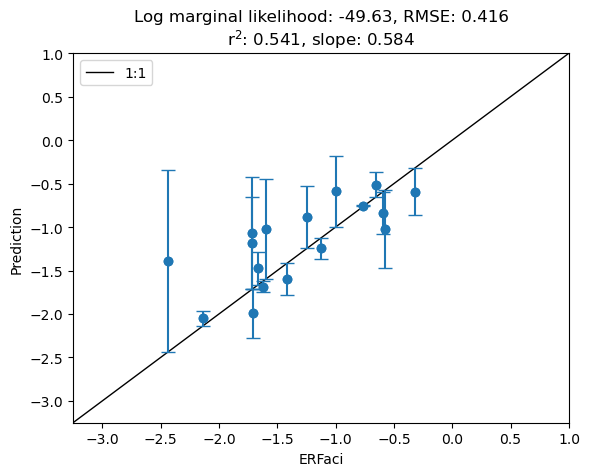

1**2 + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * DotProduct(sigma_0=1) * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1)


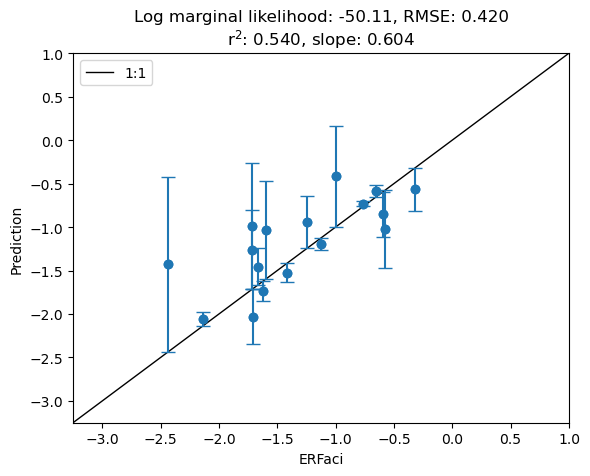

In [16]:
ekernels_1 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*x + \
              kernels.ConstantKernel()*y + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), z) + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels for z in base_kernels]

ekernels_2 = [kernels.ConstantKernel() + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), x) + \
              kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), y) + \
              kernels.WhiteKernel() for x in base_kernels for y in base_kernels]

kernels_list = ekernels_1 + ekernels_2

# compare the new "best" to the old one
test1 = kernels.ConstantKernel() + \
        kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.ExpSineSquared()) + \
        kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.ExpSineSquared()) + \
        kernels.WhiteKernel()
test2 = pg.ERFACI_KERNEL

# erfaci
training, testing = pg.split_train_test(data, "ERFaci", test_split=0.2)
pg.find_good_kernel("ERFaci", training, testing,
                   # kernels_list=kernels_list, pos_slope_only=True)
                   kernels_list=[test1, test2], pos_slope_only=False)



# "Winner"
erfaci_multi_kernel = kernels.ConstantKernel() + \
                      kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.ExpSineSquared()) + \
                      kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.ExpSineSquared()) + \
                      kernels.WhiteKernel()


### Look at the "winners" & save models for future reference

In [8]:
ds_dict = pg.get_ppe_ds_dict(file_path, pickle_path)


#### dlnlwp

In [9]:
dlnlwp_eham_kernel = kernels.ConstantKernel() + \
                     kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.RationalQuadratic()) + \
                     kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.RBF()) + \
                     kernels.WhiteKernel()
dlnlwp_cam6_kernel = kernels.ConstantKernel() + \
                     kernels.ConstantKernel()*kernels.ExpSineSquared() + \
                     kernels.ConstantKernel()*kernels.RationalQuadratic() + \
                     kernels.WhiteKernel()
dlnlwp_ga71_kernel = kernels.ConstantKernel() + \
                     kernels.ConstantKernel()*kernels.ExpSineSquared() + \
                     kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.Matern()) + \
                     kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.ConstantKernel()) + \
                     kernels.WhiteKernel()
dlnlwp_e3sm_kernel = kernels.ConstantKernel() + \
                     kernels.ConstantKernel()*kernels.ExpSineSquared() + \
                     kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.RationalQuadratic()) + \
                     kernels.WhiteKernel()

dlnlwp_multi_kernel = kernels.ConstantKernel() + \
                      kernels.ConstantKernel()*kernels.Matern() + \
                      kernels.ConstantKernel()*kernels.RBF() + \
                      kernels.WhiteKernel()

In [10]:
dkernel_dict = {
    "E3SMv3": dlnlwp_e3sm_kernel,
    "CAM6": dlnlwp_cam6_kernel,
    "GA7.1": dlnlwp_ga71_kernel,
    "ECHAM6-HAM": dlnlwp_eham_kernel,
    "multi": dlnlwp_multi_kernel
}

E3SMv3


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


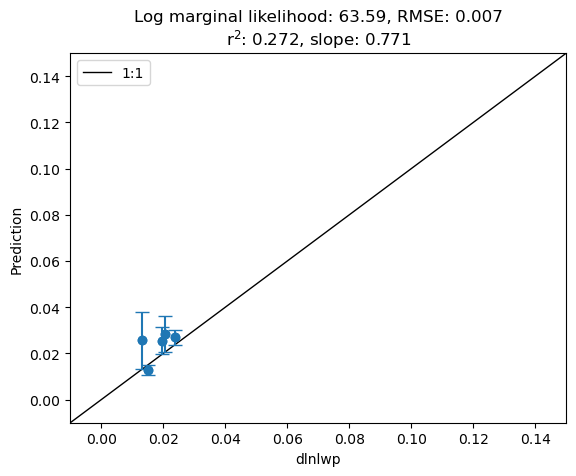

GA7.1


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

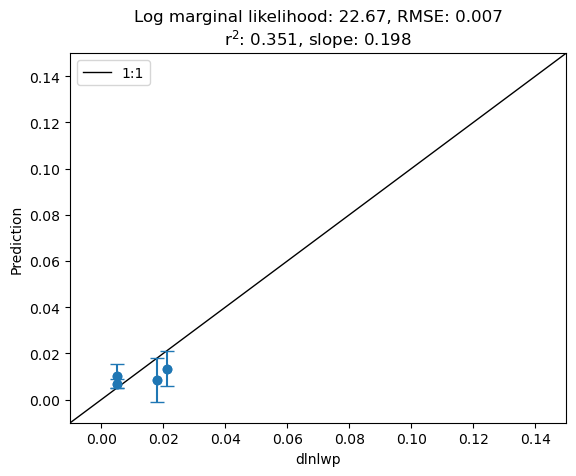

CAM6


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


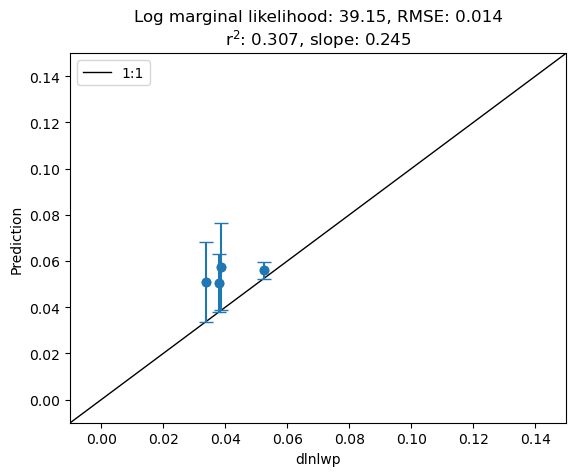

ECHAM6-HAM


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.w

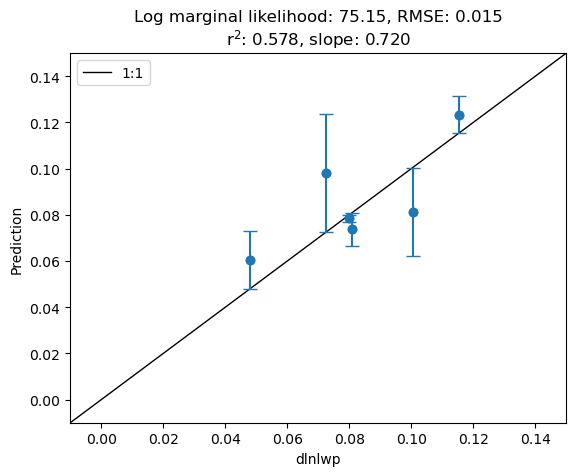

multi


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


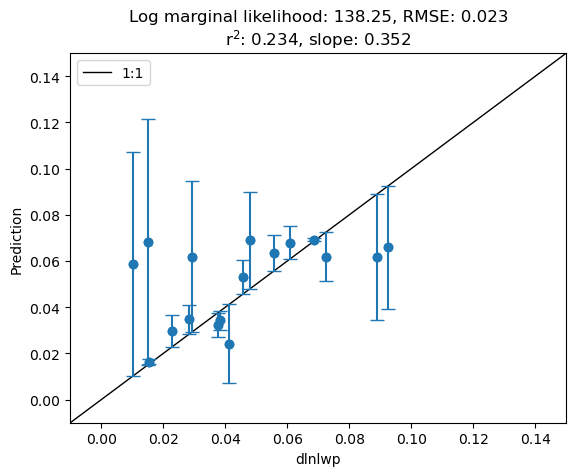

In [23]:
gp_dlnlwp_dict = {}

for ppe in list(ds_dict.keys()) + ["multi"]:
    print(ppe)
    if ppe == "multi":
        data = pg.get_multippe_data(ds_dict)
    else:
        data = pg.get_ppe_data(ds_dict[ppe], ppe)

    if ppe == "GA7.1":
        test_split = 0.3
    else:
        test_split = 0.2
        
    training, testing = pg.split_train_test(data, "dlnlwp", test_split=test_split)
    gp_dlnlwp_dict[ppe] = pg.train_test_gp(dkernel_dict[ppe], training, testing, "dlnlwp", return_model=True,
                                           show_plot=True, copy_X_train=True)
    print("===========")
    

#### ERFaci

In [13]:
erfaci_eham_kernel = kernels.ConstantKernel() + \
                     kernels.ConstantKernel()*kernels.ExpSineSquared() + \
                     kernels.ConstantKernel()*kernels.ConstantKernel() + \
                     kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.Matern()) + \
                     kernels.WhiteKernel()
erfaci_cam6_kernel = kernels.ConstantKernel() + \
                     kernels.ConstantKernel()*kernels.ExpSineSquared() + \
                     kernels.ConstantKernel()*kernels.ExpSineSquared() + \
                     kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.RBF()) + \
                     kernels.WhiteKernel()
erfaci_ga71_kernel = kernels.ConstantKernel() + \
                      kernels.ConstantKernel()*kernels.ExpSineSquared() + \
                      kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.RationalQuadratic()) + \
                      kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.RationalQuadratic()) + \
                      kernels.WhiteKernel()
erfaci_e3sm_kernel = kernels.ConstantKernel() + \
                     kernels.ConstantKernel()*kernels.ConstantKernel() + \
                     kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.ExpSineSquared()) + \
                     kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.Matern()) + \
                     kernels.WhiteKernel()

erfaci_multi_kernel = kernels.ConstantKernel() + \
                      kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.ExpSineSquared()) + \
                      kernels.ConstantKernel()*kernels.Product(kernels.DotProduct(), kernels.ExpSineSquared()) + \
                      kernels.WhiteKernel()

In [14]:
ekernel_dict = {
    "E3SMv3": erfaci_e3sm_kernel,
    "CAM6": erfaci_cam6_kernel,
    "GA7.1": erfaci_ga71_kernel,
    "ECHAM6-HAM": dlnlwp_eham_kernel,
    "multi": erfaci_multi_kernel
}

E3SMv3


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.

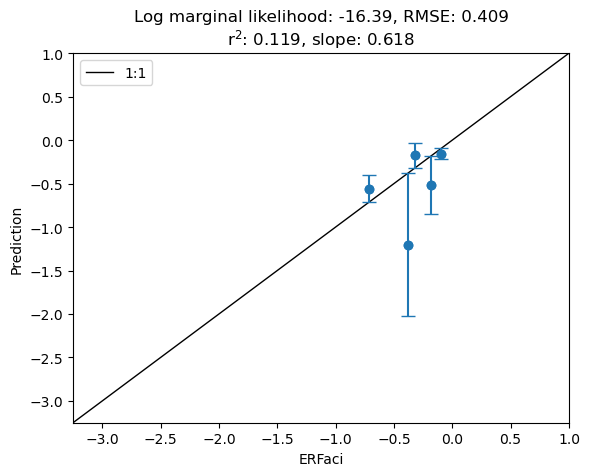

GA7.1


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__periodicity is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:478: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


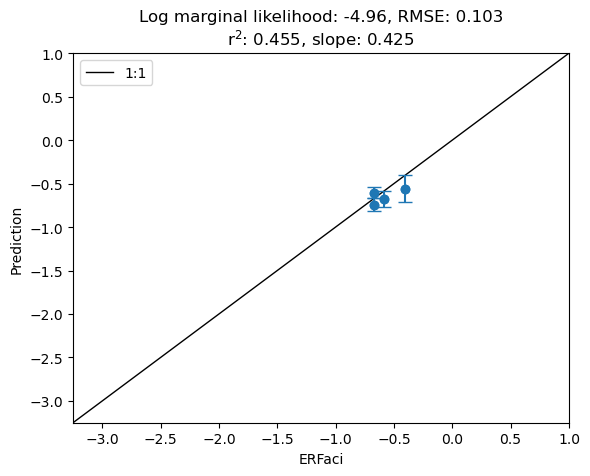

CAM6


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:478: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


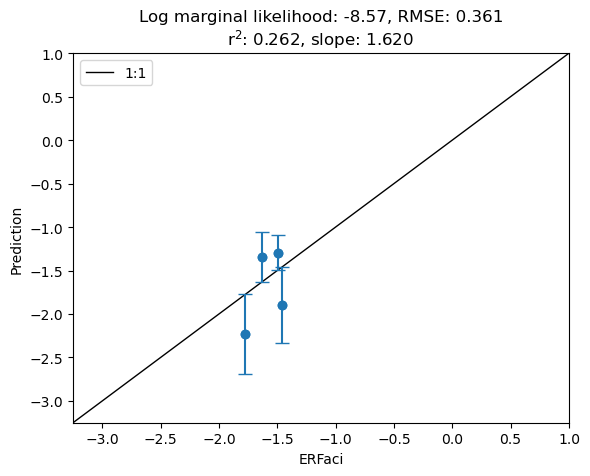

ECHAM6-HAM


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.

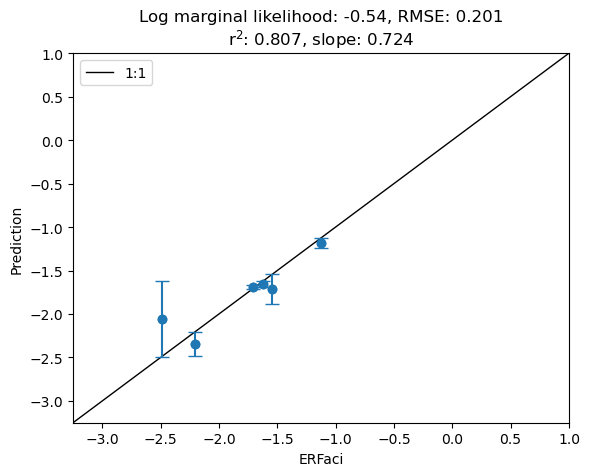

multi


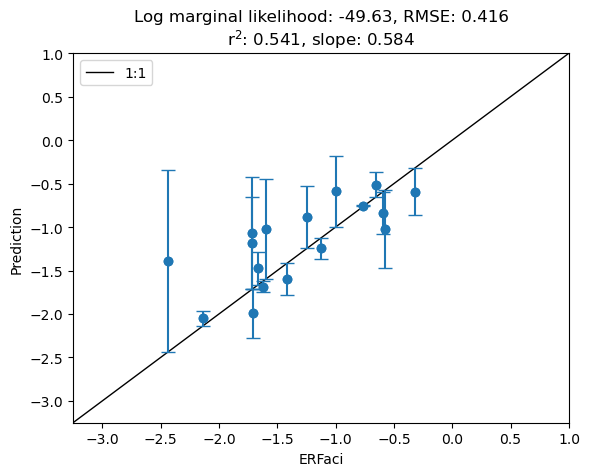

In [24]:
gp_erfaci_dict = {}

for ppe in ppe_list + ["multi"]:
    print(ppe)
    if ppe == "multi":
        data = pg.get_multippe_data(ds_dict)
    else:
        data = pg.get_ppe_data(ds_dict[ppe], ppe)

    if ppe == "GA7.1":
        test_split = 0.3
    else:
        test_split = 0.2
        
    training, testing = pg.split_train_test(data, "ERFaci", test_split=test_split)
    
    gp_erfaci_dict[ppe] = pg.train_test_gp(ekernel_dict[ppe], training, testing, "ERFaci", return_model=True,
                                           show_plot=True, copy_X_train=True)
    print("===========")


Save models

In [31]:
with open(out_path + "PPE_GPreg_models_dlnlwp.pickle", "wb") as handle:
    pickle.dump(gp_dlnlwp_dict, handle)
with open(out_path + "PPE_GPreg_models_ERFaci.pickle", "wb") as handle:
    pickle.dump(gp_erfaci_dict, handle)


Save kernels

In [33]:

with open(out_path + "PPE_dlnlwp_kernels.pickle", "wb") as handle:
    pickle.dump(dkernel_dict, handle)
with open(out_path + "PPE_ERFaci_kernels.pickle", "wb") as handle:
    pickle.dump(ekernel_dict, handle)


### Find & save the 90% and 95% CIs

In [8]:
# get kernels back
with open(out_path + "PPE_dlnlwp_kernels.pickle", "rb") as handle:
    dkernel_dict = pickle.load(handle)
with open(out_path + "PPE_ERFaci_kernels.pickle", "rb") as handle:
    ekernel_dict = pickle.load(handle)
    

In [9]:
ppe_dlnlwp_ci_dict = {}
ppe_erfaci_ci_dict = {}

for ppe in ppe_list + ["multi"]:
    print(ppe)
    dkernel = dkernel_dict[ppe]
    ppe_dlnlwp_ci_dict[ppe] = pg.conf_int_from_gp(ppe, "dlnlwp", file_path=file_path, 
                                                  pickle_path=pickle_path, kernel=dkernel, show_plot=False)
    print("\n")
    
    dlnlwp_95ci = ppe_dlnlwp_ci_dict[ppe]["95%"]
    ekernel = ekernel_dict[ppe]
    ppe_erfaci_ci_dict[ppe] = pg.conf_int_from_gp(ppe, "ERFaci", dlnlwp_95ci=dlnlwp_95ci, 
                                                  file_path=file_path, pickle_path=pickle_path,
                                                 kernel=ekernel, show_plot=False)
    print("=========================")
    

E3SMv3


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


E3SMv3 PPE dlnlwp
90%: 0.007 to 0.034
95%: 0.004 to 0.037




/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.

E3SMv3 PPE ERFaci
90%: -1.353 to 0.126
95%: -1.497 to 0.270
GA7.1


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  wa

GA7.1 PPE dlnlwp
90%: -0.009 to 0.027
95%: -0.013 to 0.031




/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/g

GA7.1 PPE ERFaci
90%: -1.092 to 0.074
95%: -1.206 to 0.187
CAM6


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


CAM6 PPE dlnlwp
90%: 0.032 to 0.071
95%: 0.028 to 0.075




/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:478: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:478: UserWarning: Predicted variances smal

CAM6 PPE ERFaci
90%: -1.858 to -1.541
95%: -1.889 to -1.510
ECHAM6-HAM


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.w

ECHAM6-HAM PPE dlnlwp
90%: 0.107 to 0.143
95%: 0.103 to 0.147




/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.

ECHAM6-HAM PPE ERFaci
90%: -2.848 to -2.305
95%: -2.901 to -2.253
multi


/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/work/jnug/conda-envs/ppe/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


multi PPE dlnlwp
90%: -0.005 to 0.100
95%: -0.015 to 0.110


multi PPE ERFaci
90%: -1.994 to -0.484
95%: -2.141 to -0.337


#### ERFaci

In [14]:
print("95% CI ERFaci:")
for ppe in ppe_list + ["multi"]:
    print(ppe, ppe_erfaci_ci_dict[ppe]["95%"])

print("\n90% CI ERFaci:")
for ppe in ppe_list + ["multi"]:
    print(ppe, ppe_erfaci_ci_dict[ppe]["90%"])
    

95% CI ERFaci:
E3SMv3 [-1.497265065574794, 0.2699601987806092]
GA7.1 [-1.2058494781482825, 0.18731098268722424]
CAM6 [-1.8887670713703808, -1.5096815048762111]
ECHAM6-HAM [-2.901459240779367, -2.252507305481825]
multi [-2.141267103108873, -0.3370173896321992]

90% CI ERFaci:
E3SMv3 [-1.3530017786886388, 0.12569691189445376]
GA7.1 [-1.0921220935902818, 0.07358359812922366]
CAM6 [-1.8578213108402446, -1.5406272654063473]
ECHAM6-HAM [-2.848483572591813, -2.3054829736693794]
multi [-1.993981412212818, -0.4843030805282542]


In [15]:
with open(out_path + "PPE_CI_dicts_ERFaci.pickle", "wb") as handle:
    pickle.dump(ppe_erfaci_ci_dict, handle)
    

#### dlnLWP

In [16]:
print("95% CI dlnlwp:")
for ppe in ppe_list + ["multi"]:
    print(ppe, ppe_dlnlwp_ci_dict[ppe]["95%"])

print("\n90% CI dlnlwp:")
for ppe in ppe_list + ["multi"]:
    print(ppe, ppe_dlnlwp_ci_dict[ppe]["90%"])
    

95% CI dlnlwp:
E3SMv3 [0.004479538853151537, 0.03706611169927515]
GA7.1 [-0.012882078183863794, 0.03071008667590604]
CAM6 [0.028434363075665832, 0.07477569721763874]
ECHAM6-HAM [0.10347707953958069, 0.14659153273026276]
multi [-0.015116991449281247, 0.11046157252474717]

90% CI dlnlwp:
E3SMv3 [0.007139667248753466, 0.03440598330367323]
GA7.1 [-0.009323534113678502, 0.02715154260572075]
CAM6 [0.03221732912807178, 0.07099273116523279]
ECHAM6-HAM [0.10699662673882004, 0.1430719855310234]
multi [-0.0048656801044625955, 0.10021026117992851]


In [17]:
with open(out_path + "PPE_CI_dicts_dlnlwp.pickle", "wb") as handle:
    pickle.dump(ppe_dlnlwp_ci_dict, handle)
    

In [3]:
print("multi-PPE CI size:", str(-1.993981412212818 - -0.3370173896321992))
print("WCRP CI size:", str(-2.65 - -0.07))


multi-PPE CI size: -1.656964022580619
WCRP CI size: -2.58


In [4]:
(-1.656964022580619 - -2.58)/-2.58

-0.3577658827206903

In [5]:
2.58*(1-.35)

1.677

In [6]:
import numpy as np
import pickle
np.exp(-0.1)

0.9048374180359595

In [4]:
with open("WCRP_delta_lnLWP_values.pickle", "rb") as handle:
    wcrp = pickle.load(handle)

In [5]:
wcrp

{'min': -0.1, 'max': 0.05}